<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/Germany/Hugo/Hugo_1H_High.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "BOSSDEEUR"
data_resample = '1H'
data_label = 'High'
data_label_name = 'y'
start_date = '1 Jan 2018'
finish_date = '1 Jan 2019'
is_duka = True
is_yahoo = False
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

2019-08-28 14:34:20,055 - findatapy.market.datavendorweb - INFO - Request Dukascopy data
2019-08-28 14:34:20,057 - findatapy.market.datavendorweb - INFO - About to download from Dukascopy... for BOSSDEEUR
2019-08-28 14:35:04,993 - findatapy.market.datavendorweb - INFO - Downloading... 2018-01-30 00:00:00
2019-08-28 14:36:39,384 - findatapy.market.datavendorweb - INFO - Downloading... 2018-03-30 00:00:00
2019-08-28 14:37:28,956 - findatapy.market.datavendorweb - INFO - Downloading... 2018-04-30 00:00:00
2019-08-28 14:38:17,518 - findatapy.market.datavendorweb - INFO - Downloading... 2018-05-30 00:00:00
2019-08-28 14:39:32,566 - findatapy.market.datavendorweb - INFO - Downloading... 2018-06-30 00:00:00
2019-08-28 14:40:41,863 - findatapy.market.datavendorweb - INFO - Downloading... 2018-07-30 00:00:00
2019-08-28 14:41:53,661 - findatapy.market.datavendorweb - INFO - Downloading... 2018-08-30 00:00:00
2019-08-28 14:43:09,482 - findatapy.market.datavendorweb - INFO - Downloading... 2018-09

/usr/local/lib/python3.6/dist-packages/findatapy/market/ioengine.py:264: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  r.set(fname, data_frame.to_msgpack(compress='blosc'))


2019-08-28 14:45:39,975 - findatapy.market.ioengine - WARNING - Couldn't push MarketDataRequest_445__abstract_curve_key-None__category-None__category_key-backtest_default-cat_dukascopy_tick_NYC_BOSSDEEUR__cut-NYC__data_source-dukascopy__environment-backtest__expiry_date-NaT__fields-temp_ask_bid_askv_bidv__finish_date-2019-01-01 00:00:00__freq-tick__freq_mult-1__gran_freq-None__resample-None__resample_how-last__start_date-2018-01-01 00:00:00__tickers-BOSSDEEUR__trade_side-trade__vendor_fields-temp_ask_bid_askv_bidv__vendor_tickers-BOSSDEEUR to Redis: Error 111 connecting to 127.0.0.1:6379. Connection refused.


Open     High      Low    Close     Volume
Date                                                              
2018-01-02 08:00:00  0.71197  0.71598  0.70777  0.71517  19.460371
2018-01-02 09:00:00  0.71478  0.72118  0.71437  0.71917  19.574858
2018-01-02 10:00:00  0.71918  0.72178  0.71807  0.72098  10.609527
2018-01-02 11:00:00  0.72097  0.72398  0.72058  0.72257   7.737653
2018-01-02 12:00:00  0.72257  0.72498  0.72138  0.72328  13.414879
...                      ...      ...      ...      ...        ...
2018-12-28 08:00:00  0.53188  0.53728  0.53107  0.53307  61.718399
2018-12-28 09:00:00  0.53307  0.53688  0.53197  0.53637  46.478001
2018-12-28 10:00:00  0.53637  0.53847  0.53487  0.53598  43.910400
2018-12-28 11:00:00  0.53617  0.53927  0.53408  0.53627  39.104599
2018-12-28 12:00:00  0.53627  0.53878  0.53478  0.53728  51.474667

[2248 rows x 5 columns]

Open         High          Low        Close       Volume
count  2248.000000  2248.000000  2248.000000  2248.000000  2248.000000
mean      0.706732     0.709062     0.704294     0.706723    12.963424
std       0.064492     0.064334     0.064733     0.064567     9.288733
min       0.526770     0.529770     0.524900     0.529280     1.578011
25%       0.663577     0.667530     0.660523     0.663222     7.100648
50%       0.720570     0.722980     0.718370     0.720580    10.530329
75%       0.761205     0.763628     0.759180     0.761373    15.790810
max       0.804580     0.813780     0.802770     0.804580    86.795708

25

In [5]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [6]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open     High      Low    Close     Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  BBANDS_lowerband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
2018-01-09 13:00:00  0.72958  0.72998  0.72698  0.72797   4.000029    9          1          9             31    13             0               0                 0      1        1     2        1             0           2  0.730177  0.727923 -0.736337  0.728968  0.730226  0.730329    0.730870    0.730830  0.734524  0.730124  0.728247  0.731025  0.730007  0.730124  0.728707  0.732021                0.735561                 0.730124                0.724687                0.738280                 0.730124                0.721968                0.740998                 0.730124                0.719249                0.743717                 0.730124                0.716531  0.730226  0.728907  0.732054                0.735663                 0.730226                0.724789                0.738382                 0.730226                0.722070                0.741100                 0.730226                0.719351                0.743819                 0.730226                0.716633   
2018-01-09 14:00:00  0.72837  0.72958  0.72777  0.72918   6.750957    9          1          9             31    14             0               0                 0      1        1     2        1             0           2  0.730127  0.727978 -0.735674  0.728834  0.729994  0.730306    0.731370    0.731575  0.733785  0.730400  0.728351  0.730585  0.729797  0.730400  0.728575  0.731828                0.735373                 0.730400                0.725427                0.737860                 0.730400                0.722940                0.740346                 0.730400                0.720454                0.742833                 0.730400                0.717967  0.729994  0.728947  0.731804                0.734967                 0.729994                0.725021                0.737453                 0.729994                0.722534                0.739940                 0.729994                0.720048                0.742426                 0.729994                0.717561   
2018-01-09 15:00:00 

Open         High          Low        Close       Volume          day    dayofweek    dayofyear  days_in_month         hour  is_month_end  is_month_start  is_quarter_start       month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  \
count  2198.000000  2198.000000  2198.000000  2198.000000  2198.000000  2198.000000  2198.000000  2198.000000    2198.000000  2198.000000   2198.000000     2198.000000       2198.000000  2198.00000  2198.000000  2198.000000  2198.000000   2198.000000  2198.000000  2198.000000  2198.000000  2198.000000  2198.000000  2198.000000  2198.000000  2198.000000  2198.000000  2198.000000  2198.000000  2198.000000  2198.000000  2198.000000  2198.000000  2198.000000  2198.000000             2198.000000              2198.000000             2198.000000             2198.000000              2198.000000             2198.000000             2198.000000              2198.000000             2198.000000             2198.000000              2198.000000             2198.000000  2198.000000  2198.000000  2198.000000             2198.000000              2198.000000             2198.000000             2198.000000              2198.000000             2198.000000             2198.000000              2198.000000   
mean      0.706251     0.708587     0.703800     0.706238    13.046861    15.971793     2.031392   184.203367      30.415833    11.379891      0.032302        0.024113          0.004095     6.55778     2.521383    26.881711     2.031392      1.989081    26.881711     0.706534     0.707307     0.007059     0.706234     0.706549     0.706403     0.706503     0.706304     0.706601     0.706548     0.706235     0.706547     0.706444     0.706548     0.706305     0.707179                0.713666                 0.706548                0.699430                0.717225                 0.706548                0.695871                0.720784                 0.706548                0.692312                0.724343                 0.706548                0.688753     0.706549     0.706305     0.707085                0.713667                 0.706549                0.699431                0.717226                 0.706549                0.695872                0.720785                 0.706549   
std       0.065136     0.064979     0.065376     0.065211     9.346857     8.549256     1.407250   101.462039       0.857091     2.621277      0.176841        0.153434          0.063873     3.34077     1.100440    14.494191     1.407250      1.400263    14.494191     0.064481     0.063127     0.709838     0.065270     0.064649     0.064361     0.064741     0.064868     0.064605     0.064719     0.065251     0.064752     0.064860     0.064719     0.065079     0.063741                0.064393                 0.064719                0.065395                0.064362                 0.064719                0.065860                0.064420                 0.064719                0.066408                0.064567                 0.064719                0.067037     0.064649     0.065073     0.063888                0.064304                 0.064649                0.065343                0.064264                 0.064649                0.065817                0.064314                 0.064649   
min       

36

In [7]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [8]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
2018-01-09 13:00:00  0.730031  0.704940  0.727246  0.721722  0.028422    9          1          9             31    13             0               0                 0      1        1     2        1             0           2  0.737695  0.739189  0.048048  0.726722  0.738537  0.739626    0.738873    0.730157  0.725644  0.736188  0.722002  0.739379  0.735932  0.736188  0.726065  0.751432                0.732340                 0.736188                0.731714                0.712289                 0.736188                0.730368                0.667464                 0.736188                0.736386                0.627122                 0.736188                0.739583  0.738537  0.727460  0.750983                0.739464                 0.738537                0.734316                0.723990                 0.738537                0.736308                0.681800                 0.738537                0.741177                0.639503                 0.738537   
2018-01-09 14:00:00  0.725676  0.703531  0.730089  0.726117  0.060703    9          1          9             31    14             0               0                 0      1        1     2        1             0           2  0.737511  0.739400  0.048459  0.726238  0.737675  0.739539    0.740722    0.732872  0.723084  0.737208  0.722375  0.737760  0.735160  0.737208  0.725586  0.750701                0.731660                 0.737208                0.734459                0.710821                 0.737208                0.733970                0.665344                 0.737208                0.740702                0.624440                 0.737208                0.744550  0.737675  0.727605  0.750039                0.736907                 0.737675                0.735180                0.720678                 0.737675                0.738013                0.677929                 0.737675                0.743649                0.635177                 0.737675   
2018-01-09 15:00:00  0.728556  0.707052  0.731205  0.731202  0.025260    9          1          9         

139829

In [9]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         2 hours 58 mins
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 9 days
H2O cluster name:           H2O_from_python_unknownUser_wrcja9
H2O cluster total nodes:    1
H2O cluster free memory:    8.98 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         locked, healthy
H2O connection url:         http://localhost:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc    logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_145609_mod...  0.825939   0.556239              0.224078  0.432994  0.187484
1  DeepLearning_grid_1_AutoML_20190828_145609_mod...  0.813227   0.603584              0.222250  0.454929  0.206961
2  DeepLearning_grid_1_AutoML_20190828_145609_mod...  0.810319   0.563315              0.262878  0.431194  0.185929
3  DeepLearning_grid_1_AutoML_20190828_145609_mod...  0.783898   0.619218              0.265786  0.465277  0.216483
4  DeepLearning_grid_1_AutoML_20190828_145609_mod...  0.782984   0.602893              0.268195  0.446748  0.199584
5  DeepLearning_grid_1_AutoML_20190828_145609_mod...  0.754487   0.641418              0.332502  0.473978  0.224655
6  DeepLearning_grid_1_AutoML_20190828_145609_mod...  0.700731   1.279936              0.329096  0.623543  0.388805
7  DeepLearning_grid_1_AutoML_20190828_145609_mod...  0.677218  11.922743              0.396726  0.680908  0.463636
8  DeepLearning_grid_1_AutoML_20190828_145609_mod...  0.634139   0.649372              0.457627  0.481161  0.231516
9              DeepLearning_1_AutoML_20190828_145609  0.608259   0.982849              0.444915  0.604921  0.365930

variable  relative_importance  scaled_importance  percentage
0                         BOP             1.000000           1.000000    0.008729
1                 CDLLONGLINE             0.609380           0.609380    0.005319
2          CDLCLOSINGMARUBOZU             0.542332           0.542332    0.004734
3                CDLSHORTLINE             0.453983           0.453983    0.003963
4                CDLENGULFING             0.399885           0.399885    0.003491
...                       ...                  ...                ...         ...
1031               MIDPRICE_8             0.083050           0.083050    0.000725
1032                  MA_14_5             0.082682           0.082682    0.000722
1033  BBANDS_middleband_8_0_3             0.082409           0.082409    0.000719
1034           CDLHARAMICROSS             0.081323           0.081323    0.000710
1035      CDLRISEFALL3METHODS             0.065792           0.065792    0.000574

[1036 rows x 4 columns]

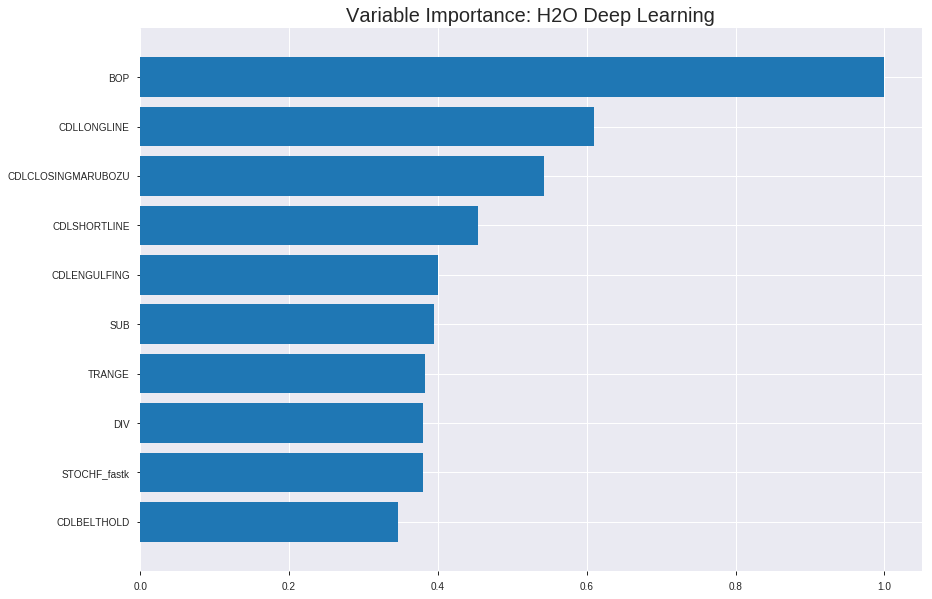

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_145609_model_6


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.1779707880503898
RMSE: 0.42186584129363897
LogLoss: 0.528270829640479
Mean Per-Class Error: 0.26819244056086156
AUC: 0.808415464336517
pr_auc: 0.8025276244515677
Gini: 0.616830928673034
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.32672650092346245: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      350  427   0.5495   (427.0/777.0)
1      62   698   0.0816   (62.0/760.0)
Total  412  1125  0.3182   (489.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.326727     0.740584  276
max f2                       0.232608     0.853234  312
max f0point5                 0.507329     0.742604  184
max accuracy                 0.507329     0.732596  184
max precision                0.999547     1         0
max recall                   0.0260892    1         389
max specificity              0.999547     1         0
max absolute_mcc             0.507329     0.468727  184
max min_per_class_accuracy   0.461183     0.720721  207
max mean_per_class_accuracy  0.507329     0.731808  184

Gains/Lift Table: Avg response rate: 49.45 %, avg score: 48.53 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.995721           2.02237   2.02237            1                0.998185   1                           0.998185            0.0210526       0.0210526                  102.237   102.237
    2        0.0201692                   0.984753           1.88754   1.95713            0.933333         0.990302   0.967742                    0.99437             0.0184211       0.0394737                  88.7544   95.7131
    3        0.0305791                   0.97783            1.89597   1.93631            0.9375           0.981931   0.957447                    0.990136            0.0197368       0.0592105                  89.597    93.631
    4        0.0403383                   0.959236           1.75272   1.89189            0.866667         0.968355   0.935484                    0.984866            0.0171053       0.0763158                  75.2719   89.1893
    5        0.0500976                   0.947728           1.75272   1.86478            0.866667         0.952924   0.922078                    0.978643            0.0171053       0.0934211                  75.2719   86.4781
    6        0.100195                    0.86623            1.91731   1.89105            0.948052         0.907733   0.935065                    0.943188            0.0960526       0.189474                   91.731    89.1046
    7        0.150293                    0.791628           1.83852   1.87354            0.909091         0.82804    0.926407                    0.904805            0.0921053       0.281579                   83.8517   87.3536
    8        0.20039                     0.716491           1.68093   1.82538            0.831169         0.750659   0.902597                    0.866269            0.0842105       0.365789                   68.093    82.5384
    9        0.299935                    0.618283           1.33503   1.66264            0.660131         0.670979   0.822126                    0.801455            0.132895        0.498684                   33.5028   66.2641
    10       0.40013                     0.526545           1.27383   1.56528            0.62987          0.567341   0.773984                    0.742831            0.127632        0.626316                   27.3829   56.528
    11       0.500325                    0.460127           0.971787  1.44643            0.480519         0.489507   0.715215                    0.6921              0.0973684       0.723684                   -2.82126  44.6427
    12       0.59987                     0.40865            0.779868  1.33582            0.385621         0.436062   0.660521                    0.649613            0.0776316       0.801316                   -22.0132  33.5816
    13       0.700065                    0.349579           0.892994  1.27244            0.441558         0.379295   0.629182                    0.610924            0.0894737       0.890789                   -10.7006  27.2438
    14       0.79961                     0.26317            0.634469  1.19302            0.313725         0.309694   0.58991                     0.573423            0.0631579       0.953947                   -36.5531  19.3016
    15       0.899805                    0.130287           0.354571  1.09965            0.175325         0.201221   0.543745                    0.531978            0.0355263       0.989474                   -64.5429  9.96537
    16       1                           0.000548702        0.105058  1                  0.0519481        0.0660629  0.49447                     0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.19950176265385117
RMSE: 0.4466562018531156
LogLoss: 0.580811900040347
Mean Per-Class Error: 0.2836637047163363
AUC: 0.7739804055593529
pr_auc: 0.7243903869109842
Gini: 0.5479608111187058
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.29393190041973194: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      95   136  0.5887   (136.0/231.0)
1      9    200  0.0431   (9.0/209.0)
Total  104  336  0.3295   (145.0/440.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.293932     0.733945  302
max f2                       0.287309     0.855932  309
max f0point5                 0.397904     0.690987  219
max accuracy                 0.397904     0.713636  219
max precision                0.980362     1         0
max recall                   0.198414     1         370
max specificity              0.980362     1         0
max absolute_mcc             0.397904     0.433752  219
max min_per_class_accuracy   0.424132     0.69697   198
max mean_per_class_accuracy  0.397904     0.716336  219

Gains/Lift Table: Avg response rate: 47.50 %, avg score: 44.26 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113636                   0.920871           2.10526    2.10526            1                0.945554  1                           0.945554            0.0239234       0.0239234                  110.526   110.526
    2        0.0204545                   0.877093           1.57895    1.87135            0.75             0.892101  0.888889                    0.921797            0.0143541       0.0382775                  57.8947   87.1345
    3        0.0318182                   0.835635           2.10526    1.95489            1                0.854827  0.928571                    0.897879            0.0239234       0.062201                   110.526   95.4887
    4        0.0409091                   0.815912           1.57895    1.87135            0.75             0.825369  0.888889                    0.881766            0.0143541       0.076555                   57.8947   87.1345
    5        0.05                        0.78283            1.05263    1.72249            0.5              0.799117  0.818182                    0.866739            0.00956938      0.0861244                  5.26316   72.2488
    6        0.1                         0.709732           1.72249    1.72249            0.818182         0.740862  0.818182                    0.8038              0.0861244       0.172249                   72.2488   72.2488
    7        0.15                        0.652989           1.62679    1.69059            0.772727         0.679396  0.80303                     0.762332            0.0813397       0.253589                   62.6794   69.059
    8        0.2                         0.583728           1.24402    1.57895            0.590909         0.61427   0.75                        0.725317            0.062201        0.315789                   24.4019   57.8947
    9        0.3                         0.525878           1.43541    1.5311             0.681818         0.556238  0.727273                    0.668957            0.143541        0.45933                    43.5407   53.11
    10       0.4                         0.481841           1.29187    1.47129            0.613636         0.504411  0.698864                    0.627821            0.129187        0.588517                   29.1866   47.1292
    11       0.5                         0.416293           1.24402    1.42584            0.590909         0.447066  0.677273                    0.59167             0.124402        0.712919                   24.4019   42.5837
    12       0.6                         0.379201           1.00478    1.35566            0.477273         0.39631   0.643939                    0.55911             0.100478        0.813397                   0.478469  35.5662
    13       0.7                         0.325371           0.861244   1.28503            0.409091         0.358084  0.61039                     0.530392            0.0861244       0.899522                   -13.8756  28.5031
    14       0.8                         0.275309           0.717703   1.21411            0.340909         0.299482  0.576705                    0.501528            0.0717703       0.971292                   -28.2297  21.4115
    15       0.9                         0.219516           0.191388   1.10048            0.0909091        0.248674  0.522727                    0.473433            0.0191388       0.990431                   -80.8612  10.0478
    16       1                           0.0636741          0.0956938  1                  0.0454545        0.16486   0.475                       0.


Scoring History: 


timestamp            duration           training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  -----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 15:07:02  0.000 sec                            0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 15:07:03  6 min 31.520 sec   320 obs/sec       0.319453  1             491        0.542058         1.0249              -0.17545       0.621877        0.576632           1.51678          0.459987                         0.712257           4.25997               -1.03432         0.562884          0.546477             1.26316            0.490909
    2019-08-28 15:07:26  6 min 54.300 sec   432 obs/sec       6.22121   20            9562       0.483624         0.659921            0.0643181      0.648125        0.614699           1.76957          0.419649                         0.555623           0.828985              -0.237961        0.602539          0.568105             1.26316            0.479545
    2019-08-28 15:07:48  7 min 16.580 sec   456 obs/sec       12.5237   40            19249      0.485574         0.663517            0.0567572      0.711381        0.694529           1.89597          0.370202                         0.51262            0.71934               -0.0537516       0.581039          0.554216             2.10526            0.472727
    2019-08-28 15:08:12  7 min 39.996 sec   469 obs/sec       19.3741   62            29778      0.48147          0.654629            0.0726328      0.664743        0.629163           1.64317          0.385166                         0.600244           0.992608              -0.444784        0.605367          0.57696              1.26316            0.459091
    2019-08-28 15:08:35  8 min  2.744 sec   469 obs/sec       25.6129   82            39367      0.46243          0.613486            0.144531       0.717183        0.71728            1.89597          0.405335                         0.539101           0.794297              -0.165434        0.656952          0.601446             1.26316            0.4
    2019-08-28 15:08:57  8 min 24.946 sec   474 obs/sec       32.1282   103           49381      0.458714         0.60517             0.158222       0.767772        0.761312           2.02237          0.331165                         0.501884           0.696824              -0.0100736       0.646047          0.670959             2.10526            0.447727
    2019-08-28 15:09:19  8 min 46.611 sec   481 obs/sec       38.6461   124           59399      0.44555          0.578207            0.205843       0.774058        0.765104           1.89597          0.312297                         0.459565           0.61214               0.153083         0.753868          0.712959             2.10526            0.290909
    2019-08-28 15:09:40  9 min  8.488 sec   485 obs/sec       45.1698   145           69426      0.442029         0.570621            0.218347       0.785886        0.781375           1.89597          0.333767                         0.485935           0.664006              0.0531           0.697156          0.66571              2.10526            0.454545
    2019-08-28 15

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  ---------------------
BOP                      1.0                    1.0                  0.008729057247186943
CDLLONGLINE              0.6093804240226746     0.6093804240226746   0.005319316606608979
CDLCLOSINGMARUBOZU       0.5423322319984436     0.5423322319984436   0.004734049100109085
CDLSHORTLINE             0.45398345589637756    0.45398345589637756  0.0039628475757952485
CDLENGULFING             0.3998849093914032     0.3998849093914032   0.003490618266363722
---                      ---                    ---                  ---
MIDPRICE_8               0.0830502137541771     0.0830502137541771   0.0007249500702513243
MA_14_5                  0.08268214762210846    0.08268214762210846  0.0007217371999137465
BBANDS_middleband_8_0_3  0.08240920305252075    0.08240920305252075  0.0007193546511405066
CDLHARAMICROSS           0.08132342249155045    0.08132342249155045  0.000709876810465914
CDLRISEFALL3METHODS      0.0657917931675911     0.0657917931675911   0.0005743003289549855


See the whole table with table.as_data_frame()


('accuracy', 0.7681818181818182)

('F1', 0.7792207792207793)

('auc', 0.8259388501163176)

('logloss', 0.5562386055977278)

('mean_per_class_error', 0.22407776669990032)

('rmse', 0.4329943880218928)

('mse', 0.18748414005845346)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


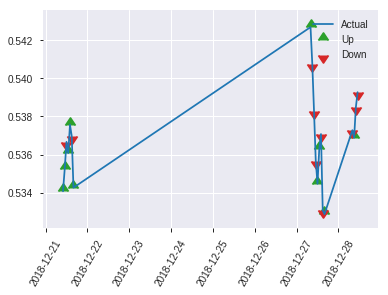


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.18748414005845346
RMSE: 0.4329943880218928
LogLoss: 0.5562386055977278
Mean Per-Class Error: 0.22407776669990032
AUC: 0.8259388501163176
pr_auc: 0.776126009876317
Gini: 0.6518777002326352
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34329960584845753: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      79   39   0.3305   (39.0/118.0)
1      12   90   0.1176   (12.0/102.0)
Total  91   129  0.2318   (51.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.3433       0.779221  128
max f2                       0.323864     0.846995  140
max f0point5                 0.445227     0.769231  84
max accuracy                 0.445227     0.768182  84
max precision                0.926191     1         0
max recall                   0.143858     1         208
max specificity              0.926191     1         0
max absolute_mcc             0.3433       0.558782  128
max min_per_class_accuracy   0.396969     0.737288  106
max mean_per_class_accuracy  0.3433       0.775922  128

Gains/Lift Table: Avg response rate: 46.36 %, avg score: 41.22 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.867041           2.15686   2.15686            1                0.889189  1                           0.889189            0.0294118       0.0294118                  115.686   115.686
    2        0.0227273                   0.850369           2.15686   2.15686            1                0.855919  1                           0.875881            0.0196078       0.0490196                  115.686   115.686
    3        0.0318182                   0.832019           2.15686   2.15686            1                0.84611   1                           0.867375            0.0196078       0.0686275                  115.686   115.686
    4        0.0409091                   0.797661           2.15686   2.15686            1                0.81886   1                           0.856594            0.0196078       0.0882353                  115.686   115.686
    5        0.05                        0.748242           1.07843   1.96078            0.5              0.789022  0.909091                    0.844308            0.00980392      0.0980392                  7.84314   96.0784
    6        0.1                         0.663998           1.56863   1.76471            0.727273         0.700659  0.818182                    0.772484            0.0784314       0.176471                   56.8627   76.4706
    7        0.15                        0.602725           1.96078   1.83007            0.909091         0.633327  0.848485                    0.726098            0.0980392       0.27451                    96.0784   83.0065
    8        0.2                         0.548804           1.56863   1.76471            0.727273         0.580316  0.818182                    0.689653            0.0784314       0.352941                   56.8627   76.4706
    9        0.3                         0.492935           1.76471   1.76471            0.818182         0.521524  0.818182                    0.63361             0.176471        0.529412                   76.4706   76.4706
    10       0.4                         0.441215           1.37255   1.66667            0.636364         0.468362  0.772727                    0.592298            0.137255        0.666667                   37.2549   66.6667
    11       0.5                         0.390186           0.882353  1.5098             0.409091         0.416229  0.7                         0.557084            0.0882353       0.754902                   -11.7647  50.9804
    12       0.6                         0.338143           1.27451   1.47059            0.590909         0.359587  0.681818                    0.524168            0.127451        0.882353                   27.451    47.0588
    13       0.7                         0.306573           0.294118  1.30252            0.136364         0.32061   0.603896                    0.495088            0.0294118       0.911765                   -70.5882  30.2521
    14       0.8                         0.260677           0.392157  1.18873            0.181818         0.28571   0.551136                    0.468916            0.0392157       0.95098                    -60.7843  18.8725
    15       0.9                         0.191821           0.196078  1.07843            0.0909091        0.230922  0.5                         0.442472            0.0196078       0.970588                   -80.3922  7.84314
    16       1                           0.0779083          0.294118  1                  0.136364         0.139851  0.463636                    0.41221          

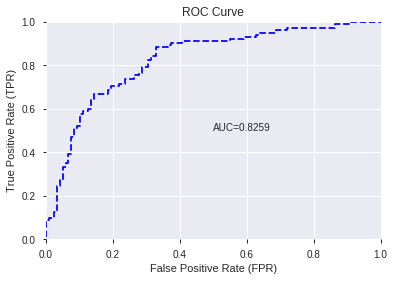

This function is available for GLM models only


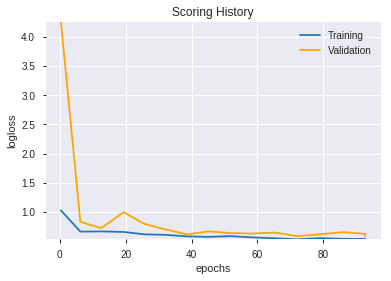

--2019-08-28 15:31:16--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.86.27
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.86.27|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_145609_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_145609_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_bf14',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [11]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_153125_model_9  0.805334  0.548410              0.235377  0.429593  0.184550
1  DeepLearning_grid_1_AutoML_20190828_153125_model_8  0.789382  0.573638              0.277999  0.443268  0.196487
2  DeepLearning_grid_1_AutoML_20190828_153125_model_6  0.777999  0.571641              0.347873  0.442341  0.195665
3  DeepLearning_grid_1_AutoML_20190828_153125_model_3  0.753988  0.687119              0.342057  0.464086  0.215375
4  DeepLearning_grid_1_AutoML_20190828_153125_model_5  0.740611  0.596677              0.360585  0.456339  0.208245
5               DeepLearning_1_AutoML_20190828_153125  0.738617  0.772824              0.369724  0.491271  0.241347
6  DeepLearning_grid_1_AutoML_20190828_153125_model_2  0.708956  0.844325              0.376869  0.508058  0.258123
7  DeepLearning_grid_1_AutoML_20190828_153125_model_7  0.657777  0.811725              0.393819  0.512940  0.263107
8  DeepLearning_grid_1_AutoML_20190828_153125_model_1  0.642323  1.028206              0.370389  0.546391  0.298543
9  DeepLearning_grid_1_AutoML_20190828_153125_model_4  0.641077  0.966744              0.379279  0.547815  0.300102

variable  relative_importance  scaled_importance  percentage
0     CDLCLOSINGMARUBOZU             1.000000           1.000000    0.041619
1                    BOP             0.962757           0.962757    0.040069
2            CDLLONGLINE             0.764832           0.764832    0.031832
3           CDLSHORTLINE             0.752994           0.752994    0.031339
4           CDLENGULFING             0.645801           0.645801    0.026878
5                 TRANGE             0.643636           0.643636    0.026788
6                    DIV             0.618725           0.618725    0.025751
7                    SUB             0.617736           0.617736    0.025710
8       CDLDRAGONFLYDOJI             0.582588           0.582588    0.024247
9              CDLTAKURI             0.566876           0.566876    0.023593
10                ULTOSC             0.545531           0.545531    0.022705
11             CORREL_20             0.532547           0.532547    0.022164
12             aroonup_8             0.511862           0.511862    0.021303
13         days_in_month             0.500485           0.500485    0.020830
14           CDLMARUBOZU             0.479038           0.479038    0.019937
15               weekday             0.469678           0.469678    0.019548
16              WILLR_30             0.464109           0.464109    0.019316
17                  hour             0.459843           0.459843    0.019138
18        STOCHRSI_fastd             0.459546           0.459546    0.019126
19          weekday_name             0.455240           0.455240    0.018947
20                  DX_8             0.447952           0.447952    0.018643
21            MINUS_DI_8             0.447259           0.447259    0.018615
22                Volume             0.441494           0.441494    0.018375
23             dayofweek             0.440497           0.440497    0.018333
24                 ADOSC             0.439032           0.439032    0.018272
25           MINUS_DI_14             0.430465           0.430465    0.017916
26  HT_PHASOR_quadrature             0.427001           0.427001    0.017771
27          STOCHF_fastk             0.422651           0.422651    0.017590
28           CDLBELTHOLD             0.421618           0.421618    0.017547
29                 DX_12             0.420265           0.420265    0.017491
30           MINUS_DI_12             0.419465           0.419465    0.017458
31              WILLR_14             0.405933           0.405933    0.016895
32                 DX_24             0.404637           0.404637    0.016841
33                 DX_20             0.403156           0.403156    0.016779
34           MINUS_DI_20             0.402649           0.402649    0.016758
35           MINUS_DI_24             0.390200           0.390200    0.016240
36                   OBV             0.388995           0.388995    0.016190
37              WILLR_12             0.388518           0.388518    0.016170
38            aroonup_30             0.388092           0.388092    0.016152
39                    AD             0.387962           0.387962    0.016147
40           STOCH_slowd             0.378291           0.378291    0.015744
41            aroonup_20             0.376508           0.376508    0.015670
42                 DX_14             0.376244           0.376244    0.015659
43        STOCHRSI_fastk             0.371894           0.371894    0.015478
44                 month             0.371515           0.371515    0.015462
45            weekofyear             0.366478           0.366478    0.015252
46              WILLR_24             0.364379           0.364379    0.015165
47               WILLR_8             0.360482           0.360482    0.015003
48                  week             0.358888           0.358888    0.014937
49             dayofyear             0.351054           0.351054    0.014611

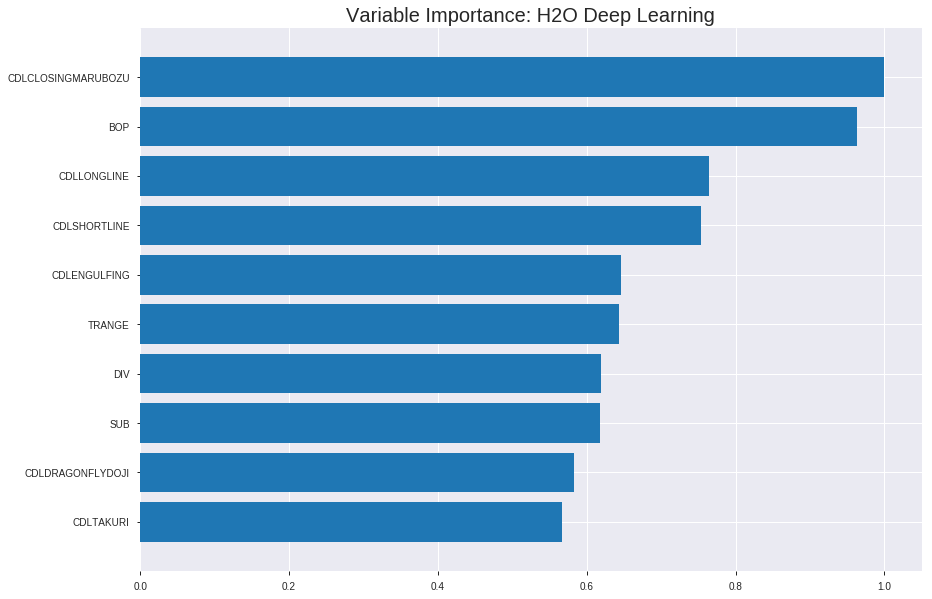

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_153125_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.1852318677616584
RMSE: 0.43038571974643675
LogLoss: 0.5477068428703983
Mean Per-Class Error: 0.29154135338345866
AUC: 0.7944167852062589
pr_auc: 0.790052854133711
Gini: 0.5888335704125178
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4393602306214388: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      373  404   0.5199   (404.0/777.0)
1      74   686   0.0974   (74.0/760.0)
Total  447  1090  0.311    (478.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.43936      0.741622  247
max f2                       0.233622     0.850403  322
max f0point5                 0.684744     0.721393  118
max accuracy                 0.528075     0.708523  195
max precision                0.959507     1         0
max recall                   0.0810163    1         389
max specificity              0.959507     1         0
max absolute_mcc             0.684744     0.422094  118
max min_per_class_accuracy   0.527396     0.702703  196
max mean_per_class_accuracy  0.528075     0.708459  195

Gains/Lift Table: Avg response rate: 49.45 %, avg score: 53.23 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.937598           2.02237   2.02237            1                0.944583  1                           0.944583            0.0210526       0.0210526                  102.237   102.237
    2        0.0201692                   0.930541           2.02237   2.02237            1                0.934999  1                           0.939946            0.0197368       0.0407895                  102.237   102.237
    3        0.0305791                   0.925082           1.64317   1.89328            0.8125           0.927428  0.93617                     0.935684            0.0171053       0.0578947                  64.3174   89.3281
    4        0.0403383                   0.920488           1.75272   1.85927            0.866667         0.922221  0.919355                    0.932427            0.0171053       0.075                      75.2719   85.9274
    5        0.0500976                   0.912897           1.88754   1.86478            0.933333         0.916127  0.922078                    0.929252            0.0184211       0.0934211                  88.7544   86.4781
    6        0.100195                    0.862218           1.81225   1.83852            0.896104         0.891904  0.909091                    0.910578            0.0907895       0.184211                   81.2252   83.8517
    7        0.150293                    0.823836           1.83852   1.83852            0.909091         0.840382  0.909091                    0.887179            0.0921053       0.276316                   83.8517   83.8517
    8        0.20039                     0.764956           1.57587   1.77286            0.779221         0.798472  0.876623                    0.865003            0.0789474       0.355263                   57.5871   77.2855
    9        0.299935                    0.633685           1.32181   1.62316            0.653595         0.705593  0.802603                    0.812097            0.131579        0.486842                   32.1809   62.3159
    10       0.40013                     0.554748           1.1819    1.51267            0.584416         0.593059  0.747967                    0.757248            0.118421        0.605263                   18.1904   51.2666
    11       0.500325                    0.527077           1.02432   1.41487            0.506494         0.536642  0.69961                     0.71307             0.102632        0.707895                   2.43165   41.4869
    12       0.59987                     0.514205           0.964921  1.3402             0.477124         0.521124  0.66269                     0.681217            0.0960526       0.803947                   -3.50791  34.0203
    13       0.700065                    0.450048           0.892994  1.2762             0.441558         0.495687  0.631041                    0.654664            0.0894737       0.893421                   -10.7006  27.6197
    14       0.79961                     0.302354           0.568378  1.18808            0.281046         0.372097  0.587469                    0.619487            0.0565789       0.95                       -43.1622  18.808
    15       0.899805                    0.183846           0.315174  1.09088            0.155844         0.234093  0.539407                    0.576572            0.0315789       0.981579                   -68.4826  9.08799
    16       1                           0.0362589          0.183852  1                  0.0909091        0.134653  0.49447                     0.532294          



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.1893183062477135
RMSE: 0.43510723534286755
LogLoss: 0.5557782162601247
Mean Per-Class Error: 0.2824105718842561
AUC: 0.7797489591747965
pr_auc: 0.741031327770428
Gini: 0.559497918349593
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3461133916122465: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      120  111  0.4805   (111.0/231.0)
1      22   187  0.1053   (22.0/209.0)
Total  142  298  0.3023   (133.0/440.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.346113     0.737673  265
max f2                       0.189945     0.860791  340
max f0point5                 0.540695     0.693069  161
max accuracy                 0.465157     0.711364  226
max precision                0.947572     1         0
max recall                   0.189945     1         340
max specificity              0.947572     1         0
max absolute_mcc             0.441903     0.446314  238
max min_per_class_accuracy   0.517254     0.684211  192
max mean_per_class_accuracy  0.441903     0.717589  238

Gains/Lift Table: Avg response rate: 47.50 %, avg score: 48.55 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113636                   0.937441           2.10526   2.10526            1                0.942431  1                           0.942431            0.0239234       0.0239234                  110.526   110.526
    2        0.0204545                   0.930651           1.57895   1.87135            0.75             0.933043  0.888889                    0.938259            0.0143541       0.0382775                  57.8947   87.1345
    3        0.0318182                   0.92764            2.10526   1.95489            1                0.929031  0.928571                    0.934963            0.0239234       0.062201                   110.526   95.4887
    4        0.0409091                   0.921403           2.10526   1.9883             1                0.92325   0.944444                    0.93236             0.0191388       0.0813397                  110.526   98.8304
    5        0.05                        0.917296           2.10526   2.00957            1                0.919707  0.954545                    0.93006             0.0191388       0.100478                   110.526   100.957
    6        0.1                         0.827322           1.43541   1.72249            0.681818         0.874759  0.818182                    0.902409            0.0717703       0.172249                   43.5407   72.2488
    7        0.15                        0.776073           1.91388   1.78628            0.909091         0.804874  0.848485                    0.869897            0.0956938       0.267943                   91.3876   78.6284
    8        0.2                         0.699496           1.14833   1.62679            0.545455         0.740539  0.772727                    0.837558            0.0574163       0.325359                   14.8325   62.6794
    9        0.3                         0.583397           1.43541   1.563              0.681818         0.632514  0.742424                    0.76921             0.143541        0.4689                     43.5407   56.2998
    10       0.4                         0.540326           1.33971   1.50718            0.636364         0.557936  0.715909                    0.716391            0.133971        0.602871                   33.9713   50.7177
    11       0.5                         0.512957           0.909091  1.38756            0.431818         0.525842  0.659091                    0.678282            0.0909091       0.69378                    -9.09091  38.756
    12       0.6                         0.449812           1.29187   1.37161            0.613636         0.491131  0.651515                    0.64709             0.129187        0.822967                   29.1866   37.1611
    13       0.7                         0.315634           0.717703  1.2782             0.340909         0.386767  0.607143                    0.609901            0.0717703       0.894737                   -28.2297  27.8195
    14       0.8                         0.241422           0.574163  1.19019            0.272727         0.274793  0.565341                    0.568012            0.0574163       0.952153                   -42.5837  19.0191
    15       0.9                         0.164595           0.478469  1.11111            0.227273         0.19662   0.527778                    0.526747            0.0478469       1                          -52.1531  11.1111
    16       1                           0.0395724          0         1                  0                0.113851  0.475                       0.485457          


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 15:37:16  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 15:37:17  2 min  8.004 sec  488 obs/sec       0.597918  1             919        0.503156         0.76995             -0.0127874     0.712409        0.687296           1.51678          0.363045                         0.488428           0.704771              0.0433607        0.725947          0.680283             2.10526            0.368182
    2019-08-28 15:37:27  2 min 17.911 sec  779 obs/sec       5.50943   9             8468       0.446761         0.583148            0.20152        0.770041        0.767428           1.89597          0.318803                         0.452723           0.588658              0.178111         0.777999          0.732825             2.10526            0.284091
    2019-08-28 15:37:37  2 min 27.272 sec  920 obs/sec       11.5745   19            17790      0.438308         0.562713            0.231451       0.778267        0.775174           2.02237          0.340273                         0.446502           0.579347              0.200544         0.764732          0.72227              2.10526            0.279545
    2019-08-28 15:37:46  2 min 36.407 sec  1021 obs/sec      18.3162   30            28152      0.437246         0.56351             0.23517        0.784471        0.781381           2.02237          0.314899                         0.443492           0.576234              0.211288         0.780287          0.737445             2.10526            0.281818
    2019-08-28 15:37:55  2 min 45.856 sec  1113 obs/sec      26.1535   43            40198      0.434126         0.557156            0.246047       0.790228        0.783959           2.02237          0.319453                         0.455012           0.601156              0.169781         0.747209          0.727564             2.10526            0.313636
    2019-08-28 15:38:05  2 min 55.507 sec  1187 obs/sec      34.6532   57            53262      0.430386         0.547707            0.258982       0.794417        0.790053           2.02237          0.310995                         0.435107           0.555778              0.240829         0.779749          0.741031             2.10526            0.302273
    2019-08-28 15:38:14  3 min  4.750 sec  1247 obs/sec      43.1978   71            66395      0.426222         0.540015            0.273251       0.800086        0.789964           1.89597          0.296031                         0.442526           0.571224              0.214719         0.769755          0.736878             2.10526            0.320455
    2019-08-28 15:38:15  3 min  5.673 sec  1246 obs/sec      43.1978   71            66395      0.430386         0.547707            0.258982       0.794417        0.790053           2.02237          0.310995                         0.435107           0.555778              0.240829         0.779749          0.741031             2.10526            0.302273

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
CDLCLOSINGMARUBOZU  1.0                    1.0                  0.04161915902813174
BOP                 0.9627569913864136     0.9627569913864136   0.04006913632995681
CDLLONGLINE         0.7648324370384216     0.7648324370384216   0.03183168282697563
CDLSHORTLINE        0.7529939413070679     0.7529939413070679   0.03133897459047856
CDLENGULFING        0.6458008885383606     0.6458008885383606   0.02687768988058681
---                 ---                    ---                  ---
weekofyear          0.3664776384830475     0.3664776384830475   0.015252491116280128
WILLR_24            0.36437949538230896    0.36437949538230896  0.015165168164906713
WILLR_8             0.36048242449760437    0.36048242449760437  0.01500297535201229
week                0.3588876724243164     0.3588876724243164   0.014936603111863676
dayofyear           0.35105425119400024    0.35105425119400024  0.014610582707944804


See the whole table with table.as_data_frame()


('accuracy', 0.7681818181818182)

('F1', 0.7411167512690356)

('auc', 0.805333998005982)

('logloss', 0.5484101891987313)

('mean_per_class_error', 0.2353772017281488)

('rmse', 0.4295930872477645)

('mse', 0.18455022061106544)

deeplearning prediction progress: |███████████████████████████████████████| 100%


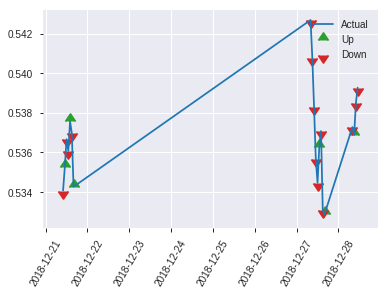


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.18455022061106544
RMSE: 0.4295930872477645
LogLoss: 0.5484101891987313
Mean Per-Class Error: 0.2353772017281488
AUC: 0.805333998005982
pr_auc: 0.7784469401094586
Gini: 0.6106679960119641
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5225718315218242: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      96   22   0.1864   (22.0/118.0)
1      29   73   0.2843   (29.0/102.0)
Total  125  95   0.2318   (51.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.522572     0.741117  94
max f2                       0.231542     0.827645  177
max f0point5                 0.561392     0.762712  62
max accuracy                 0.523779     0.768182  92
max precision                0.944926     1         0
max recall                   0.103277     1         208
max specificity              0.944926     1         0
max absolute_mcc             0.523779     0.532921  92
max min_per_class_accuracy   0.518227     0.735294  101
max mean_per_class_accuracy  0.522572     0.764623  94

Gains/Lift Table: Avg response rate: 46.36 %, avg score: 47.63 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.92614            2.15686   2.15686            1                0.933327  1                           0.933327            0.0294118       0.0294118                  115.686   115.686
    2        0.0227273                   0.920689           1.07843   1.72549            0.5              0.923973  0.8                         0.929586            0.00980392      0.0392157                  7.84314   72.549
    3        0.0318182                   0.915588           2.15686   1.84874            1                0.917278  0.857143                    0.926069            0.0196078       0.0588235                  115.686   84.8739
    4        0.0409091                   0.911693           2.15686   1.91721            1                0.913515  0.888889                    0.923279            0.0196078       0.0784314                  115.686   91.7211
    5        0.05                        0.896928           2.15686   1.96078            1                0.907436  0.909091                    0.920399            0.0196078       0.0980392                  115.686   96.0784
    6        0.1                         0.801231           1.96078   1.96078            0.909091         0.859872  0.909091                    0.890135            0.0980392       0.196078                   96.0784   96.0784
    7        0.15                        0.735863           1.76471   1.89542            0.818182         0.778772  0.878788                    0.853014            0.0882353       0.284314                   76.4706   89.5425
    8        0.2                         0.649808           1.76471   1.86275            0.818182         0.681268  0.863636                    0.810078            0.0882353       0.372549                   76.4706   86.2745
    9        0.3                         0.548698           1.56863   1.76471            0.727273         0.607266  0.818182                    0.742474            0.156863        0.529412                   56.8627   76.4706
    10       0.4                         0.526459           1.37255   1.66667            0.636364         0.535444  0.772727                    0.690716            0.137255        0.666667                   37.2549   66.6667
    11       0.5                         0.506682           0.686275  1.47059            0.318182         0.518881  0.681818                    0.656349            0.0686275       0.735294                   -31.3725  47.0588
    12       0.6                         0.448435           0.686275  1.33987            0.318182         0.483333  0.621212                    0.627513            0.0686275       0.803922                   -31.3725  33.9869
    13       0.7                         0.337685           0.784314  1.2605             0.363636         0.400489  0.584416                    0.595081            0.0784314       0.882353                   -21.5686  26.0504
    14       0.8                         0.239147           0.588235  1.17647            0.272727         0.288021  0.545455                    0.556699            0.0588235       0.941176                   -41.1765  17.6471
    15       0.9                         0.174483           0.294118  1.07843            0.136364         0.201588  0.5                         0.517242            0.0294118       0.970588                   -70.5882  7.84314
    16       1                           0.027344           0.294118  1                  0.136364         0.107447  0.463636                    0.476263          

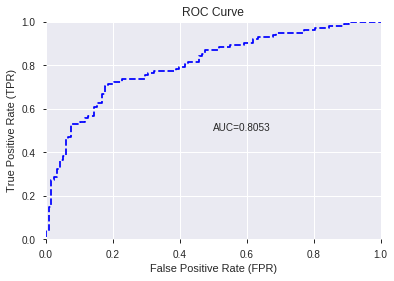

This function is available for GLM models only


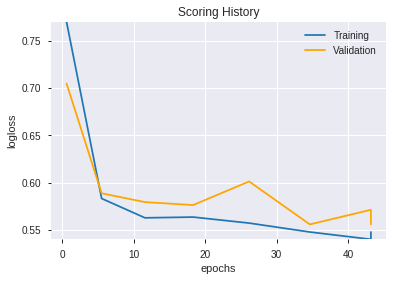

--2019-08-28 15:38:22--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.129.243
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.129.243|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_153125_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_153125_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_bf14',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLCLOSINGMARUBOZU',
 'BOP',
 'CDLLONGLINE',
 'CDLSHORTLINE',
 'CDLENGULFING',
 'TRANGE',
 'DIV',
 'SUB',
 'CDLDRAGONFLYDOJI',
 'CDLTAKURI',
 'ULTOSC',
 'CORREL_20',
 'aroonup_8',
 'days_in_month',
 'CDLMARUBOZU',
 'weekday',
 'WILLR_30',
 'hour',
 'STOCHRSI_fastd',
 'weekday_name',
 'DX_8',
 'MINUS_DI_8',
 'Volume',
 'dayofweek',
 'ADOSC',
 'MINUS_DI_14',
 'HT_PHASOR_quadrature',
 'STOCHF_fastk',
 'CDLBELTHOLD',
 'DX_12',
 'MINUS_DI_12',
 'WILLR_14',
 'DX_24',
 'DX_20',
 'MINUS_DI_20',
 'MINUS_DI_24',
 'OBV',
 'WILLR_12',
 'aroonup_30',
 'AD',
 'STOCH_slowd',
 'aroonup_20',
 'DX_14',
 'STOCHRSI_fastk',
 'month',
 'weekofyear',
 'WILLR_24',
 'WILLR_8',
 'week',
 'dayofyear']

In [12]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190828_153835_model_1  0.806414  0.546721              0.242522  0.428418  0.183542

variable  relative_importance  scaled_importance  percentage
0                    BOP             0.482114           1.000000    0.120825
1     CDLCLOSINGMARUBOZU             0.228718           0.474406    0.057320
2                 ULTOSC             0.192937           0.400190    0.048353
3                   hour             0.144861           0.300470    0.036304
4              aroonup_8             0.137449           0.285097    0.034447
5                 Volume             0.133283           0.276454    0.033403
6            STOCH_slowd             0.129372           0.268342    0.032422
7            CDLLONGLINE             0.122095           0.253250    0.030599
8           STOCHF_fastk             0.120714           0.250386    0.030253
9                    SUB             0.117815           0.244372    0.029526
10          CDLENGULFING             0.117201           0.243098    0.029372
11              WILLR_30             0.115235           0.239020    0.028880
12        STOCHRSI_fastd             0.115052           0.238640    0.028834
13                   DIV             0.107572           0.223125    0.026959
14             CORREL_20             0.100837           0.209156    0.025271
15            MINUS_DI_8             0.098710           0.204744    0.024738
16            aroonup_30             0.095142           0.197343    0.023844
17      CDLDRAGONFLYDOJI             0.094001           0.194977    0.023558
18             CDLTAKURI             0.093447           0.193827    0.023419
19                  DX_8             0.082370           0.170852    0.020643
20              WILLR_24             0.081536           0.169121    0.020434
21                 ADOSC             0.077681           0.161125    0.019468
22              WILLR_12             0.075641           0.156894    0.018957
23          CDLSHORTLINE             0.074847           0.155247    0.018758
24          weekday_name             0.067218           0.139423    0.016846
25           MINUS_DI_12             0.065549           0.135961    0.016427
26           MINUS_DI_24             0.059915           0.124276    0.015016
27           MINUS_DI_14             0.059457           0.123325    0.014901
28                 DX_12             0.058248           0.120817    0.014598
29           MINUS_DI_20             0.056582           0.117363    0.014180
30  HT_PHASOR_quadrature             0.054128           0.112273    0.013565
31              WILLR_14             0.052960           0.109850    0.013273
32           CDLBELTHOLD             0.050048           0.103810    0.012543
33                 DX_14             0.036677           0.076076    0.009192
34                 DX_20             0.031929           0.066227    0.008002
35                TRANGE             0.031050           0.064403    0.007782
36                   OBV             0.027861           0.057788    0.006982
37         days_in_month             0.023917           0.049608    0.005994
38            aroonup_20             0.021257           0.044091    0.005327
39                 DX_24             0.020561           0.042648    0.005153
40                    AD             0.017540           0.036382    0.004396
41             dayofyear             0.016429           0.034076    0.004117
42                  week             0.016415           0.034047    0.004114
43            weekofyear             0.016360           0.033934    0.004100
44               WILLR_8             0.016327           0.033864    0.004092
45           CDLMARUBOZU             0.015220           0.031568    0.003814
46        STOCHRSI_fastk             0.009269           0.019226    0.002323
47             dayofweek             0.009229           0.019142    0.002313
48               weekday             0.009213           0.019109    0.002309
49                 month             0.008204           0.017016    0.002056

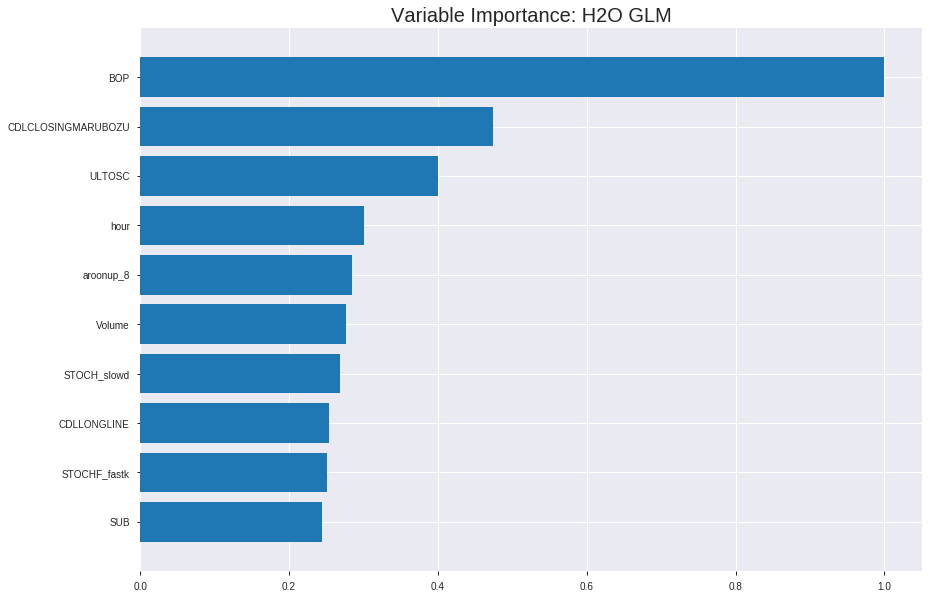

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_153835_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.19279409679446954
RMSE: 0.43908324585944924
LogLoss: 0.5663622706569404
Null degrees of freedom: 1536
Residual degrees of freedom: 1486
Null deviance: 2130.546400580142
Residual deviance: 1740.9976199994353
AIC: 1842.9976199994353
AUC: 0.776182855788119
pr_auc: 0.7700866853775206
Gini: 0.5523657115762379
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39534020502672135: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      403  374   0.4813   (374.0/777.0)
1      109  651   0.1434   (109.0/760.0)
Total  512  1025  0.3142   (483.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.39534      0.729412  255
max f2                       0.238668     0.845555  325
max f0point5                 0.585536     0.702603  152
max accuracy                 0.498586     0.696812  196
max precision                0.937283     1         0
max recall                   0.0579143    1         392
max specificity              0.937283     1         0
max absolute_mcc             0.418771     0.398309  242
max min_per_class_accuracy   0.495791     0.69112   198
max mean_per_class_accuracy  0.498586     0.696732  196

Gains/Lift Table: Avg response rate: 49.45 %, avg score: 49.45 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.90969            1.89597   1.89597            0.9375           0.925009  0.9375                      0.925009            0.0197368       0.0197368                  89.597    89.597
    2        0.0201692                   0.884648           1.88754   1.89189            0.933333         0.896809  0.935484                    0.911364            0.0184211       0.0381579                  88.7544   89.1893
    3        0.0305791                   0.868314           1.89597   1.89328            0.9375           0.878381  0.93617                     0.900136            0.0197368       0.0578947                  89.597    89.3281
    4        0.0403383                   0.855309           2.02237   1.92451            1                0.861568  0.951613                    0.890805            0.0197368       0.0776316                  102.237   92.4512
    5        0.0500976                   0.84148            2.02237   1.94357            1                0.848786  0.961039                    0.882619            0.0197368       0.0973684                  102.237   94.3575
    6        0.100195                    0.783101           1.70719   1.82538            0.844156         0.814225  0.902597                    0.848422            0.0855263       0.182895                   70.7194   82.5384
    7        0.150293                    0.738533           1.68093   1.77723            0.831169         0.760154  0.878788                    0.819               0.0842105       0.267105                   68.093    77.7233
    8        0.20039                     0.699378           1.60214   1.73346            0.792208         0.717803  0.857143                    0.7937              0.0802632       0.347368                   60.2136   73.3459
    9        0.299935                    0.628799           1.21606   1.56174            0.601307         0.662928  0.772234                    0.750299            0.121053        0.468421                   21.6065   56.1742
    10       0.40013                     0.560957           1.1819    1.46663            0.584416         0.594549  0.725203                    0.711298            0.118421        0.586842                   18.1904   46.6628
    11       0.500325                    0.493309           1.07685   1.38857            0.532468         0.528579  0.686606                    0.674707            0.107895        0.694737                   7.68455   38.857
    12       0.59987                     0.43507            1.00458   1.32485            0.496732         0.465081  0.655098                    0.639921            0.1             0.794737                   0.457516  32.4849
    13       0.700065                    0.369327           0.801068  1.24988            0.396104         0.402955  0.61803                     0.606006            0.0802632       0.875                      -19.8932  24.9884
    14       0.79961                     0.297046           0.700559  1.1815             0.346405         0.331941  0.584215                    0.571887            0.0697368       0.944737                   -29.9441  18.1498
    15       0.899805                    0.19054            0.328307  1.08649            0.162338         0.246319  0.537238                    0.535634            0.0328947       0.977632                   -67.1693  8.64929
    16       1                           0.017074           0.223248  1                  0.11039          0.124792  0.49447                     0.49447            



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.19409851523078953
RMSE: 0.4405661303718087
LogLoss: 0.5630233788285599
Null degrees of freedom: 439
Residual degrees of freedom: 389
Null deviance: 609.536667332913
Residual deviance: 495.46057336913265
AIC: 597.4605733691326
AUC: 0.776818078253485
pr_auc: 0.7200443947816115
Gini: 0.5536361565069701
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3102758728147532: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      123  108  0.4675   (108.0/231.0)
1      20   189  0.0957   (20.0/209.0)
Total  143  297  0.2909   (128.0/440.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.310276     0.747036  269
max f2                       0.178902     0.856788  338
max f0point5                 0.451669     0.68999   183
max accuracy                 0.333676     0.709091  254
max precision                0.906045     1         0
max recall                   0.146423     1         350
max specificity              0.906045     1         0
max absolute_mcc             0.310276     0.465682  269
max min_per_class_accuracy   0.430137     0.703349  192
max mean_per_class_accuracy  0.310276     0.718387  269

Gains/Lift Table: Avg response rate: 47.50 %, avg score: 42.93 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113636                   0.876943           1.68421   1.68421            0.8              0.88901    0.8                         0.88901             0.0191388       0.0191388                  68.4211   68.4211
    2        0.0204545                   0.865255           1.57895   1.63743            0.75             0.872254   0.777778                    0.881563            0.0143541       0.0334928                  57.8947   63.7427
    3        0.0318182                   0.860486           2.10526   1.80451            1                0.863749   0.857143                    0.875201            0.0239234       0.0574163                  110.526   80.4511
    4        0.0409091                   0.851889           2.10526   1.87135            1                0.856317   0.888889                    0.871005            0.0191388       0.076555                   110.526   87.1345
    5        0.05                        0.832129           2.10526   1.91388            1                0.839152   0.909091                    0.865213            0.0191388       0.0956938                  110.526   91.3876
    6        0.1                         0.738962           1.43541   1.67464            0.681818         0.772514   0.795455                    0.818863            0.0717703       0.167464                   43.5407   67.4641
    7        0.15                        0.680025           1.62679   1.65869            0.772727         0.710386   0.787879                    0.782704            0.0813397       0.248804                   62.6794   65.8692
    8        0.2                         0.629823           1.62679   1.65072            0.772727         0.658271   0.784091                    0.751596            0.0813397       0.330144                   62.6794   65.0718
    9        0.3                         0.558754           1.19617   1.4992             0.568182         0.593454   0.712121                    0.698882            0.119617        0.449761                   19.6172   49.9203
    10       0.4                         0.490393           1.29187   1.44737            0.613636         0.526211   0.6875                      0.655714            0.129187        0.578947                   29.1866   44.7368
    11       0.5                         0.417424           1.33971   1.42584            0.636364         0.458794   0.677273                    0.61633             0.133971        0.712919                   33.9713   42.5837
    12       0.6                         0.358373           1.10048   1.37161            0.522727         0.388794   0.651515                    0.578408            0.110048        0.822967                   10.0478   37.1611
    13       0.7                         0.289526           0.909091  1.30554            0.431818         0.326421   0.62013                     0.542409            0.0909091       0.913876                   -9.09091  30.5537
    14       0.8                         0.213123           0.478469  1.20215            0.227273         0.24928    0.571023                    0.505768            0.0478469       0.961722                   -52.1531  20.2153
    15       0.9                         0.128201           0.382775  1.11111            0.181818         0.171091   0.527778                    0.468582            0.0382775       1                          -61.7225  11.1111
    16       1                           0.0197455          0         1                  0                0.0754126  0.475                      


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-28 15:38:35  0.000 sec   2            20        51            1.36718           1.36373
    2019-08-28 15:38:35  0.020 sec   4            12        51            1.35741           1.35261
    2019-08-28 15:38:36  0.044 sec   6            7.8       51            1.34378           1.33705
    2019-08-28 15:38:36  0.058 sec   8            4.8       51            1.32582           1.31649
    2019-08-28 15:38:36  0.071 sec   10           3         51            1.30367           1.29108
    2019-08-28 15:38:36  0.086 sec   12           1.9       51            1.2782            1.26192
    2019-08-28 15:38:36  0.102 sec   14           1.2       51            1.2512            1.23128
    2019-08-28 15:38:36  0.120 sec   16           0.72      51            1.22471           1.2019
    2019-08-28 15:38:36  0.135 sec   18           0.45      51            1.20059           1.17634
    2019-08-28 15:38:36  0.150 sec   20           0.28      51            1.17999           1.15618
    2019-08-28 15:38:36  0.163 sec   22           0.17      51            1.16327           1.14181
    2019-08-28 15:38:36  0.180 sec   24           0.11      51            1.15017           1.13271
    2019-08-28 15:38:36  0.194 sec   26           0.066     51            1.14019           1.12787
    2019-08-28 15:38:36  0.208 sec   28           0.041     51            1.13272           1.12605
    2019-08-28 15:38:36  0.220 sec   30           0.026     51            1.12719           1.12607
    2019-08-28 15:38:36  0.233 sec   32           0.016     51            1.12312           1.12714
    2019-08-28 15:38:36  0.248 sec   34           0.0098    51            1.1202            1.12863
    2019-08-28 15:38:36  0.262 sec   36           0.0061    51            1.11813           1.13027
    2019-08-28 15:38:36  0.275 sec   38           0.0038    51            1.11671           1.13183

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.759090909090909)

('F1', 0.7389162561576355)

('auc', 0.8064140910601528)

('logloss', 0.5467212862030394)

('mean_per_class_error', 0.24252243270189422)

('rmse', 0.42841781716337146)

('mse', 0.18354182606302796)

glm prediction progress: |████████████████████████████████████████████████| 100%


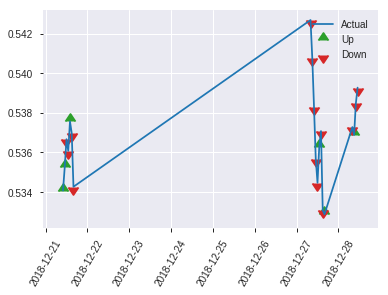


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.18354182606302796
RMSE: 0.42841781716337146
LogLoss: 0.5467212862030394
Null degrees of freedom: 219
Residual degrees of freedom: 169
Null deviance: 304.6577240810208
Residual deviance: 240.55736592933732
AIC: 342.5573659293373
AUC: 0.8064140910601528
pr_auc: 0.7607105986392874
Gini: 0.6128281821203057
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42776270904026004: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      92   26   0.2203   (26.0/118.0)
1      27   75   0.2647   (27.0/102.0)
Total  119  101  0.2409   (53.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.427763     0.738916  100
max f2                       0.235683     0.831874  162
max f0point5                 0.481111     0.755814  81
max accuracy                 0.450676     0.759091  90
max precision                0.887481     1         0
max recall                   0.0964894    1         205
max specificity              0.887481     1         0
max absolute_mcc             0.427763     0.515319  100
max min_per_class_accuracy   0.406177     0.745098  103
max mean_per_class_accuracy  0.427763     0.757478  100

Gains/Lift Table: Avg response rate: 46.36 %, avg score: 40.58 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.865894           2.15686   2.15686            1                0.882485   1                           0.882485            0.0294118       0.0294118                  115.686   115.686
    2        0.0227273                   0.827459           1.07843   1.72549            0.5              0.833654   0.8                         0.862952            0.00980392      0.0392157                  7.84314   72.549
    3        0.0318182                   0.81686            2.15686   1.84874            1                0.818799   0.857143                    0.850337            0.0196078       0.0588235                  115.686   84.8739
    4        0.0409091                   0.806543           2.15686   1.91721            1                0.813074   0.888889                    0.842056            0.0196078       0.0784314                  115.686   91.7211
    5        0.05                        0.785808           1.07843   1.76471            0.5              0.801777   0.818182                    0.834733            0.00980392      0.0882353                  7.84314   76.4706
    6        0.1                         0.733819           1.96078   1.86275            0.909091         0.754217   0.863636                    0.794475            0.0980392       0.186275                   96.0784   86.2745
    7        0.15                        0.653064           1.96078   1.89542            0.909091         0.68973    0.878788                    0.75956             0.0980392       0.284314                   96.0784   89.5425
    8        0.2                         0.626305           1.76471   1.86275            0.818182         0.640475   0.863636                    0.729789            0.0882353       0.372549                   76.4706   86.2745
    9        0.3                         0.545642           1.56863   1.76471            0.727273         0.589008   0.818182                    0.682862            0.156863        0.529412                   56.8627   76.4706
    10       0.4                         0.453688           1.27451   1.64216            0.590909         0.501719   0.761364                    0.637576            0.127451        0.656863                   27.451    64.2157
    11       0.5                         0.366675           0.980392  1.5098             0.454545         0.42101    0.7                         0.594263            0.0980392       0.754902                   -1.96078  50.9804
    12       0.6                         0.314475           0.490196  1.33987            0.227273         0.340762   0.621212                    0.552013            0.0490196       0.803922                   -50.9804  33.9869
    13       0.7                         0.268349           0.882353  1.27451            0.409091         0.291325   0.590909                    0.514772            0.0882353       0.892157                   -11.7647  27.451
    14       0.8                         0.198421           0.490196  1.17647            0.227273         0.229821   0.545455                    0.479153            0.0490196       0.941176                   -50.9804  17.6471
    15       0.9                         0.121311           0.392157  1.08932            0.181818         0.15325    0.505051                    0.442941            0.0392157       0.980392                   -60.7843  8.93246
    16       1                           0.0129919          0.196078  1                  0.0909091        0.0713909  0.463636                    0

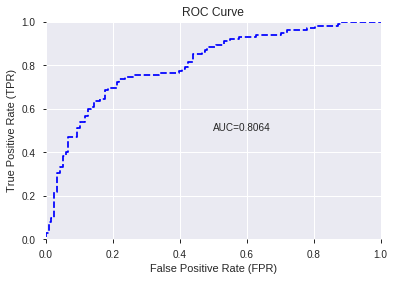

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


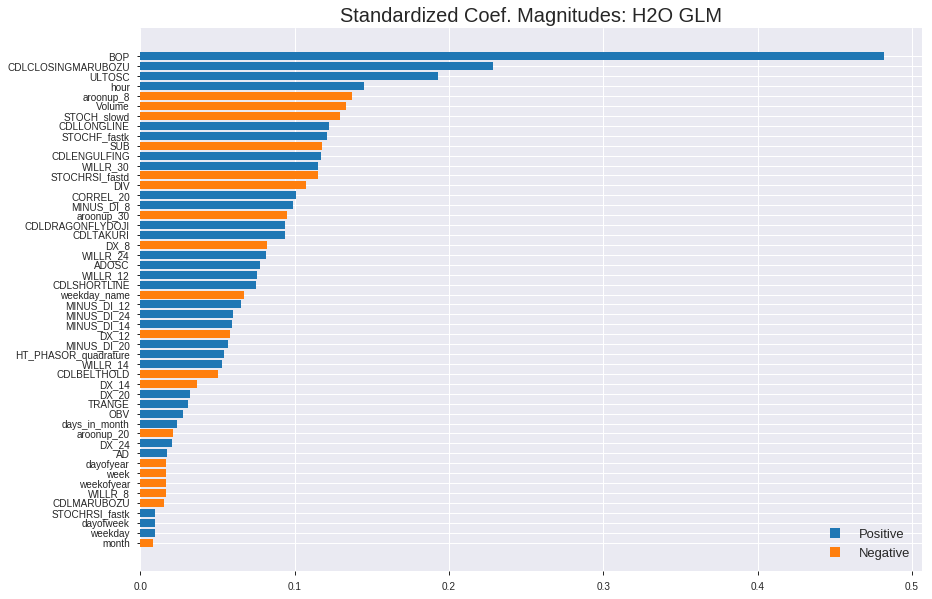

'log_likelihood'
--2019-08-28 15:38:42--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.37.228
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.37.228|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_153835_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_153835_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_bf14',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['BOP',
 'CDLCLOSINGMARUBOZU',
 'ULTOSC',
 'hour',
 'aroonup_8',
 'Volume',
 'STOCH_slowd',
 'CDLLONGLINE',
 'STOCHF_fastk',
 'SUB',
 'CDLENGULFING',
 'WILLR_30',
 'STOCHRSI_fastd',
 'DIV',
 'CORREL_20',
 'MINUS_DI_8',
 'aroonup_30',
 'CDLDRAGONFLYDOJI',
 'CDLTAKURI',
 'DX_8',
 'WILLR_24',
 'ADOSC',
 'WILLR_12',
 'CDLSHORTLINE',
 'weekday_name',
 'MINUS_DI_12',
 'MINUS_DI_24',
 'MINUS_DI_14',
 'DX_12',
 'MINUS_DI_20',
 'HT_PHASOR_quadrature',
 'WILLR_14',
 'CDLBELTHOLD',
 'DX_14',
 'DX_20',
 'TRANGE',
 'OBV',
 'days_in_month',
 'aroonup_20',
 'DX_24',
 'AD',
 'dayofyear',
 'week',
 'weekofyear',
 'WILLR_8',
 'CDLMARUBOZU',
 'STOCHRSI_fastk',
 'dayofweek',
 'weekday',
 'month']

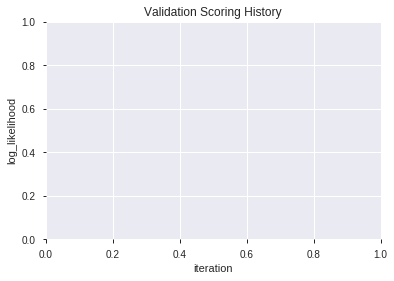

In [13]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190828_153853_model_4  0.781738  0.564504              0.259721  0.435780  0.189904
1  XGBoost_grid_1_AutoML_20190828_153853_model_3  0.777750  0.565280              0.314639  0.438045  0.191884
2  XGBoost_grid_1_AutoML_20190828_153853_model_2  0.766783  0.587721              0.312147  0.447995  0.200699
3               XGBoost_2_AutoML_20190828_153853  0.763626  0.576873              0.301429  0.443745  0.196909
4  XGBoost_grid_1_AutoML_20190828_153853_model_1  0.761715  0.583849              0.340063  0.445947  0.198869
5               XGBoost_3_AutoML_20190828_153853  0.750415  0.590234              0.338900  0.450579  0.203022
6               XGBoost_1_AutoML_20190828_153853  0.747341  0.592311              0.294699  0.450511  0.202960
7  XGBoost_grid_1_AutoML_20190828_153853_model_6  0.745347  0.594410              0.305417  0.452495  0.204752
8  XGBoost_grid_1_AutoML_20190828_153853_model_7  0.744849  0.590940              0.359920  0.451559  0.203906
9  XGBoost_grid_1_AutoML_20190828_153853_model_5  0.706630  0.627328              0.366152  0.469065  0.220022

variable  relative_importance  scaled_importance  percentage
0                    BOP          1909.725220           1.000000    0.421706
1                    DIV           305.011963           0.159715    0.067353
2                 TRANGE           275.357330           0.144187    0.060804
3           STOCHF_fastk           241.269104           0.126337    0.053277
4              CORREL_20           132.706726           0.069490    0.029304
5                   hour           130.214050           0.068185    0.028754
6                  ADOSC           117.418610           0.061485    0.025928
7                 ULTOSC           113.121651           0.059235    0.024980
8                    SUB           110.186020           0.057697    0.024331
9              aroonup_8           108.479912           0.056804    0.023955
10                  DX_8            91.229546           0.047771    0.020145
11            MINUS_DI_8            88.622147           0.046406    0.019570
12                 DX_24            75.699791           0.039639    0.016716
13                Volume            72.338120           0.037879    0.015974
14        STOCHRSI_fastd            60.751888           0.031812    0.013415
15                   OBV            60.602135           0.031733    0.013382
16  HT_PHASOR_quadrature            53.904652           0.028226    0.011903
17           MINUS_DI_20            53.897190           0.028222    0.011902
18           STOCH_slowd            52.356987           0.027416    0.011561
19               WILLR_8            46.225163           0.024205    0.010207
20              WILLR_12            43.826927           0.022949    0.009678
21                 DX_12            42.442520           0.022224    0.009372
22            aroonup_20            37.939716           0.019867    0.008378
23           MINUS_DI_14            32.538593           0.017038    0.007185
24        STOCHRSI_fastk            30.352253           0.015894    0.006702
25              WILLR_24            30.156078           0.015791    0.006659
26                 DX_20            28.997456           0.015184    0.006403
27           MINUS_DI_24            26.194553           0.013716    0.005784
28           MINUS_DI_12            25.853840           0.013538    0.005709
29              WILLR_30            23.820824           0.012473    0.005260
30             dayofyear            22.578396           0.011823    0.004986
31             dayofweek            21.398510           0.011205    0.004725
32            aroonup_30            19.125309           0.010015    0.004223
33                    AD            13.837915           0.007246    0.003056
34          weekday_name            10.454755           0.005474    0.002309
35              WILLR_14            10.096214           0.005287    0.002229
36         days_in_month             6.386635           0.003344    0.001410
37                  week             3.456020           0.001810    0.000763

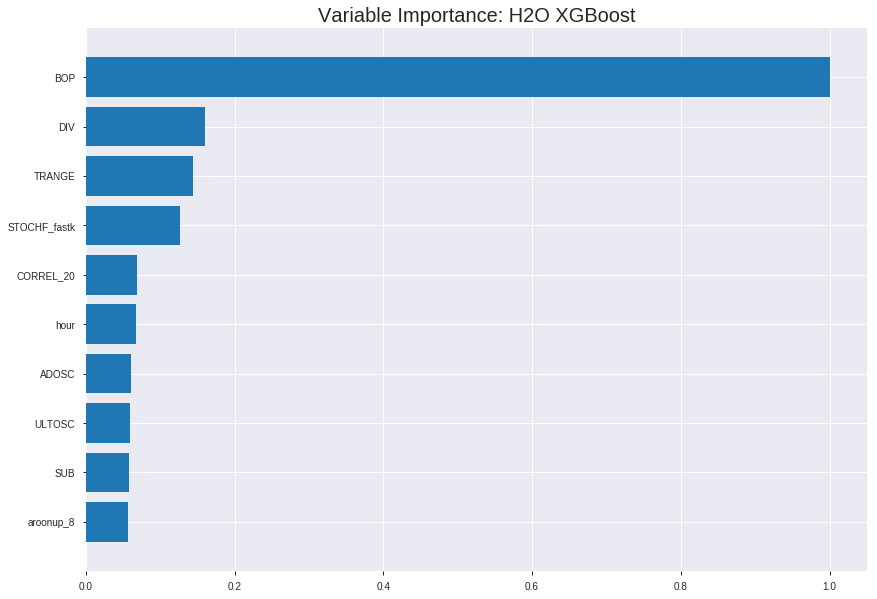

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190828_153853_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.17591460723537303
RMSE: 0.4194217534122104
LogLoss: 0.5299191038772241
Mean Per-Class Error: 0.24875364085890395
AUC: 0.8245148343832555
pr_auc: 0.8213114042595387
Gini: 0.6490296687665109
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.33762548863887787: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      368  409   0.5264   (409.0/777.0)
1      60   700   0.0789   (60.0/760.0)
Total  428  1109  0.3051   (469.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.337625     0.749064  280
max f2                       0.285188     0.85574   311
max f0point5                 0.603089     0.758808  142
max accuracy                 0.519957     0.751464  186
max precision                0.892956     1         0
max recall                   0.158757     1         371
max specificity              0.892956     1         0
max absolute_mcc             0.519957     0.502969  186
max min_per_class_accuracy   0.503064     0.746461  196
max mean_per_class_accuracy  0.519957     0.751246  186

Gains/Lift Table: Avg response rate: 49.45 %, avg score: 49.55 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.860458           2.02237    2.02237            1                0.872122  1                           0.872122            0.0210526       0.0210526                  102.237   102.237
    2        0.0201692                   0.845084           2.02237    2.02237            1                0.85208   1                           0.862424            0.0197368       0.0407895                  102.237   102.237
    3        0.0305791                   0.831048           2.02237    2.02237            1                0.836576  1                           0.853625            0.0210526       0.0618421                  102.237   102.237
    4        0.0403383                   0.823093           1.88754    1.98975            0.933333         0.826819  0.983871                    0.84714             0.0184211       0.0802632                  88.7544   98.975
    5        0.0500976                   0.81587            2.02237    1.9961             1                0.820129  0.987013                    0.841878            0.0197368       0.1                        102.237   99.6104
    6        0.100195                    0.77725            1.73346    1.86478            0.857143         0.794401  0.922078                    0.81814             0.0868421       0.186842                   73.3459   86.4781
    7        0.150293                    0.745054           1.81225    1.84727            0.896104         0.762848  0.91342                     0.799709            0.0907895       0.277632                   81.2252   84.7272
    8        0.20039                     0.71578            1.68093    1.80569            0.831169         0.73011   0.892857                    0.782309            0.0842105       0.361842                   68.093    80.5686
    9        0.299935                    0.63896            1.5333     1.71528            0.75817          0.678392  0.848156                    0.74782             0.152632        0.514474                   53.3299   71.5284
    10       0.40013                     0.575615           1.2213     1.59159            0.603896         0.606258  0.786992                    0.712372            0.122368        0.636842                   22.13     59.1588
    11       0.500325                    0.499513           1.11624    1.49639            0.551948         0.539303  0.739922                    0.677713            0.111842        0.748684                   11.6242   49.6395
    12       0.59987                     0.422667           0.740213   1.37091            0.366013         0.460625  0.677874                    0.641689            0.0736842       0.822368                   -25.9787  37.0911
    13       0.700065                    0.355701           0.801068   1.28935            0.396104         0.386406  0.637546                    0.605152            0.0802632       0.902632                   -19.8932  28.9354
    14       0.79961                     0.28962            0.581596   1.20124            0.287582         0.319353  0.593979                    0.569573            0.0578947       0.960526                   -41.8404  20.1244
    15       0.899805                    0.199229           0.315174   1.10258            0.155844         0.244701  0.545192                    0.533398            0.0315789       0.992105                   -68.4826  10.2578
    16       1                           0.0958233          0.0787936  1                  0.038961         0.154927  0.49447                     



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.19954317124118065
RMSE: 0.44670255343033427
LogLoss: 0.581514539679395
Mean Per-Class Error: 0.303485987696514
AUC: 0.7621843865863004
pr_auc: 0.7056517689849333
Gini: 0.5243687731726008
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2742305099964142: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      102  129  0.5584   (129.0/231.0)
1      17   192  0.0813   (17.0/209.0)
Total  119  321  0.3318   (146.0/440.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.274231     0.724528  295
max f2                       0.18756      0.853256  345
max f0point5                 0.531548     0.677026  161
max accuracy                 0.43973      0.695455  207
max precision                0.862158     1         0
max recall                   0.135249     1         379
max specificity              0.862158     1         0
max absolute_mcc             0.274231     0.404967  295
max min_per_class_accuracy   0.45935      0.684211  196
max mean_per_class_accuracy  0.43973      0.696514  207

Gains/Lift Table: Avg response rate: 47.50 %, avg score: 44.91 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113636                   0.835814           1.26316    1.26316            0.6              0.845717  0.6                         0.845717            0.0143541       0.0143541                  26.3158   26.3158
    2        0.0204545                   0.825029           2.10526    1.63743            1                0.832885  0.777778                    0.840014            0.0191388       0.0334928                  110.526   63.7427
    3        0.0318182                   0.812782           2.10526    1.80451            1                0.819638  0.857143                    0.832737            0.0239234       0.0574163                  110.526   80.4511
    4        0.0409091                   0.797541           1.57895    1.75439            0.75             0.807928  0.833333                    0.827223            0.0143541       0.0717703                  57.8947   75.4386
    5        0.05                        0.786679           1.57895    1.72249            0.75             0.792638  0.818182                    0.820935            0.0143541       0.0861244                  57.8947   72.2488
    6        0.1                         0.741854           1.81818    1.77033            0.863636         0.762711  0.840909                    0.791823            0.0909091       0.177033                   81.8182   77.0335
    7        0.15                        0.699163           1.33971    1.62679            0.636364         0.716362  0.772727                    0.766669            0.0669856       0.244019                   33.9713   62.6794
    8        0.2                         0.672547           1.43541    1.57895            0.681818         0.685106  0.75                        0.746279            0.0717703       0.315789                   43.5407   57.8947
    9        0.3                         0.594635           1.43541    1.5311             0.681818         0.637011  0.727273                    0.709856            0.143541        0.45933                    43.5407   53.11
    10       0.4                         0.527298           1.29187    1.47129            0.613636         0.561872  0.698864                    0.67286             0.129187        0.588517                   29.1866   47.1292
    11       0.5                         0.4439             1.14833    1.4067             0.545455         0.488315  0.668182                    0.635951            0.114833        0.703349                   14.8325   40.6699
    12       0.6                         0.366825           0.909091   1.32376            0.431818         0.403168  0.628788                    0.597154            0.0909091       0.794258                   -9.09091  32.3764
    13       0.7                         0.302212           0.909091   1.26452            0.431818         0.330658  0.600649                    0.559083            0.0909091       0.885167                   -9.09091  26.4525
    14       0.8                         0.213522           0.62201    1.18421            0.295455         0.254809  0.5625                      0.521049            0.062201        0.947368                   -37.799   18.4211
    15       0.9                         0.162556           0.430622   1.10048            0.204545         0.187675  0.522727                    0.484007            0.0430622       0.990431                   -56.9378  10.0478
    16       1                           0.108733           0.0956938  1                  0.0454545        0.13485   0.475                       0


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 15:39:02  3.421 sec   0                  0.5              0.693147            0.5             0                  1                0.50553                          0.5                0.693147              0.5               0                    1                  0.525
    2019-08-28 15:39:02  3.523 sec   5                  0.47858          0.650975            0.782213        0.742362           1.87256          0.321405                         0.480104           0.653877              0.751155          0.677685             2.10526            0.306818
    2019-08-28 15:39:02  3.577 sec   10                 0.46377          0.622015            0.785572        0.768602           2.02237          0.330514                         0.466472           0.626975              0.757669          0.698555             1.75439            0.315909
    2019-08-28 15:39:02  3.646 sec   15                 0.454064         0.602808            0.791309        0.776866           1.89597          0.301887                         0.457815           0.609408              0.762443          0.713942             1.68421            0.306818
    2019-08-28 15:39:02  3.707 sec   20                 0.446242         0.586987            0.797307        0.787909           2.02237          0.319453                         0.452945           0.598741              0.761863          0.718816             2.10526            0.304545
    2019-08-28 15:39:02  3.779 sec   25                 0.440294         0.574657            0.801084        0.791014           2.02237          0.307742                         0.449919           0.591927              0.763168          0.720516             2.10526            0.302273
    2019-08-28 15:39:02  3.851 sec   30                 0.435775         0.565201            0.805416        0.799819           2.02237          0.319453                         0.447789           0.586834              0.7641            0.719657             1.68421            0.315909
    2019-08-28 15:39:02  3.917 sec   35                 0.432429         0.558036            0.807794        0.8016             2.02237          0.283019                         0.445971           0.58249               0.766876          0.720995             1.68421            0.309091
    2019-08-28 15:39:02  3.989 sec   40                 0.428865         0.550451            0.812268        0.803501           2.02237          0.300586                         0.444977           0.579832              0.767062          0.71739              1.68421            0.306818
    2019-08-28 15:39:02  4.061 sec   45                 0.426159         0.544599            0.81521         0.810384           2.02237          0.299935                         0.445243           0.579942              0.766068          0.715508             1.68421            0.322727
    2019-08-28 15:39:02  4.129 sec   50                 0.423386         0.538706            0.819745        0.815898           2.02237          0.258946                         0.444724           0.57831               0.766296          0.714301             1.68421            0.322727
    2019-08-28 15:39:02  4.200 sec   55                 0.421269         0.534048            0.822152        0.819241           2.02237          0.260898                         0.445897           0.58029               0.7635            0.71

Variable Importances: 


variable       relative_importance    scaled_importance      percentage
-------------  ---------------------  ---------------------  ---------------------
BOP            1909.7252197265625     1.0                    0.4217055782115237
DIV            305.011962890625       0.15971510442444548    0.06735275046042467
TRANGE         275.3573303222656      0.14418688483450603    0.060804413639653755
STOCHF_fastk   241.26910400390625     0.12633707797944435    0.05327705051887595
CORREL_20      132.70672607421875     0.06948995839999428    0.029304303086964315
---            ---                    ---                    ---
AD             13.837915420532227     0.007246024337738788   0.0030556888830809087
weekday_name   10.454754829406738     0.005474481208822109   0.0023086192635744483
WILLR_14       10.096214294433594     0.005286736641556834   0.0022294463322797735
days_in_month  6.386634826660156      0.0033442689873334785  0.0014102968869983315
week           3.4560203552246094     0.0018096950909615404  0.0007631585147204925


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7454545454545455)

('F1', 0.7363636363636364)

('auc', 0.7817381189764041)

('logloss', 0.5645044255039989)

('mean_per_class_error', 0.25589896975739457)

('rmse', 0.43578017100333155)

('mse', 0.1899043574396929)

xgboost prediction progress: |████████████████████████████████████████████| 100%


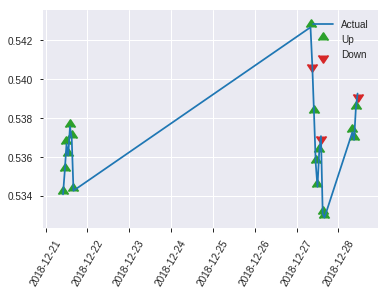


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.1899043574396929
RMSE: 0.43578017100333155
LogLoss: 0.5645044255039989
Mean Per-Class Error: 0.25589896975739457
AUC: 0.7817381189764041
pr_auc: 0.6967059273982793
Gini: 0.5634762379528082
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41014954447746277: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      81   37   0.3136   (37.0/118.0)
1      21   81   0.2059   (21.0/102.0)
Total  102  118  0.2636   (58.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.41015      0.736364  117
max f2                       0.241373     0.837563  182
max f0point5                 0.514609     0.734043  91
max accuracy                 0.514609     0.745455  91
max precision                0.850413     1         0
max recall                   0.168162     1         206
max specificity              0.850413     1         0
max absolute_mcc             0.453994     0.488202  101
max min_per_class_accuracy   0.439672     0.728814  106
max mean_per_class_accuracy  0.453994     0.744101  101

Gains/Lift Table: Avg response rate: 46.36 %, avg score: 46.83 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.836903           1.43791   1.43791            0.666667         0.842543  0.666667                    0.842543            0.0196078       0.0196078                  43.7908   43.7908
    2        0.0227273                   0.834465           1.07843   1.29412            0.5              0.834973  0.6                         0.839515            0.00980392      0.0294118                  7.84314   29.4118
    3        0.0318182                   0.826443           1.07843   1.23249            0.5              0.831714  0.571429                    0.837286            0.00980392      0.0392157                  7.84314   23.2493
    4        0.0409091                   0.821462           2.15686   1.43791            1                0.823917  0.666667                    0.834316            0.0196078       0.0588235                  115.686   43.7908
    5        0.05                        0.811152           2.15686   1.56863            1                0.816303  0.727273                    0.83104             0.0196078       0.0784314                  115.686   56.8627
    6        0.1                         0.756627           1.76471   1.66667            0.818182         0.783696  0.772727                    0.807368            0.0882353       0.166667                   76.4706   66.6667
    7        0.15                        0.731055           1.56863   1.63399            0.727273         0.74321   0.757576                    0.785982            0.0784314       0.245098                   56.8627   63.3987
    8        0.2                         0.688164           1.76471   1.66667            0.818182         0.714728  0.772727                    0.768169            0.0882353       0.333333                   76.4706   66.6667
    9        0.3                         0.613102           1.56863   1.63399            0.727273         0.657102  0.757576                    0.731147            0.156863        0.490196                   56.8627   63.3987
    10       0.4                         0.527084           1.56863   1.61765            0.727273         0.576268  0.75                        0.692427            0.156863        0.647059                   56.8627   61.7647
    11       0.5                         0.430765           0.980392  1.4902             0.454545         0.477567  0.690909                    0.649455            0.0980392       0.745098                   -1.96078  49.0196
    12       0.6                         0.370426           0.686275  1.35621            0.318182         0.400212  0.628788                    0.607914            0.0686275       0.813725                   -31.3725  35.6209
    13       0.7                         0.329193           0.588235  1.2465             0.272727         0.347253  0.577922                    0.570677            0.0588235       0.872549                   -41.1765  24.6499
    14       0.8                         0.280085           0.686275  1.17647            0.318182         0.306851  0.545455                    0.537699            0.0686275       0.941176                   -31.3725  17.6471
    15       0.9                         0.19176            0.392157  1.08932            0.181818         0.22888   0.505051                    0.503386            0.0392157       0.980392                   -60.7843  8.93246
    16       1                           0.108431           0.196078  1                  0.0909091        0.152991  0.463636                    0.468346         

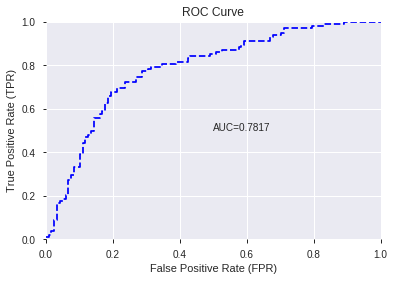

This function is available for GLM models only


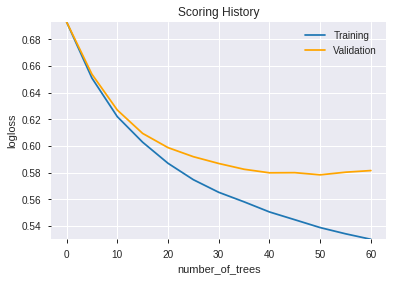

--2019-08-28 15:39:15--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.108.27
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.108.27|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190828_153853_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190828_153853_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_bf14',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'DIV',
 'TRANGE',
 'STOCHF_fastk',
 'CORREL_20',
 'hour',
 'ADOSC',
 'ULTOSC',
 'SUB',
 'aroonup_8',
 'DX_8',
 'MINUS_DI_8',
 'DX_24',
 'Volume',
 'STOCHRSI_fastd',
 'OBV',
 'HT_PHASOR_quadrature',
 'MINUS_DI_20',
 'STOCH_slowd',
 'WILLR_8',
 'WILLR_12',
 'DX_12',
 'aroonup_20',
 'MINUS_DI_14',
 'STOCHRSI_fastk',
 'WILLR_24',
 'DX_20',
 'MINUS_DI_24',
 'MINUS_DI_12',
 'WILLR_30',
 'dayofyear',
 'dayofweek',
 'aroonup_30',
 'AD',
 'weekday_name',
 'WILLR_14',
 'days_in_month',
 'week']

In [14]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc  logloss  mean_per_class_error     rmse       mse
0  GLM_grid_1_AutoML_20190828_153924_model_1  0.821452  0.54626              0.233632  0.42905  0.184084

variable  relative_importance  scaled_importance  percentage
0                          BOP             0.316431           1.000000    0.031056
1           CDLCLOSINGMARUBOZU             0.168990           0.534050    0.016585
2                       ULTOSC             0.119352           0.377182    0.011714
3                         hour             0.117227           0.370465    0.011505
4                  CDLLONGLINE             0.112448           0.355363    0.011036
...                        ...                  ...                ...         ...
1031                 MAVP_30_1             0.000055           0.000175    0.000005
1032   BBANDS_upperband_24_1_5             0.000051           0.000162    0.000005
1033                    WMA_14             0.000048           0.000152    0.000005
1034   BBANDS_lowerband_14_1_5             0.000016           0.000051    0.000002
1035  BBANDS_middleband_20_1_5             0.000016           0.000050    0.000002

[1036 rows x 4 columns]

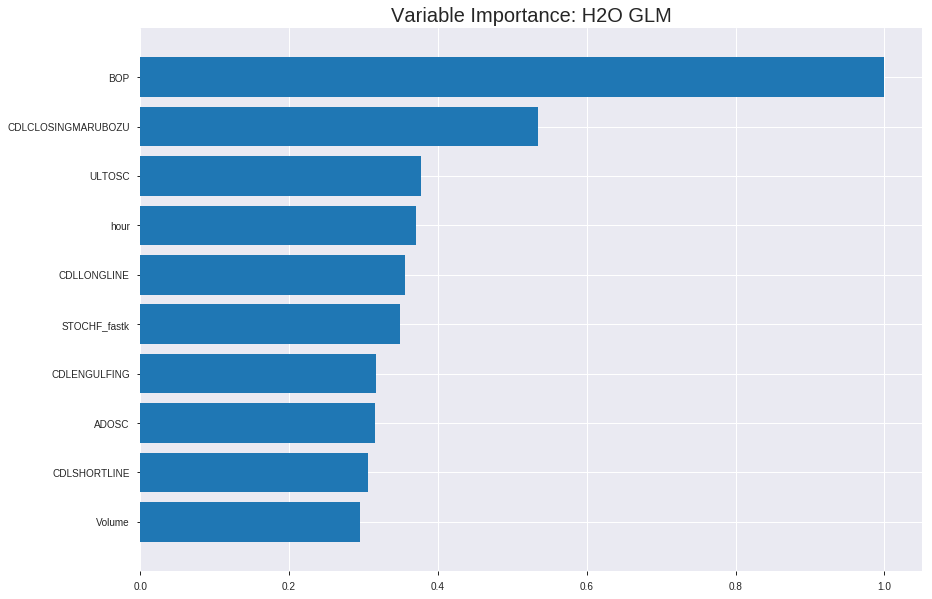

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_153924_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.1855651634637442
RMSE: 0.4307727515335019
LogLoss: 0.5507271812675313
Null degrees of freedom: 1536
Residual degrees of freedom: 500
Null deviance: 2130.546400580142
Residual deviance: 1692.9353552163911
AIC: 3766.935355216391
AUC: 0.7990830115830116
pr_auc: 0.794879122327478
Gini: 0.5981660231660233
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.33903262410257073: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      331  446   0.574    (446.0/777.0)
1      56   704   0.0737   (56.0/760.0)
Total  387  1150  0.3266   (502.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.339033     0.737173  277
max f2                       0.221949     0.846014  334
max f0point5                 0.608028     0.737974  132
max accuracy                 0.51576      0.72609   182
max precision                0.937431     1         0
max recall                   0.0611465    1         393
max specificity              0.937431     1         0
max absolute_mcc             0.51576      0.452089  182
max min_per_class_accuracy   0.503732     0.723295  189
max mean_per_class_accuracy  0.514299     0.725963  183

Gains/Lift Table: Avg response rate: 49.45 %, avg score: 49.45 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.894709           2.02237   2.02237            1                0.912626  1                           0.912626            0.0210526       0.0210526                  102.237   102.237
    2        0.0201692                   0.879009           1.88754   1.95713            0.933333         0.887692  0.967742                    0.900561            0.0184211       0.0394737                  88.7544   95.7131
    3        0.0305791                   0.852583           1.89597   1.93631            0.9375           0.865041  0.957447                    0.888469            0.0197368       0.0592105                  89.597    93.631
    4        0.0403383                   0.836263           1.88754   1.92451            0.933333         0.845167  0.951613                    0.877993            0.0184211       0.0776316                  88.7544   92.4512
    5        0.0500976                   0.822381           1.88754   1.91731            0.933333         0.830712  0.948052                    0.868782            0.0184211       0.0960526                  88.7544   91.731
    6        0.100195                    0.774788           1.86478   1.89105            0.922078         0.798303  0.935065                    0.833543            0.0934211       0.189474                   86.4781   89.1046
    7        0.150293                    0.728706           1.60214   1.79474            0.792208         0.748794  0.887446                    0.805293            0.0802632       0.269737                   60.2136   79.4743
    8        0.20039                     0.687453           1.65467   1.75972            0.818182         0.70604   0.87013                     0.78048             0.0828947       0.352632                   65.4665   75.9723
    9        0.299935                    0.624371           1.46721   1.66264            0.72549          0.655645  0.822126                    0.739049            0.146053        0.498684                   46.7208   66.2641
    10       0.40013                     0.567994           1.19504   1.54555            0.590909         0.595631  0.764228                    0.703136            0.119737        0.618421                   19.5036   54.555
    11       0.500325                    0.501945           1.08998   1.45432            0.538961         0.537358  0.719116                    0.669937            0.109211        0.727632                   8.99778   45.4317
    12       0.59987                     0.437511           0.753431  1.33801            0.372549         0.468619  0.661605                    0.63653             0.075           0.802632                   -24.6569  33.8009
    13       0.700065                    0.371625           0.787936  1.25928            0.38961          0.404876  0.622677                    0.603375            0.0789474       0.881579                   -21.2064  25.9281
    14       0.79961                     0.298894           0.660905  1.18479            0.326797         0.336219  0.585842                    0.570116            0.0657895       0.947368                   -33.9095  18.4789
    15       0.899805                    0.20683            0.341439  1.09088            0.168831         0.252645  0.539407                    0.534765            0.0342105       0.981579                   -65.8561  9.08799
    16       1                           0.0177605          0.183852  1                  0.0909091        0.132596  0.49447                     0.49447             



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.19653348118544875
RMSE: 0.4433209685830896
LogLoss: 0.5693804615001745
Null degrees of freedom: 439
Residual degrees of freedom: -597
Null deviance: 609.536667332913
Residual deviance: 501.05480612015356
AIC: 2575.0548061201534
AUC: 0.7744050208165041
pr_auc: 0.7260044085137662
Gini: 0.5488100416330082
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2980972719411918: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      124  107  0.4632   (107.0/231.0)
1      23   186  0.11     (23.0/209.0)
Total  147  293  0.2955   (130.0/440.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.298097     0.741036  263
max f2                       0.208501     0.851064  305
max f0point5                 0.444353     0.700888  179
max accuracy                 0.444353     0.713636  179
max precision                0.909002     1         0
max recall                   0.124595     1         355
max specificity              0.909002     1         0
max absolute_mcc             0.298097     0.451813  263
max min_per_class_accuracy   0.42683      0.709957  192
max mean_per_class_accuracy  0.348933     0.716678  234

Gains/Lift Table: Avg response rate: 47.50 %, avg score: 41.53 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113636                   0.852543           2.10526   2.10526            1                0.883269  1                           0.883269            0.0239234       0.0239234                  110.526   110.526
    2        0.0204545                   0.835572           1.57895   1.87135            0.75             0.844488  0.888889                    0.866033            0.0143541       0.0382775                  57.8947   87.1345
    3        0.0318182                   0.820345           2.10526   1.95489            1                0.827462  0.928571                    0.852258            0.0239234       0.062201                   110.526   95.4887
    4        0.0409091                   0.807496           1.57895   1.87135            0.75             0.813036  0.888889                    0.843542            0.0143541       0.076555                   57.8947   87.1345
    5        0.05                        0.792314           2.10526   1.91388            1                0.801847  0.909091                    0.835961            0.0191388       0.0956938                  110.526   91.3876
    6        0.1                         0.715666           1.5311    1.72249            0.727273         0.757172  0.818182                    0.796567            0.076555        0.172249                   53.11     72.2488
    7        0.15                        0.65963            1.5311    1.65869            0.727273         0.689891  0.787879                    0.761008            0.076555        0.248804                   53.11     65.8692
    8        0.2                         0.612715           1.43541   1.60287            0.681818         0.639215  0.761364                    0.73056             0.0717703       0.320574                   43.5407   60.2871
    9        0.3                         0.546588           1.29187   1.4992             0.613636         0.580001  0.712121                    0.680373            0.129187        0.449761                   29.1866   49.9203
    10       0.4                         0.490922           1.38756   1.47129            0.659091         0.514637  0.698864                    0.638939            0.138756        0.588517                   38.756    47.1292
    11       0.5                         0.419074           1.29187   1.43541            0.613636         0.450669  0.681818                    0.601285            0.129187        0.717703                   29.1866   43.5407
    12       0.6                         0.34276            1.05263   1.37161            0.5              0.383571  0.651515                    0.565               0.105263        0.822967                   5.26316   37.1611
    13       0.7                         0.268639           0.717703  1.2782             0.340909         0.308783  0.607143                    0.528397            0.0717703       0.894737                   -28.2297  27.8195
    14       0.8                         0.188898           0.62201   1.19617            0.295455         0.224385  0.568182                    0.490396            0.062201        0.956938                   -37.799   19.6172
    15       0.9                         0.118275           0.430622  1.11111            0.204545         0.158341  0.527778                    0.453501            0.0430622       1                          -56.9378  11.1111
    16       1                           0.0171829          0         1                  0                0.071001  0.475                       0.415251         


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-28 15:39:27  0.000 sec   2            .2E2      1031          1.3600607971278558  1.362538522289985
     2019-08-28 15:39:29  2.119 sec   4            .15E2     1037          1.3531148191362536  1.354005930820918
     2019-08-28 15:39:31  4.161 sec   6            .11E2     1037          1.3445647289216829  1.343696381898248
     2019-08-28 15:39:33  6.249 sec   8            .78E1     1037          1.3342347292846957  1.3311021315843066
     2019-08-28 15:39:35  8.331 sec   10           .56E1     1037          1.3219278667599725  1.316221382100504
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-28 15:40:04  36.735 sec  38           .66E-1    1037          1.0897673429039674  1.140089054466601
     2019-08-28 15:40:06  38.775 sec  40           .48E-1    1037          1.07897909066822    1.1436587221179637
     2019-08-28 15:40:08  40.868 sec  42           .35E-1    1037          1.0689634336462277  1.1493301263503162
     2019-08-28 15:40:10  42.913 sec  44           .26E-1    1037          1.0596000980874953  1.1570135456152677
     2019-08-28 15:40:12  44.932 sec  46           .19E-1    1037          1.0507490371603285  1.166482828982647


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7636363636363637)

('F1', 0.7592592592592592)

('auc', 0.8214523097374543)

('logloss', 0.5462604170470767)

('mean_per_class_error', 0.23363243602525752)

('rmse', 0.42905014641020833)

('mse', 0.18408402813462119)

glm prediction progress: |████████████████████████████████████████████████| 100%


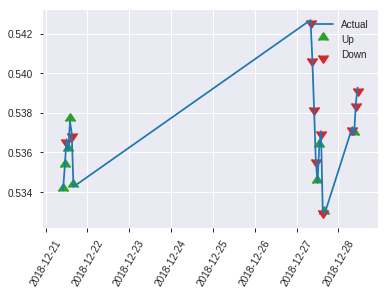


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.18408402813462119
RMSE: 0.42905014641020833
LogLoss: 0.5462604170470767
Null degrees of freedom: 219
Residual degrees of freedom: -817
Null deviance: 304.6577240810208
Residual deviance: 240.35458350071372
AIC: 2314.3545835007135
AUC: 0.8214523097374543
pr_auc: 0.7802501137949414
Gini: 0.6429046194749086
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35372826357651904: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      86   32   0.2712   (32.0/118.0)
1      20   82   0.1961   (20.0/102.0)
Total  106  114  0.2364   (52.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.353728     0.759259  113
max f2                       0.200707     0.843478  166
max f0point5                 0.499795     0.751366  65
max accuracy                 0.353728     0.763636  113
max precision                0.890902     1         0
max recall                   0.0607847    1         211
max specificity              0.890902     1         0
max absolute_mcc             0.353728     0.531676  113
max min_per_class_accuracy   0.382235     0.728814  106
max mean_per_class_accuracy  0.353728     0.766368  113

Gains/Lift Table: Avg response rate: 46.36 %, avg score: 37.77 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.847182           2.15686   2.15686            1                0.864556   1                           0.864556            0.0294118       0.0294118                  115.686   115.686
    2        0.0227273                   0.804717           2.15686   2.15686            1                0.820989   1                           0.847129            0.0196078       0.0490196                  115.686   115.686
    3        0.0318182                   0.785027           1.07843   1.84874            0.5              0.80086    0.857143                    0.83391             0.00980392      0.0588235                  7.84314   84.8739
    4        0.0409091                   0.757022           2.15686   1.91721            1                0.766967   0.888889                    0.819034            0.0196078       0.0784314                  115.686   91.7211
    5        0.05                        0.733829           2.15686   1.96078            1                0.749747   0.909091                    0.806436            0.0196078       0.0980392                  115.686   96.0784
    6        0.1                         0.680598           1.76471   1.86275            0.818182         0.709958   0.863636                    0.758197            0.0882353       0.186275                   76.4706   86.2745
    7        0.15                        0.614684           1.76471   1.83007            0.818182         0.648826   0.848485                    0.72174             0.0882353       0.27451                    76.4706   83.0065
    8        0.2                         0.590302           1.56863   1.76471            0.727273         0.604321   0.818182                    0.692385            0.0784314       0.352941                   56.8627   76.4706
    9        0.3                         0.498811           1.86275   1.79739            0.863636         0.537533   0.833333                    0.640768            0.186275        0.539216                   86.2745   79.7386
    10       0.4                         0.417468           1.17647   1.64216            0.545455         0.45981    0.761364                    0.595528            0.117647        0.656863                   17.6471   64.2157
    11       0.5                         0.372572           1.07843   1.52941            0.5              0.398999   0.709091                    0.556222            0.107843        0.764706                   7.84314   52.9412
    12       0.6                         0.296916           0.980392  1.43791            0.454545         0.327848   0.666667                    0.51816             0.0980392       0.862745                   -1.96078  43.7908
    13       0.7                         0.233413           0.490196  1.30252            0.227273         0.263224   0.603896                    0.481741            0.0490196       0.911765                   -50.9804  30.2521
    14       0.8                         0.172997           0.392157  1.18873            0.181818         0.204004   0.551136                    0.447023            0.0392157       0.95098                    -60.7843  18.8725
    15       0.9                         0.111363           0.294118  1.08932            0.136364         0.135677   0.505051                    0.412429            0.0294118       0.980392                   -70.5882  8.93246
    16       1                           0.0158214          0.196078  1                  0.0909091        0.0654105  0.463636                   

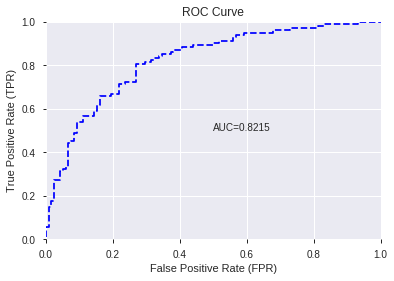

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


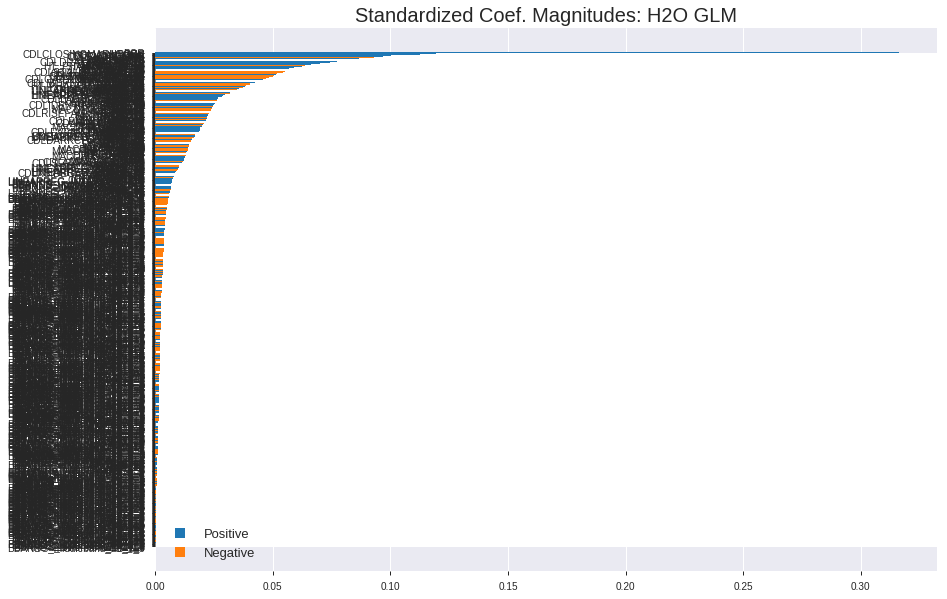

'log_likelihood'
--2019-08-28 15:40:39--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.144.43
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.144.43|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_153924_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_153924_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_bf14',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

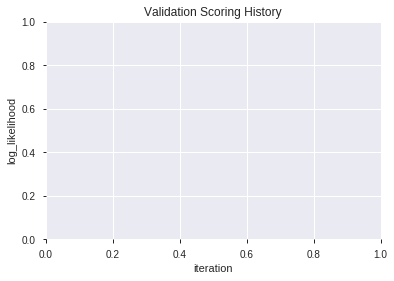

In [15]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [16]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [17]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [18]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190828_154049_model_4  0.794616  0.561771              0.279163  0.433774  0.188160
1               XGBoost_2_AutoML_20190828_154049  0.772682  0.577169              0.273513  0.442479  0.195788
2  XGBoost_grid_1_AutoML_20190828_154049_model_7  0.764041  0.579548              0.301429  0.444504  0.197584
3  XGBoost_grid_1_AutoML_20190828_154049_model_6  0.759139  0.589708              0.360585  0.448875  0.201489
4  XGBoost_grid_1_AutoML_20190828_154049_model_2  0.753406  0.603388              0.370638  0.455147  0.207159
5               XGBoost_1_AutoML_20190828_154049  0.750415  0.594841              0.276670  0.451280  0.203654
6  XGBoost_grid_1_AutoML_20190828_154049_model_1  0.747175  0.595499              0.351196  0.453373  0.205547
7  XGBoost_grid_1_AutoML_20190828_154049_model_3  0.737122  0.615493              0.362828  0.461479  0.212963
8               XGBoost_3_AutoML_20190828_154049  0.737039  0.603880              0.334663  0.456521  0.208411
9  XGBoost_grid_1_AutoML_20190828_154049_model_5  0.688102  0.639780              0.364822  0.473284  0.223998

variable  relative_importance  scaled_importance  percentage
0                        BOP          1851.595703           1.000000    0.367003
1                        DIV           312.426727           0.168734    0.061926
2                     TRANGE           236.562973           0.127762    0.046889
3               STOCHF_fastk           221.826385           0.119803    0.043968
4                        SUB           111.072281           0.059987    0.022016
..                       ...                  ...                ...         ...
132                 WILLR_30             4.998654           0.002700    0.000991
133                  BETA_30             4.760114           0.002571    0.000943
134                 SAR_0.24             4.728422           0.002554    0.000937
135  BBANDS_upperband_12_4_5             4.452042           0.002404    0.000882
136                   MFI_20             4.242567           0.002291    0.000841

[137 rows x 4 columns]

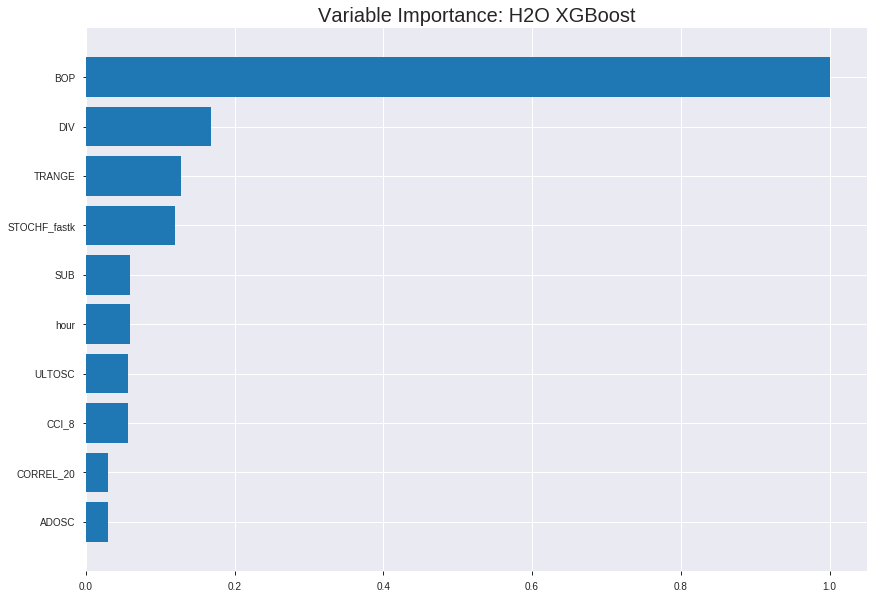

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190828_154049_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.17016879128184384
RMSE: 0.4125152012736547
LogLoss: 0.518434412379874
Mean Per-Class Error: 0.23438071530176796
AUC: 0.8451796721533563
pr_auc: 0.8450746685112108
Gini: 0.6903593443067126
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47976253926754: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      566  211  0.2716   (211.0/777.0)
1      160  600  0.2105   (160.0/760.0)
Total  726  811  0.2414   (371.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.479763     0.763845  202
max f2                       0.269988     0.863868  318
max f0point5                 0.588991     0.792602  145
max accuracy                 0.520743     0.765777  183
max precision                0.881826     1         0
max recall                   0.171127     1         370
max specificity              0.881826     1         0
max absolute_mcc             0.588991     0.538415  145
max min_per_class_accuracy   0.506707     0.75547   190
max mean_per_class_accuracy  0.520743     0.765619  183

Gains/Lift Table: Avg response rate: 49.45 %, avg score: 49.51 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.842811           2.02237    2.02237            1                0.853689  1                           0.853689            0.0210526       0.0210526                  102.237   102.237
    2        0.0201692                   0.832296           2.02237    2.02237            1                0.836697  1                           0.845467            0.0197368       0.0407895                  102.237   102.237
    3        0.0305791                   0.820652           2.02237    2.02237            1                0.826296  1                           0.838941            0.0210526       0.0618421                  102.237   102.237
    4        0.0403383                   0.81097            1.88754    1.98975            0.933333         0.814674  0.983871                    0.83307             0.0184211       0.0802632                  88.7544   98.975
    5        0.0500976                   0.802883           2.02237    1.9961             1                0.805878  0.987013                    0.827773            0.0197368       0.1                        102.237   99.6104
    6        0.100195                    0.764824           1.83852    1.91731            0.909091         0.783991  0.948052                    0.805882            0.0921053       0.192105                   83.8517   91.731
    7        0.150293                    0.735494           1.83852    1.89105            0.909091         0.749236  0.935065                    0.787               0.0921053       0.284211                   83.8517   89.1046
    8        0.20039                     0.702046           1.73346    1.85165            0.857143         0.718435  0.915584                    0.769859            0.0868421       0.371053                   73.3459   85.1649
    9        0.299935                    0.63882            1.63904    1.78109            0.810458         0.669584  0.880694                    0.736579            0.163158        0.534211                   63.9044   78.1088
    10       0.40013                     0.571927           1.28696    1.65736            0.636364         0.602558  0.819512                    0.703019            0.128947        0.663158                   28.6962   65.7356
    11       0.500325                    0.503265           0.971787   1.52006            0.480519         0.540019  0.751625                    0.670377            0.0973684       0.760526                   -2.82126  52.0064
    12       0.59987                     0.429063           0.779868   1.39723            0.385621         0.464813  0.690889                    0.636265            0.0776316       0.838158                   -22.0132  39.7233
    13       0.700065                    0.357357           0.722274   1.30063            0.357143         0.393246  0.643123                    0.601483            0.0723684       0.910526                   -27.7726  30.0631
    14       0.79961                     0.28942            0.541942   1.20618            0.267974         0.324035  0.59642                     0.566943            0.0539474       0.964474                   -45.8058  20.6181
    15       0.899805                    0.209882           0.275778   1.10258            0.136364         0.251081  0.545192                    0.531771            0.0276316       0.992105                   -72.4222  10.2578
    16       1                           0.102534           0.0787936  1                  0.038961         0.166159  0.49447                     0



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.1977043390455954
RMSE: 0.4446395608193173
LogLoss: 0.5788002038793824
Mean Per-Class Error: 0.2926634768740032
AUC: 0.7643281758114293
pr_auc: 0.727092673358259
Gini: 0.5286563516228586
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3363843858242035: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      113  118  0.5108   (118.0/231.0)
1      22   187  0.1053   (22.0/209.0)
Total  135  305  0.3182   (140.0/440.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.336384     0.727626  276
max f2                       0.204985     0.843521  354
max f0point5                 0.483463     0.688705  198
max accuracy                 0.483463     0.706818  198
max precision                0.839563     1         0
max recall                   0.157712     1         387
max specificity              0.839563     1         0
max absolute_mcc             0.336384     0.415716  276
max min_per_class_accuracy   0.490376     0.703349  193
max mean_per_class_accuracy  0.483463     0.707337  198

Gains/Lift Table: Avg response rate: 47.50 %, avg score: 47.47 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113636                   0.831143           2.10526    2.10526            1                0.836044  1                           0.836044            0.0239234       0.0239234                  110.526   110.526
    2        0.0204545                   0.823958           2.10526    2.10526            1                0.828027  1                           0.832481            0.0191388       0.0430622                  110.526   110.526
    3        0.0318182                   0.809486           1.68421    1.95489            0.8              0.816821  0.928571                    0.826888            0.0191388       0.062201                   68.4211   95.4887
    4        0.0409091                   0.800505           2.10526    1.9883             1                0.803851  0.944444                    0.821769            0.0191388       0.0813397                  110.526   98.8304
    5        0.05                        0.792423           1.57895    1.91388            0.75             0.796505  0.909091                    0.817175            0.0143541       0.0956938                  57.8947   91.3876
    6        0.1                         0.740883           1.72249    1.81818            0.818182         0.766104  0.863636                    0.79164             0.0861244       0.181818                   72.2488   81.8182
    7        0.15                        0.716066           1.24402    1.62679            0.590909         0.731553  0.772727                    0.771611            0.062201        0.244019                   24.4019   62.6794
    8        0.2                         0.687256           1.5311     1.60287            0.727273         0.701855  0.761364                    0.754172            0.076555        0.320574                   53.11     60.2871
    9        0.3                         0.614386           1.29187    1.4992             0.613636         0.652652  0.712121                    0.720332            0.129187        0.449761                   29.1866   49.9203
    10       0.4                         0.555323           1.29187    1.44737            0.613636         0.583912  0.6875                      0.686227            0.129187        0.578947                   29.1866   44.7368
    11       0.5                         0.482095           1.38756    1.43541            0.659091         0.522507  0.681818                    0.653483            0.138756        0.717703                   38.756    43.5407
    12       0.6                         0.39895            0.909091   1.34769            0.431818         0.437224  0.640152                    0.61744             0.0909091       0.808612                   -9.09091  34.7687
    13       0.7                         0.32836            0.861244   1.2782             0.409091         0.362433  0.607143                    0.58101             0.0861244       0.894737                   -13.8756  27.8195
    14       0.8                         0.252058           0.574163   1.19019            0.272727         0.28847   0.565341                    0.544443            0.0574163       0.952153                   -42.5837  19.0191
    15       0.9                         0.194025           0.382775   1.10048            0.181818         0.224174  0.522727                    0.508857            0.0382775       0.990431                   -61.7225  10.0478
    16       1                           0.129979           0.0956938  1                  0.0454545        0.166979  0.475                      


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 15:41:24  15.640 sec  0                  0.5              0.693147            0.5             0                  1                0.50553                          0.5                0.693147              0.5               0                    1                  0.525
    2019-08-28 15:41:25  16.857 sec  5                  0.478077         0.650014            0.790383        0.754087           1.9381           0.313598                         0.479768           0.653257              0.759492          0.691911             1.84211            0.340909
    2019-08-28 15:41:26  17.206 sec  10                 0.462828         0.620302            0.797694        0.792427           2.02237          0.305791                         0.465449           0.625141              0.765954          0.723516             1.84211            0.318182
    2019-08-28 15:41:26  17.566 sec  15                 0.452183         0.599342            0.802733        0.798637           2.02237          0.316851                         0.456842           0.60772               0.767849          0.733291             1.68421            0.284091
    2019-08-28 15:41:27  17.918 sec  20                 0.443885         0.58271             0.808823        0.806359           2.02237          0.312297                         0.45219            0.597812              0.767114          0.733176             1.68421            0.302273
    2019-08-28 15:41:27  18.262 sec  25                 0.43797          0.570442            0.811595        0.809995           2.02237          0.301236                         0.44945            0.591507              0.766254          0.732484             2.10526            0.315909
    2019-08-28 15:41:27  18.629 sec  30                 0.432382         0.559159            0.818226        0.814319           2.02237          0.303188                         0.448588           0.589671              0.766503          0.72533              2.10526            0.309091
    2019-08-28 15:41:28  19.006 sec  35                 0.428788         0.551658            0.821627        0.812405           1.89597          0.262199                         0.445849           0.583305              0.768574          0.731385             2.10526            0.293182
    2019-08-28 15:41:28  19.374 sec  40                 0.425052         0.544044            0.826741        0.820012           2.02237          0.2635                           0.445571           0.582041              0.766368          0.725555             1.68421            0.3
    2019-08-28 15:41:28  19.722 sec  45                 0.422225         0.538127            0.830168        0.828688           2.02237          0.258946                         0.444284           0.579188              0.768088          0.731863             2.10526            0.295455
    2019-08-28 15:41:29  20.079 sec  50                 0.418758         0.531222            0.836531        0.834379           2.02237          0.246584                         0.444936           0.580487              0.765167          0.72626              2.10526            0.297727
    2019-08-28 15:41:29  20.451 sec  55                 0.415277         0.524221            0.841253        0.83983            2.02237          0.251789                         0.444491           0.57908               0.765757          0.726551 

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ---------------------
BOP                      1851.595703125         1.0                    0.3670034765464882
DIV                      312.4267272949219      0.1687337720473367     0.061925880952175216
TRANGE                   236.56297302246094     0.1277616774672817     0.04688897979990351
STOCHF_fastk             221.82638549804688     0.11980281933235375    0.04396805119504465
SUB                      111.07228088378906     0.05998732914335924    0.02201555834435131
---                      ---                    ---                    ---
WILLR_30                 4.998654365539551      0.0026996467733766904  0.0009907797512767548
BETA_30                  4.760113716125488      0.002570817002918988   0.0009434987776360917
SAR_0.24                 4.728422164916992      0.0025537011978028876  0.0009372172176545908
BBANDS_upperband_12_4_5  4.4520416259765625     0.0024044350602362616  0.0008824360262369727
MFI_20                   4.24256706237793       0.0022913031474514696  0.0008409162209366


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7545454545454545)

('F1', 0.7377049180327869)

('auc', 0.7946161515453639)

('logloss', 0.5617714877456573)

('mean_per_class_error', 0.24875373878364904)

('rmse', 0.4337741977017134)

('mse', 0.18816005459176513)

xgboost prediction progress: |████████████████████████████████████████████| 100%


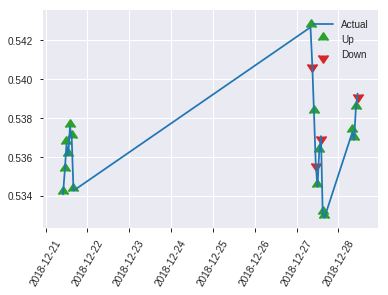


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.18816005459176513
RMSE: 0.4337741977017134
LogLoss: 0.5617714877456573
Mean Per-Class Error: 0.24875373878364904
AUC: 0.7946161515453639
pr_auc: 0.7093290795934256
Gini: 0.5892323030907278
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3729357421398163: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      66   52   0.4407   (52.0/118.0)
1      12   90   0.1176   (12.0/102.0)
Total  78   142  0.2909   (64.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.372936     0.737705  141
max f2                       0.27218      0.836149  183
max f0point5                 0.509588     0.740741  95
max accuracy                 0.509588     0.754545  95
max precision                0.851615     1         0
max recall                   0.206801     1         201
max specificity              0.851615     1         0
max absolute_mcc             0.509588     0.505271  95
max min_per_class_accuracy   0.46896      0.745098  105
max mean_per_class_accuracy  0.509588     0.751246  95

Gains/Lift Table: Avg response rate: 46.36 %, avg score: 48.24 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.843635           1.43791    1.43791            0.666667         0.84652   0.666667                    0.84652             0.0196078       0.0196078                  43.7908   43.7908
    2        0.0227273                   0.840474           0          0.862745           0                0.841854  0.4                         0.844654            0               0.0196078                  -100      -13.7255
    3        0.0318182                   0.814994           2.15686    1.23249            1                0.829493  0.571429                    0.840322            0.0196078       0.0392157                  115.686   23.2493
    4        0.0409091                   0.802519           1.07843    1.19826            0.5              0.808736  0.555556                    0.833303            0.00980392      0.0490196                  7.84314   19.8257
    5        0.05                        0.786176           2.15686    1.37255            1                0.795072  0.636364                    0.826352            0.0196078       0.0686275                  115.686   37.2549
    6        0.1                         0.743503           1.96078    1.66667            0.909091         0.769313  0.772727                    0.797832            0.0980392       0.166667                   96.0784   66.6667
    7        0.15                        0.715678           1.96078    1.76471            0.909091         0.733305  0.818182                    0.776323            0.0980392       0.264706                   96.0784   76.4706
    8        0.2                         0.692817           1.56863    1.71569            0.727273         0.702733  0.795455                    0.757926            0.0784314       0.343137                   56.8627   71.5686
    9        0.3                         0.632372           1.66667    1.69935            0.772727         0.667304  0.787879                    0.727718            0.166667        0.509804                   66.6667   69.9346
    10       0.4                         0.545016           1.37255    1.61765            0.636364         0.589406  0.75                        0.69314             0.137255        0.647059                   37.2549   61.7647
    11       0.5                         0.456459           1.17647    1.52941            0.545455         0.496904  0.709091                    0.653893            0.117647        0.764706                   17.6471   52.9412
    12       0.6                         0.399927           0.686275   1.38889            0.318182         0.426815  0.643939                    0.616047            0.0686275       0.833333                   -31.3725  38.8889
    13       0.7                         0.347215           0.588235   1.27451            0.272727         0.371944  0.590909                    0.581175            0.0588235       0.892157                   -41.1765  27.451
    14       0.8                         0.300969           0.490196   1.17647            0.227273         0.325487  0.545455                    0.549214            0.0490196       0.941176                   -50.9804  17.6471
    15       0.9                         0.215001           0.490196   1.10022            0.227273         0.25489   0.510101                    0.516511            0.0490196       0.990196                   -50.9804  10.0218
    16       1                           0.128325           0.0980392  1                  0.0454545        0.175853  0.463636                   

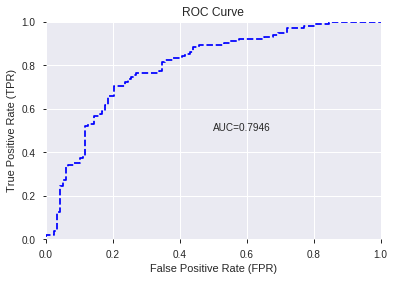

This function is available for GLM models only


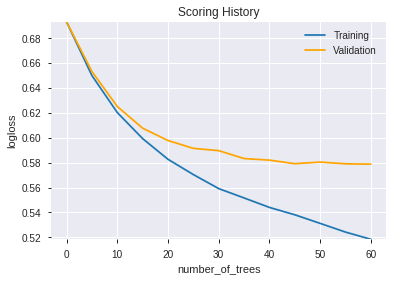

--2019-08-28 15:41:58--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.228.56
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.228.56|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190828_154049_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190828_154049_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_bf14',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [19]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_154207_model_9  0.788966  0.563020              0.282237  0.436565  0.190589
1  DeepLearning_grid_1_AutoML_20190828_154207_model_6  0.783898  0.580784              0.268362  0.446044  0.198956
2  DeepLearning_grid_1_AutoML_20190828_154207_model_8  0.781489  0.611073              0.255650  0.462359  0.213776
3  DeepLearning_grid_1_AutoML_20190828_154207_model_5  0.778996  0.576052              0.273513  0.444652  0.197716
4               DeepLearning_1_AutoML_20190828_154207  0.755650  0.677554              0.289797  0.473262  0.223977
5  DeepLearning_grid_1_AutoML_20190828_154207_model_7  0.752409  0.577519              0.328930  0.447932  0.200643
6  DeepLearning_grid_1_AutoML_20190828_154207_model_3  0.738451  0.782219              0.318378  0.482890  0.233182
7  DeepLearning_grid_1_AutoML_20190828_154207_model_2  0.690096  0.858476              0.319292  0.514007  0.264204
8  DeepLearning_grid_1_AutoML_20190828_154207_model_4  0.622383  1.158483              0.402293  0.572141  0.327345
9  DeepLearning_grid_1_AutoML_20190828_154207_model_1  0.593137  1.458579              0.378614  0.600853  0.361024

variable  relative_importance  scaled_importance  percentage
0                    BOP             1.000000           1.000000    0.042774
1     CDLCLOSINGMARUBOZU             0.928294           0.928294    0.039707
2            CDLLONGLINE             0.793261           0.793261    0.033931
3           CDLSHORTLINE             0.729882           0.729882    0.031220
4           CDLENGULFING             0.656540           0.656540    0.028083
5                 TRANGE             0.648704           0.648704    0.027748
6                    SUB             0.640929           0.640929    0.027415
7                    DIV             0.635600           0.635600    0.027187
8       CDLDRAGONFLYDOJI             0.569164           0.569164    0.024345
9                 ULTOSC             0.560677           0.560677    0.023982
10             CDLTAKURI             0.535306           0.535306    0.022897
11             CORREL_20             0.494851           0.494851    0.021167
12             aroonup_8             0.490024           0.490024    0.020960
13                  hour             0.470798           0.470798    0.020138
14         days_in_month             0.464668           0.464668    0.019876
15           CDLMARUBOZU             0.464252           0.464252    0.019858
16                Volume             0.451074           0.451074    0.019294
17              WILLR_30             0.431815           0.431815    0.018470
18        STOCHRSI_fastd             0.430521           0.430521    0.018415
19          STOCHF_fastk             0.429509           0.429509    0.018372
20          weekday_name             0.423804           0.423804    0.018128
21                  DX_8             0.422096           0.422096    0.018055
22                 ADOSC             0.420109           0.420109    0.017970
23           MINUS_DI_24             0.413545           0.413545    0.017689
24           CDLBELTHOLD             0.413105           0.413105    0.017670
25            MINUS_DI_8             0.409894           0.409894    0.017533
26               weekday             0.408717           0.408717    0.017482
27  HT_PHASOR_quadrature             0.408514           0.408514    0.017474
28             dayofweek             0.399887           0.399887    0.017105
29                 DX_20             0.399575           0.399575    0.017091
30                 DX_24             0.395808           0.395808    0.016930
31            aroonup_30             0.392364           0.392364    0.016783
32           MINUS_DI_12             0.390641           0.390641    0.016709
33           STOCH_slowd             0.389686           0.389686    0.016668
34                 DX_14             0.387809           0.387809    0.016588
35                 DX_12             0.382475           0.382475    0.016360
36              WILLR_12             0.381821           0.381821    0.016332
37           MINUS_DI_14             0.381502           0.381502    0.016318
38           MINUS_DI_20             0.381497           0.381497    0.016318
39                    AD             0.376065           0.376065    0.016086
40              WILLR_24             0.374169           0.374169    0.016005
41            aroonup_20             0.369476           0.369476    0.015804
42        STOCHRSI_fastk             0.366585           0.366585    0.015680
43            weekofyear             0.358956           0.358956    0.015354
44             dayofyear             0.357131           0.357131    0.015276
45              WILLR_14             0.356560           0.356560    0.015251
46                   OBV             0.353875           0.353875    0.015137
47                  week             0.352231           0.352231    0.015066
48                 month             0.346474           0.346474    0.014820
49               WILLR_8             0.338453           0.338453    0.014477

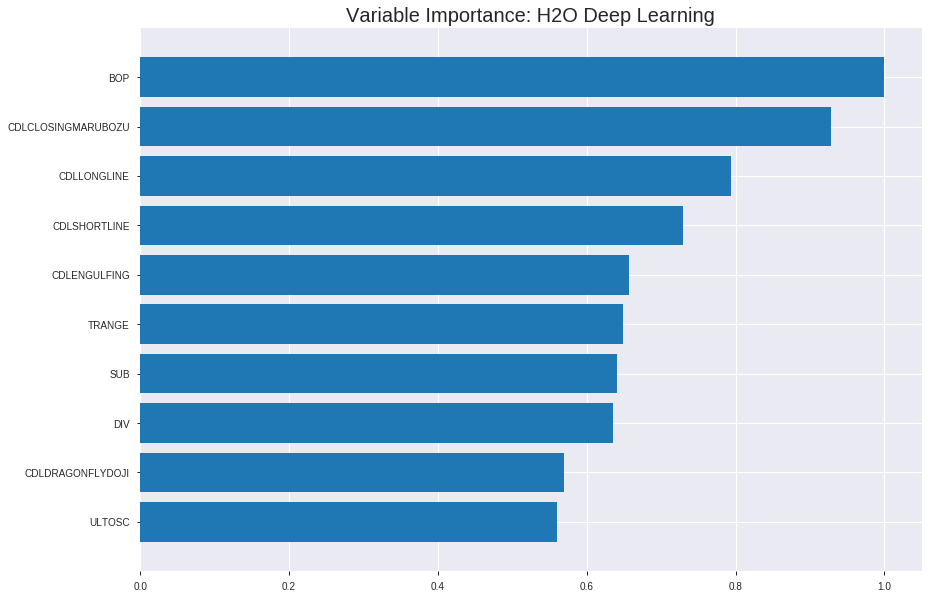

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_154207_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.18439019408485807
RMSE: 0.4294067932448881
LogLoss: 0.5459222109611905
Mean Per-Class Error: 0.2787720991668361
AUC: 0.7988340784393416
pr_auc: 0.7959795689307105
Gini: 0.5976681568786832
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4189304548495696: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      362  415   0.5341   (415.0/777.0)
1      66   694   0.0868   (66.0/760.0)
Total  428  1109  0.3129   (481.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.41893      0.742643  257
max f2                       0.273213     0.850498  311
max f0point5                 0.582731     0.725371  157
max accuracy                 0.527071     0.721535  189
max precision                0.949194     1         0
max recall                   0.0753633    1         386
max specificity              0.949194     1         0
max absolute_mcc             0.527071     0.443241  189
max min_per_class_accuracy   0.519453     0.710425  195
max mean_per_class_accuracy  0.527071     0.721228  189

Gains/Lift Table: Avg response rate: 49.45 %, avg score: 52.26 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0104099                   0.910916           2.02237   2.02237            1                0.923844  1                           0.923844            0.0210526       0.0210526                  102.237    102.237
    2        0.0201692                   0.898285           1.88754   1.95713            0.933333         0.904984  0.967742                    0.914718            0.0184211       0.0394737                  88.7544    95.7131
    3        0.0305791                   0.889663           1.89597   1.93631            0.9375           0.893784  0.957447                    0.907592            0.0197368       0.0592105                  89.597     93.631
    4        0.0403383                   0.884236           1.88754   1.92451            0.933333         0.886967  0.951613                    0.902602            0.0184211       0.0776316                  88.7544    92.4512
    5        0.0500976                   0.878137           1.88754   1.91731            0.933333         0.881683  0.948052                    0.898527            0.0184211       0.0960526                  88.7544    91.731
    6        0.100195                    0.835744           1.83852   1.87791            0.909091         0.860009  0.928571                    0.879268            0.0921053       0.188158                   83.8517    87.7914
    7        0.150293                    0.800743           1.70719   1.82101            0.844156         0.818867  0.900433                    0.859134            0.0855263       0.273684                   70.7194    82.1007
    8        0.20039                     0.748418           1.60214   1.76629            0.792208         0.775486  0.873377                    0.838222            0.0802632       0.353947                   60.2136    76.6289
    9        0.299935                    0.634142           1.40112   1.64509            0.69281          0.694046  0.813449                    0.790372            0.139474        0.493421                   40.1118    64.5094
    10       0.40013                     0.556685           1.19504   1.5324             0.590909         0.590675  0.757724                    0.740366            0.119737        0.613158                   19.5036    53.2396
    11       0.500325                    0.517879           0.998052  1.42539            0.493506         0.533769  0.704811                    0.698993            0.1             0.713158                   -0.194805  42.5388
    12       0.59987                     0.494261           0.978139  1.35117            0.48366          0.507062  0.668113                    0.667143            0.0973684       0.810526                   -2.1861    35.117
    13       0.700065                    0.437112           0.827333  1.2762             0.409091         0.471797  0.631041                    0.639185            0.0828947       0.893421                   -17.2667   27.6197
    14       0.79961                     0.322144           0.568378  1.18808            0.281046         0.383509  0.587469                    0.607355            0.0565789       0.95                       -43.1622   18.808
    15       0.899805                    0.187046           0.302042  1.08942            0.149351         0.25085   0.538684                    0.567658            0.0302632       0.980263                   -69.7958   8.94176
    16       1                           0.0257446          0.196984  1                  0.0974026        0.117629  0.49447                     0.52



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.19480127143798007
RMSE: 0.4413629701707882
LogLoss: 0.5674111656821202
Mean Per-Class Error: 0.29687856003645474
AUC: 0.7703659976387249
pr_auc: 0.7378635572747887
Gini: 0.5407319952774499
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.32963819234908287: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      117  114  0.4935   (114.0/231.0)
1      23   186  0.11     (23.0/209.0)
Total  140  300  0.3114   (137.0/440.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.329638     0.730845  269
max f2                       0.162751     0.844898  352
max f0point5                 0.516501     0.681544  145
max accuracy                 0.450213     0.697727  207
max precision                0.915465     1         0
max recall                   0.131425     1         364
max specificity              0.915465     1         0
max absolute_mcc             0.329638     0.425048  269
max min_per_class_accuracy   0.478077     0.692641  190
max mean_per_class_accuracy  0.351247     0.703121  254

Gains/Lift Table: Avg response rate: 47.50 %, avg score: 45.26 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113636                   0.908867           2.10526    2.10526            1                0.911676   1                           0.911676            0.0239234       0.0239234                  110.526   110.526
    2        0.0204545                   0.903225           1.57895    1.87135            0.75             0.905857   0.888889                    0.90909             0.0143541       0.0382775                  57.8947   87.1345
    3        0.0318182                   0.897026           2.10526    1.95489            1                0.899774   0.928571                    0.905763            0.0239234       0.062201                   110.526   95.4887
    4        0.0409091                   0.88915            2.10526    1.9883             1                0.893154   0.944444                    0.902961            0.0191388       0.0813397                  110.526   98.8304
    5        0.05                        0.879917           2.10526    2.00957            1                0.885345   0.954545                    0.899758            0.0191388       0.100478                   110.526   100.957
    6        0.1                         0.792217           1.5311     1.77033            0.727273         0.835259   0.840909                    0.867508            0.076555        0.177033                   53.11     77.0335
    7        0.15                        0.719585           1.72249    1.75439            0.818182         0.752025   0.833333                    0.829014            0.0861244       0.263158                   72.2488   75.4386
    8        0.2                         0.635151           1.5311     1.69856            0.727273         0.674712   0.806818                    0.790438            0.076555        0.339713                   53.11     69.8565
    9        0.3                         0.532431           1.29187    1.563              0.613636         0.57319    0.742424                    0.718022            0.129187        0.4689                     29.1866   56.2998
    10       0.4                         0.505495           1.10048    1.44737            0.522727         0.517524   0.6875                      0.667898            0.110048        0.578947                   10.0478   44.7368
    11       0.5                         0.468089           1.19617    1.39713            0.568182         0.489982   0.663636                    0.632315            0.119617        0.698565                   19.6172   39.7129
    12       0.6                         0.400724           1.00478    1.33174            0.477273         0.436133   0.632576                    0.599618            0.100478        0.799043                   0.478469  33.1738
    13       0.7                         0.317048           1.00478    1.28503            0.477273         0.351443   0.61039                     0.564164            0.100478        0.899522                   0.478469  28.5031
    14       0.8                         0.234105           0.382775   1.17225            0.181818         0.286518   0.556818                    0.529458            0.0382775       0.937799                   -61.7225  17.2249
    15       0.9                         0.141748           0.526316   1.10048            0.25             0.193914   0.522727                    0.492176            0.0526316       0.990431                   -47.3684  10.0478
    16       1                           0.0289825          0.0956938  1                  0.0454545        0.0960428  0.475    


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 15:47:58  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 15:48:00  2 min  4.369 sec  484 obs/sec       0.570592  1             877        0.501668         0.811441            -0.0068077     0.729789        0.712097           1.89597          0.375407                         0.486651           0.738038              0.0503098        0.739773          0.67409              2.10526            0.329545
    2019-08-28 15:48:10  2 min 14.020 sec  768 obs/sec       5.29018   9             8131       0.44998          0.590299            0.189975       0.7668          0.76102            1.89597          0.341574                         0.44854            0.588571              0.193232         0.779563          0.730894             2.10526            0.286364
    2019-08-28 15:48:19  2 min 22.975 sec  922 obs/sec       11.1874   19            17195      0.441629         0.569432            0.219758       0.775069        0.771671           2.02237          0.342876                         0.441698           0.57144               0.217656         0.772417          0.727211             2.10526            0.3
    2019-08-28 15:48:28  2 min 32.126 sec  1041 obs/sec      18.2121   31            27992      0.444136         0.579516            0.210878       0.787272        0.78358            2.02237          0.317502                         0.44723            0.58309               0.197935         0.770066          0.733743             2.10526            0.302273
    2019-08-28 15:48:38  2 min 41.732 sec  1141 obs/sec      26.4398   45            40638      0.43279          0.554278            0.250681       0.789917        0.781749           1.76957          0.310345                         0.443016           0.570994              0.212979         0.77485           0.737831             2.10526            0.306818
    2019-08-28 15:48:47  2 min 50.876 sec  1216 obs/sec      34.7144   59            53356      0.429407         0.545922            0.262349       0.798834        0.79598            2.02237          0.312947                         0.441363           0.567411              0.218842         0.770366          0.737864             2.10526            0.311364
    2019-08-28 15:48:56  3 min  0.148 sec  1228 obs/sec      41.7541   71            64176      0.424506         0.535473            0.27909        0.803374        0.799707           2.02237          0.311646                         0.445753           0.575892              0.203226         0.765136          0.735024             2.10526            0.313636
    2019-08-28 15:48:57  3 min  1.077 sec  1227 obs/sec      41.7541   71            64176      0.429407         0.545922            0.262349       0.798834        0.79598            2.02237          0.312947                         0.441363           0.567411              0.218842         0.770366          0.737864             2.10526            0.311364

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.042773987150418115
CDLCLOSINGMARUBOZU  0.9282941818237305     0.9282941818237305   0.03970684340513614
CDLLONGLINE         0.7932608127593994     0.7932608127593994   0.033930927811900775
CDLSHORTLINE        0.729881763458252      0.729881763458252    0.03121995317148778
CDLENGULFING        0.6565400958061218     0.6565400958061218   0.02808283762174533
---                 ---                    ---                  ---
WILLR_14            0.3565596044063568     0.3565596044063568   0.015251475937235671
OBV                 0.35387471318244934    0.35387471318244934  0.015136632434523983
week                0.3522309362888336     0.3522309362888336   0.01506632154279831
month               0.3464742600917816     0.3464742600917816   0.01482008554911649
WILLR_8             0.33845287561416626    0.33845287561416626  0.014476978952542408


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.75)

('F1', 0.7149321266968326)

('auc', 0.7889664340312396)

('logloss', 0.5630203658415923)

('mean_per_class_error', 0.26030242605516785)

('rmse', 0.4365645648979135)

('mse', 0.19058861932450455)

deeplearning prediction progress: |███████████████████████████████████████| 100%


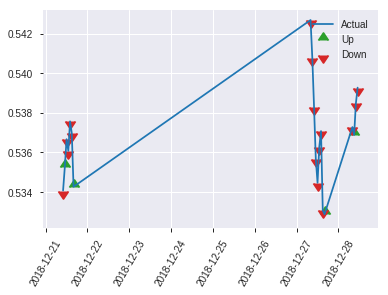


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.19058861932450455
RMSE: 0.4365645648979135
LogLoss: 0.5630203658415923
Mean Per-Class Error: 0.26030242605516785
AUC: 0.7889664340312396
pr_auc: 0.7653105132915452
Gini: 0.5779328680624791
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43683439033552274: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      78   40   0.339    (40.0/118.0)
1      23   79   0.2255   (23.0/102.0)
Total  101  119  0.2864   (63.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.436834     0.714932  118
max f2                       0.191027     0.826377  190
max f0point5                 0.511452     0.758706  74
max accuracy                 0.511452     0.75      74
max precision                0.922213     1         0
max recall                   0.0900424    1         210
max specificity              0.922213     1         0
max absolute_mcc             0.511452     0.504336  74
max min_per_class_accuracy   0.468789     0.70339   106
max mean_per_class_accuracy  0.511452     0.739698  74

Gains/Lift Table: Avg response rate: 46.36 %, avg score: 44.02 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.890773           2.15686   2.15686            1                0.902274   1                           0.902274            0.0294118       0.0294118                  115.686   115.686
    2        0.0227273                   0.888725           1.07843   1.72549            0.5              0.889661   0.8                         0.897229            0.00980392      0.0392157                  7.84314   72.549
    3        0.0318182                   0.878747           2.15686   1.84874            1                0.883759   0.857143                    0.89338             0.0196078       0.0588235                  115.686   84.8739
    4        0.0409091                   0.869294           2.15686   1.91721            1                0.874262   0.888889                    0.889132            0.0196078       0.0784314                  115.686   91.7211
    5        0.05                        0.85783            2.15686   1.96078            1                0.868568   0.909091                    0.885393            0.0196078       0.0980392                  115.686   96.0784
    6        0.1                         0.754051           1.96078   1.96078            0.909091         0.805931   0.909091                    0.845662            0.0980392       0.196078                   96.0784   96.0784
    7        0.15                        0.63062            1.76471   1.89542            0.818182         0.705871   0.878788                    0.799065            0.0882353       0.284314                   76.4706   89.5425
    8        0.2                         0.58313            1.96078   1.91176            0.909091         0.610178   0.886364                    0.751843            0.0980392       0.382353                   96.0784   91.1765
    9        0.3                         0.517817           1.56863   1.79739            0.727273         0.545637   0.833333                    0.683108            0.156863        0.539216                   56.8627   79.7386
    10       0.4                         0.490107           0.882353  1.56863            0.409091         0.504818   0.727273                    0.638535            0.0882353       0.627451                   -11.7647  56.8627
    11       0.5                         0.462087           1.07843   1.47059            0.5              0.477384   0.681818                    0.606305            0.107843        0.735294                   7.84314   47.0588
    12       0.6                         0.402595           0.686275  1.33987            0.318182         0.431208   0.621212                    0.577122            0.0686275       0.803922                   -31.3725  33.9869
    13       0.7                         0.320524           0.588235  1.23249            0.272727         0.364378   0.571429                    0.54673             0.0588235       0.862745                   -41.1765  23.2493
    14       0.8                         0.234038           0.588235  1.15196            0.272727         0.277793   0.534091                    0.513113            0.0588235       0.921569                   -41.1765  15.1961
    15       0.9                         0.16704            0.490196  1.07843            0.227273         0.203017   0.5                         0.478658            0.0490196       0.970588                   -50.9804  7.84314
    16       1                           0.0201562          0.294118  1                  0.136364         0.0943874  0.463636                    

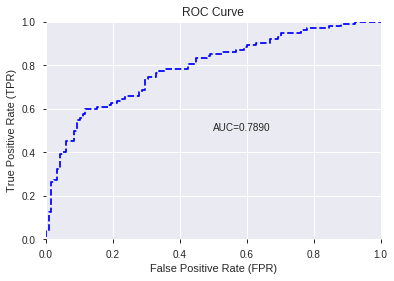

This function is available for GLM models only


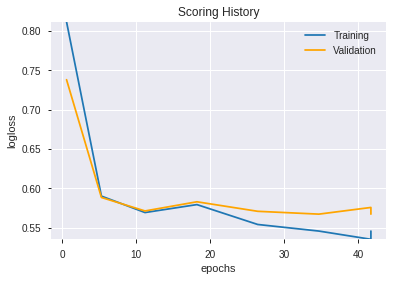

--2019-08-28 15:49:04--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 54.231.112.176
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|54.231.112.176|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_154207_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_154207_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_bf14',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLCLOSINGMARUBOZU',
 'CDLLONGLINE',
 'CDLSHORTLINE',
 'CDLENGULFING',
 'TRANGE',
 'SUB',
 'DIV',
 'CDLDRAGONFLYDOJI',
 'ULTOSC',
 'CDLTAKURI',
 'CORREL_20',
 'aroonup_8',
 'hour',
 'days_in_month',
 'CDLMARUBOZU',
 'Volume',
 'WILLR_30',
 'STOCHRSI_fastd',
 'STOCHF_fastk',
 'weekday_name',
 'DX_8',
 'ADOSC',
 'MINUS_DI_24',
 'CDLBELTHOLD',
 'MINUS_DI_8',
 'weekday',
 'HT_PHASOR_quadrature',
 'dayofweek',
 'DX_20',
 'DX_24',
 'aroonup_30',
 'MINUS_DI_12',
 'STOCH_slowd',
 'DX_14',
 'DX_12',
 'WILLR_12',
 'MINUS_DI_14',
 'MINUS_DI_20',
 'AD',
 'WILLR_24',
 'aroonup_20',
 'STOCHRSI_fastk',
 'weekofyear',
 'dayofyear',
 'WILLR_14',
 'OBV',
 'week',
 'month',
 'WILLR_8']

In [20]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190828_154915_model_1  0.806414  0.546721              0.242522  0.428418  0.183542

variable  relative_importance  scaled_importance  percentage
0                    BOP             0.482114           1.000000    0.120825
1     CDLCLOSINGMARUBOZU             0.228718           0.474406    0.057320
2                 ULTOSC             0.192937           0.400190    0.048353
3                   hour             0.144861           0.300470    0.036304
4              aroonup_8             0.137449           0.285097    0.034447
5                 Volume             0.133283           0.276454    0.033403
6            STOCH_slowd             0.129372           0.268342    0.032422
7            CDLLONGLINE             0.122095           0.253250    0.030599
8           STOCHF_fastk             0.120714           0.250386    0.030253
9                    SUB             0.117815           0.244372    0.029526
10          CDLENGULFING             0.117201           0.243098    0.029372
11              WILLR_30             0.115235           0.239020    0.028880
12        STOCHRSI_fastd             0.115052           0.238640    0.028834
13                   DIV             0.107572           0.223125    0.026959
14             CORREL_20             0.100837           0.209156    0.025271
15            MINUS_DI_8             0.098710           0.204744    0.024738
16            aroonup_30             0.095142           0.197343    0.023844
17      CDLDRAGONFLYDOJI             0.094001           0.194977    0.023558
18             CDLTAKURI             0.093447           0.193827    0.023419
19                  DX_8             0.082370           0.170852    0.020643
20              WILLR_24             0.081536           0.169121    0.020434
21                 ADOSC             0.077681           0.161125    0.019468
22              WILLR_12             0.075641           0.156894    0.018957
23          CDLSHORTLINE             0.074847           0.155247    0.018758
24          weekday_name             0.067218           0.139423    0.016846
25           MINUS_DI_12             0.065549           0.135961    0.016427
26           MINUS_DI_24             0.059915           0.124276    0.015016
27           MINUS_DI_14             0.059457           0.123325    0.014901
28                 DX_12             0.058248           0.120817    0.014598
29           MINUS_DI_20             0.056582           0.117363    0.014180
30  HT_PHASOR_quadrature             0.054128           0.112273    0.013565
31              WILLR_14             0.052960           0.109850    0.013273
32           CDLBELTHOLD             0.050048           0.103810    0.012543
33                 DX_14             0.036677           0.076076    0.009192
34                 DX_20             0.031929           0.066227    0.008002
35                TRANGE             0.031050           0.064403    0.007782
36                   OBV             0.027861           0.057788    0.006982
37         days_in_month             0.023917           0.049608    0.005994
38            aroonup_20             0.021257           0.044091    0.005327
39                 DX_24             0.020561           0.042648    0.005153
40                    AD             0.017540           0.036382    0.004396
41             dayofyear             0.016429           0.034076    0.004117
42                  week             0.016415           0.034047    0.004114
43            weekofyear             0.016360           0.033934    0.004100
44               WILLR_8             0.016327           0.033864    0.004092
45           CDLMARUBOZU             0.015220           0.031568    0.003814
46        STOCHRSI_fastk             0.009269           0.019226    0.002323
47             dayofweek             0.009229           0.019142    0.002313
48               weekday             0.009213           0.019109    0.002309
49                 month             0.008204           0.017016    0.002056

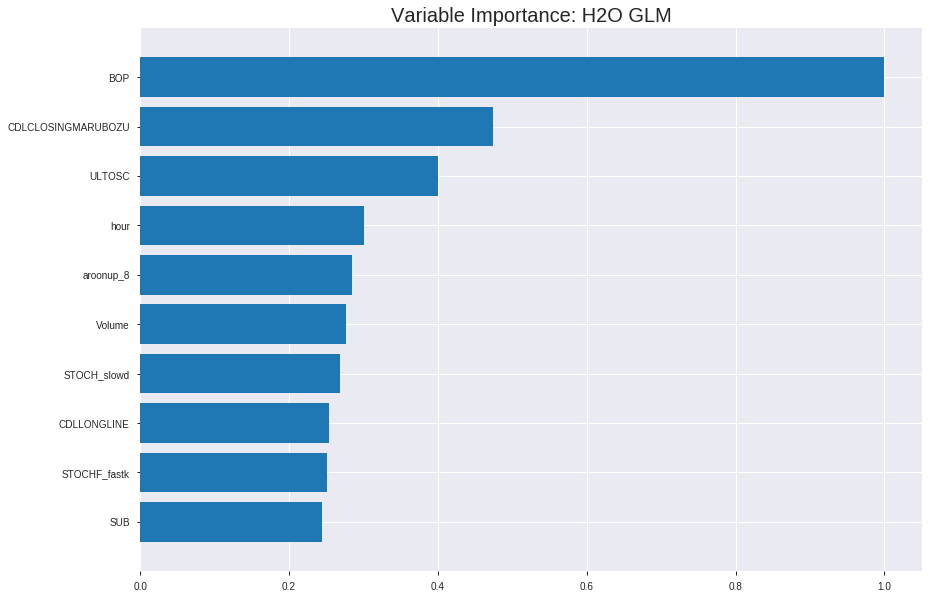

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_154915_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.19279409679446954
RMSE: 0.43908324585944924
LogLoss: 0.5663622706569404
Null degrees of freedom: 1536
Residual degrees of freedom: 1486
Null deviance: 2130.546400580142
Residual deviance: 1740.9976199994353
AIC: 1842.9976199994353
AUC: 0.776182855788119
pr_auc: 0.7700866853775206
Gini: 0.5523657115762379
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39534020502672135: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      403  374   0.4813   (374.0/777.0)
1      109  651   0.1434   (109.0/760.0)
Total  512  1025  0.3142   (483.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.39534      0.729412  255
max f2                       0.238668     0.845555  325
max f0point5                 0.585536     0.702603  152
max accuracy                 0.498586     0.696812  196
max precision                0.937283     1         0
max recall                   0.0579143    1         392
max specificity              0.937283     1         0
max absolute_mcc             0.418771     0.398309  242
max min_per_class_accuracy   0.495791     0.69112   198
max mean_per_class_accuracy  0.498586     0.696732  196

Gains/Lift Table: Avg response rate: 49.45 %, avg score: 49.45 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.90969            1.89597   1.89597            0.9375           0.925009  0.9375                      0.925009            0.0197368       0.0197368                  89.597    89.597
    2        0.0201692                   0.884648           1.88754   1.89189            0.933333         0.896809  0.935484                    0.911364            0.0184211       0.0381579                  88.7544   89.1893
    3        0.0305791                   0.868314           1.89597   1.89328            0.9375           0.878381  0.93617                     0.900136            0.0197368       0.0578947                  89.597    89.3281
    4        0.0403383                   0.855309           2.02237   1.92451            1                0.861568  0.951613                    0.890805            0.0197368       0.0776316                  102.237   92.4512
    5        0.0500976                   0.84148            2.02237   1.94357            1                0.848786  0.961039                    0.882619            0.0197368       0.0973684                  102.237   94.3575
    6        0.100195                    0.783101           1.70719   1.82538            0.844156         0.814225  0.902597                    0.848422            0.0855263       0.182895                   70.7194   82.5384
    7        0.150293                    0.738533           1.68093   1.77723            0.831169         0.760154  0.878788                    0.819               0.0842105       0.267105                   68.093    77.7233
    8        0.20039                     0.699378           1.60214   1.73346            0.792208         0.717803  0.857143                    0.7937              0.0802632       0.347368                   60.2136   73.3459
    9        0.299935                    0.628799           1.21606   1.56174            0.601307         0.662928  0.772234                    0.750299            0.121053        0.468421                   21.6065   56.1742
    10       0.40013                     0.560957           1.1819    1.46663            0.584416         0.594549  0.725203                    0.711298            0.118421        0.586842                   18.1904   46.6628
    11       0.500325                    0.493309           1.07685   1.38857            0.532468         0.528579  0.686606                    0.674707            0.107895        0.694737                   7.68455   38.857
    12       0.59987                     0.43507            1.00458   1.32485            0.496732         0.465081  0.655098                    0.639921            0.1             0.794737                   0.457516  32.4849
    13       0.700065                    0.369327           0.801068  1.24988            0.396104         0.402955  0.61803                     0.606006            0.0802632       0.875                      -19.8932  24.9884
    14       0.79961                     0.297046           0.700559  1.1815             0.346405         0.331941  0.584215                    0.571887            0.0697368       0.944737                   -29.9441  18.1498
    15       0.899805                    0.19054            0.328307  1.08649            0.162338         0.246319  0.537238                    0.535634            0.0328947       0.977632                   -67.1693  8.64929
    16       1                           0.017074           0.223248  1                  0.11039          0.124792  0.49447                     0.49447            



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.19409851523078953
RMSE: 0.4405661303718087
LogLoss: 0.5630233788285599
Null degrees of freedom: 439
Residual degrees of freedom: 389
Null deviance: 609.536667332913
Residual deviance: 495.46057336913265
AIC: 597.4605733691326
AUC: 0.776818078253485
pr_auc: 0.7200443947816115
Gini: 0.5536361565069701
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3102758728147532: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      123  108  0.4675   (108.0/231.0)
1      20   189  0.0957   (20.0/209.0)
Total  143  297  0.2909   (128.0/440.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.310276     0.747036  269
max f2                       0.178902     0.856788  338
max f0point5                 0.451669     0.68999   183
max accuracy                 0.333676     0.709091  254
max precision                0.906045     1         0
max recall                   0.146423     1         350
max specificity              0.906045     1         0
max absolute_mcc             0.310276     0.465682  269
max min_per_class_accuracy   0.430137     0.703349  192
max mean_per_class_accuracy  0.310276     0.718387  269

Gains/Lift Table: Avg response rate: 47.50 %, avg score: 42.93 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113636                   0.876943           1.68421   1.68421            0.8              0.88901    0.8                         0.88901             0.0191388       0.0191388                  68.4211   68.4211
    2        0.0204545                   0.865255           1.57895   1.63743            0.75             0.872254   0.777778                    0.881563            0.0143541       0.0334928                  57.8947   63.7427
    3        0.0318182                   0.860486           2.10526   1.80451            1                0.863749   0.857143                    0.875201            0.0239234       0.0574163                  110.526   80.4511
    4        0.0409091                   0.851889           2.10526   1.87135            1                0.856317   0.888889                    0.871005            0.0191388       0.076555                   110.526   87.1345
    5        0.05                        0.832129           2.10526   1.91388            1                0.839152   0.909091                    0.865213            0.0191388       0.0956938                  110.526   91.3876
    6        0.1                         0.738962           1.43541   1.67464            0.681818         0.772514   0.795455                    0.818863            0.0717703       0.167464                   43.5407   67.4641
    7        0.15                        0.680025           1.62679   1.65869            0.772727         0.710386   0.787879                    0.782704            0.0813397       0.248804                   62.6794   65.8692
    8        0.2                         0.629823           1.62679   1.65072            0.772727         0.658271   0.784091                    0.751596            0.0813397       0.330144                   62.6794   65.0718
    9        0.3                         0.558754           1.19617   1.4992             0.568182         0.593454   0.712121                    0.698882            0.119617        0.449761                   19.6172   49.9203
    10       0.4                         0.490393           1.29187   1.44737            0.613636         0.526211   0.6875                      0.655714            0.129187        0.578947                   29.1866   44.7368
    11       0.5                         0.417424           1.33971   1.42584            0.636364         0.458794   0.677273                    0.61633             0.133971        0.712919                   33.9713   42.5837
    12       0.6                         0.358373           1.10048   1.37161            0.522727         0.388794   0.651515                    0.578408            0.110048        0.822967                   10.0478   37.1611
    13       0.7                         0.289526           0.909091  1.30554            0.431818         0.326421   0.62013                     0.542409            0.0909091       0.913876                   -9.09091  30.5537
    14       0.8                         0.213123           0.478469  1.20215            0.227273         0.24928    0.571023                    0.505768            0.0478469       0.961722                   -52.1531  20.2153
    15       0.9                         0.128201           0.382775  1.11111            0.181818         0.171091   0.527778                    0.468582            0.0382775       1                          -61.7225  11.1111
    16       1                           0.0197455          0         1                  0                0.0754126  0.475                      


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-28 15:49:16  0.000 sec   2            20        51            1.36718           1.36373
    2019-08-28 15:49:16  0.013 sec   4            12        51            1.35741           1.35261
    2019-08-28 15:49:16  0.025 sec   6            7.8       51            1.34378           1.33705
    2019-08-28 15:49:16  0.038 sec   8            4.8       51            1.32582           1.31649
    2019-08-28 15:49:16  0.050 sec   10           3         51            1.30367           1.29108
    2019-08-28 15:49:16  0.065 sec   12           1.9       51            1.2782            1.26192
    2019-08-28 15:49:16  0.077 sec   14           1.2       51            1.2512            1.23128
    2019-08-28 15:49:16  0.092 sec   16           0.72      51            1.22471           1.2019
    2019-08-28 15:49:16  0.109 sec   18           0.45      51            1.20059           1.17634
    2019-08-28 15:49:16  0.121 sec   20           0.28      51            1.17999           1.15618
    2019-08-28 15:49:16  0.134 sec   22           0.17      51            1.16327           1.14181
    2019-08-28 15:49:16  0.147 sec   24           0.11      51            1.15017           1.13271
    2019-08-28 15:49:16  0.160 sec   26           0.066     51            1.14019           1.12787
    2019-08-28 15:49:16  0.181 sec   28           0.041     51            1.13272           1.12605
    2019-08-28 15:49:16  0.197 sec   30           0.026     51            1.12719           1.12607
    2019-08-28 15:49:16  0.210 sec   32           0.016     51            1.12312           1.12714
    2019-08-28 15:49:16  0.223 sec   34           0.0098    51            1.1202            1.12863
    2019-08-28 15:49:16  0.235 sec   36           0.0061    51            1.11813           1.13027
    2019-08-28 15:49:16  0.248 sec   38           0.0038    51            1.11671           1.13183

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.759090909090909)

('F1', 0.7389162561576355)

('auc', 0.8064140910601528)

('logloss', 0.5467212862030394)

('mean_per_class_error', 0.24252243270189422)

('rmse', 0.42841781716337146)

('mse', 0.18354182606302796)

glm prediction progress: |████████████████████████████████████████████████| 100%


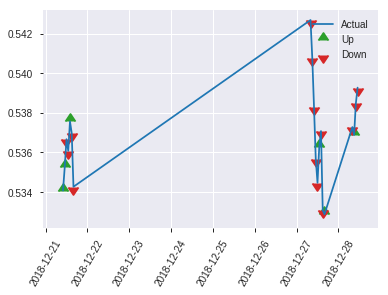


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.18354182606302796
RMSE: 0.42841781716337146
LogLoss: 0.5467212862030394
Null degrees of freedom: 219
Residual degrees of freedom: 169
Null deviance: 304.6577240810208
Residual deviance: 240.55736592933732
AIC: 342.5573659293373
AUC: 0.8064140910601528
pr_auc: 0.7607105986392874
Gini: 0.6128281821203057
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42776270904026004: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      92   26   0.2203   (26.0/118.0)
1      27   75   0.2647   (27.0/102.0)
Total  119  101  0.2409   (53.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.427763     0.738916  100
max f2                       0.235683     0.831874  162
max f0point5                 0.481111     0.755814  81
max accuracy                 0.450676     0.759091  90
max precision                0.887481     1         0
max recall                   0.0964894    1         205
max specificity              0.887481     1         0
max absolute_mcc             0.427763     0.515319  100
max min_per_class_accuracy   0.406177     0.745098  103
max mean_per_class_accuracy  0.427763     0.757478  100

Gains/Lift Table: Avg response rate: 46.36 %, avg score: 40.58 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.865894           2.15686   2.15686            1                0.882485   1                           0.882485            0.0294118       0.0294118                  115.686   115.686
    2        0.0227273                   0.827459           1.07843   1.72549            0.5              0.833654   0.8                         0.862952            0.00980392      0.0392157                  7.84314   72.549
    3        0.0318182                   0.81686            2.15686   1.84874            1                0.818799   0.857143                    0.850337            0.0196078       0.0588235                  115.686   84.8739
    4        0.0409091                   0.806543           2.15686   1.91721            1                0.813074   0.888889                    0.842056            0.0196078       0.0784314                  115.686   91.7211
    5        0.05                        0.785808           1.07843   1.76471            0.5              0.801777   0.818182                    0.834733            0.00980392      0.0882353                  7.84314   76.4706
    6        0.1                         0.733819           1.96078   1.86275            0.909091         0.754217   0.863636                    0.794475            0.0980392       0.186275                   96.0784   86.2745
    7        0.15                        0.653064           1.96078   1.89542            0.909091         0.68973    0.878788                    0.75956             0.0980392       0.284314                   96.0784   89.5425
    8        0.2                         0.626305           1.76471   1.86275            0.818182         0.640475   0.863636                    0.729789            0.0882353       0.372549                   76.4706   86.2745
    9        0.3                         0.545642           1.56863   1.76471            0.727273         0.589008   0.818182                    0.682862            0.156863        0.529412                   56.8627   76.4706
    10       0.4                         0.453688           1.27451   1.64216            0.590909         0.501719   0.761364                    0.637576            0.127451        0.656863                   27.451    64.2157
    11       0.5                         0.366675           0.980392  1.5098             0.454545         0.42101    0.7                         0.594263            0.0980392       0.754902                   -1.96078  50.9804
    12       0.6                         0.314475           0.490196  1.33987            0.227273         0.340762   0.621212                    0.552013            0.0490196       0.803922                   -50.9804  33.9869
    13       0.7                         0.268349           0.882353  1.27451            0.409091         0.291325   0.590909                    0.514772            0.0882353       0.892157                   -11.7647  27.451
    14       0.8                         0.198421           0.490196  1.17647            0.227273         0.229821   0.545455                    0.479153            0.0490196       0.941176                   -50.9804  17.6471
    15       0.9                         0.121311           0.392157  1.08932            0.181818         0.15325    0.505051                    0.442941            0.0392157       0.980392                   -60.7843  8.93246
    16       1                           0.0129919          0.196078  1                  0.0909091        0.0713909  0.463636                    0

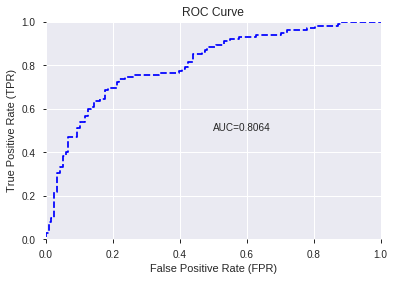

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


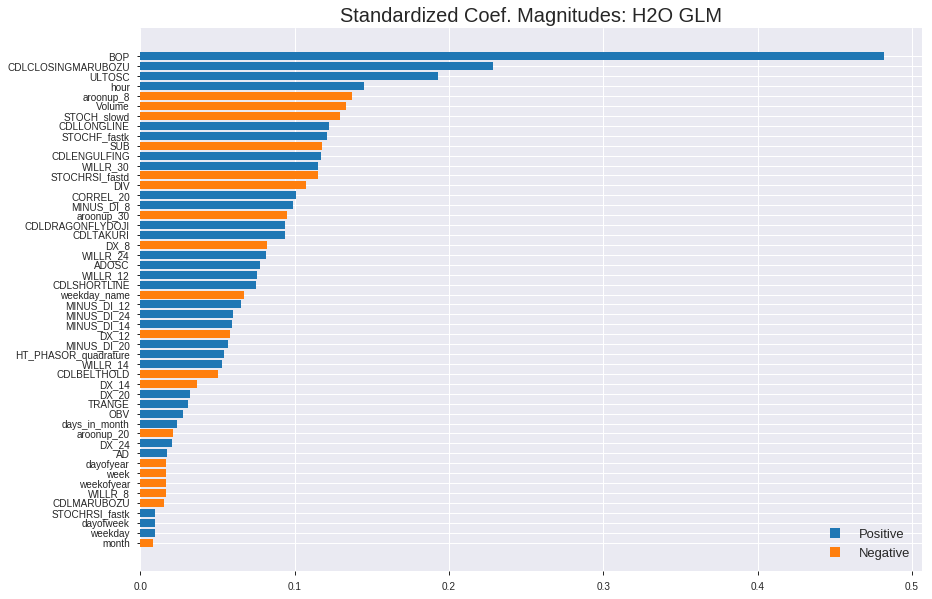

'log_likelihood'
--2019-08-28 15:49:22--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.166.59
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.166.59|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_154915_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_154915_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_bf14',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['BOP',
 'CDLCLOSINGMARUBOZU',
 'ULTOSC',
 'hour',
 'aroonup_8',
 'Volume',
 'STOCH_slowd',
 'CDLLONGLINE',
 'STOCHF_fastk',
 'SUB',
 'CDLENGULFING',
 'WILLR_30',
 'STOCHRSI_fastd',
 'DIV',
 'CORREL_20',
 'MINUS_DI_8',
 'aroonup_30',
 'CDLDRAGONFLYDOJI',
 'CDLTAKURI',
 'DX_8',
 'WILLR_24',
 'ADOSC',
 'WILLR_12',
 'CDLSHORTLINE',
 'weekday_name',
 'MINUS_DI_12',
 'MINUS_DI_24',
 'MINUS_DI_14',
 'DX_12',
 'MINUS_DI_20',
 'HT_PHASOR_quadrature',
 'WILLR_14',
 'CDLBELTHOLD',
 'DX_14',
 'DX_20',
 'TRANGE',
 'OBV',
 'days_in_month',
 'aroonup_20',
 'DX_24',
 'AD',
 'dayofyear',
 'week',
 'weekofyear',
 'WILLR_8',
 'CDLMARUBOZU',
 'STOCHRSI_fastk',
 'dayofweek',
 'weekday',
 'month']

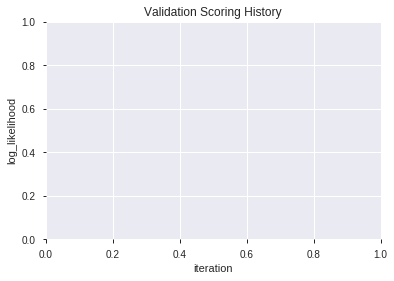

In [21]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190828_154932_model_4  0.781738  0.564504              0.259721  0.435780  0.189904
1  XGBoost_grid_1_AutoML_20190828_154932_model_3  0.777750  0.565280              0.314639  0.438045  0.191884
2  XGBoost_grid_1_AutoML_20190828_154932_model_2  0.766783  0.587721              0.312147  0.447995  0.200699
3               XGBoost_2_AutoML_20190828_154932  0.763626  0.576873              0.301429  0.443745  0.196909
4  XGBoost_grid_1_AutoML_20190828_154932_model_1  0.761715  0.583849              0.340063  0.445947  0.198869
5               XGBoost_3_AutoML_20190828_154932  0.750415  0.590234              0.338900  0.450579  0.203022
6               XGBoost_1_AutoML_20190828_154932  0.747341  0.592311              0.294699  0.450511  0.202960
7  XGBoost_grid_1_AutoML_20190828_154932_model_6  0.745347  0.594410              0.305417  0.452495  0.204752
8  XGBoost_grid_1_AutoML_20190828_154932_model_7  0.744849  0.590940              0.359920  0.451559  0.203906
9  XGBoost_grid_1_AutoML_20190828_154932_model_5  0.706630  0.627328              0.366152  0.469065  0.220022

variable  relative_importance  scaled_importance  percentage
0                    BOP          1909.725220           1.000000    0.421706
1                    DIV           305.011963           0.159715    0.067353
2                 TRANGE           275.357330           0.144187    0.060804
3           STOCHF_fastk           241.269104           0.126337    0.053277
4              CORREL_20           132.706726           0.069490    0.029304
5                   hour           130.214050           0.068185    0.028754
6                  ADOSC           117.418610           0.061485    0.025928
7                 ULTOSC           113.121651           0.059235    0.024980
8                    SUB           110.186020           0.057697    0.024331
9              aroonup_8           108.479912           0.056804    0.023955
10                  DX_8            91.229546           0.047771    0.020145
11            MINUS_DI_8            88.622147           0.046406    0.019570
12                 DX_24            75.699791           0.039639    0.016716
13                Volume            72.338120           0.037879    0.015974
14        STOCHRSI_fastd            60.751888           0.031812    0.013415
15                   OBV            60.602135           0.031733    0.013382
16  HT_PHASOR_quadrature            53.904652           0.028226    0.011903
17           MINUS_DI_20            53.897190           0.028222    0.011902
18           STOCH_slowd            52.356987           0.027416    0.011561
19               WILLR_8            46.225163           0.024205    0.010207
20              WILLR_12            43.826927           0.022949    0.009678
21                 DX_12            42.442520           0.022224    0.009372
22            aroonup_20            37.939716           0.019867    0.008378
23           MINUS_DI_14            32.538593           0.017038    0.007185
24        STOCHRSI_fastk            30.352253           0.015894    0.006702
25              WILLR_24            30.156078           0.015791    0.006659
26                 DX_20            28.997456           0.015184    0.006403
27           MINUS_DI_24            26.194553           0.013716    0.005784
28           MINUS_DI_12            25.853840           0.013538    0.005709
29              WILLR_30            23.820824           0.012473    0.005260
30             dayofyear            22.578396           0.011823    0.004986
31             dayofweek            21.398510           0.011205    0.004725
32            aroonup_30            19.125309           0.010015    0.004223
33                    AD            13.837915           0.007246    0.003056
34          weekday_name            10.454755           0.005474    0.002309
35              WILLR_14            10.096214           0.005287    0.002229
36         days_in_month             6.386635           0.003344    0.001410
37                  week             3.456020           0.001810    0.000763

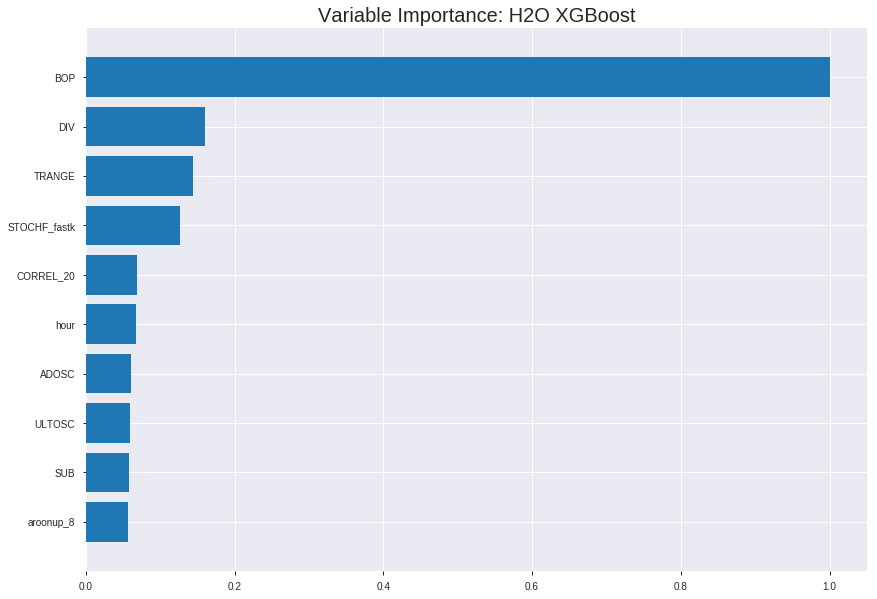

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190828_154932_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.17591460723537303
RMSE: 0.4194217534122104
LogLoss: 0.5299191038772241
Mean Per-Class Error: 0.24875364085890395
AUC: 0.8245148343832555
pr_auc: 0.8213114042595387
Gini: 0.6490296687665109
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.33762548863887787: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      368  409   0.5264   (409.0/777.0)
1      60   700   0.0789   (60.0/760.0)
Total  428  1109  0.3051   (469.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.337625     0.749064  280
max f2                       0.285188     0.85574   311
max f0point5                 0.603089     0.758808  142
max accuracy                 0.519957     0.751464  186
max precision                0.892956     1         0
max recall                   0.158757     1         371
max specificity              0.892956     1         0
max absolute_mcc             0.519957     0.502969  186
max min_per_class_accuracy   0.503064     0.746461  196
max mean_per_class_accuracy  0.519957     0.751246  186

Gains/Lift Table: Avg response rate: 49.45 %, avg score: 49.55 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.860458           2.02237    2.02237            1                0.872122  1                           0.872122            0.0210526       0.0210526                  102.237   102.237
    2        0.0201692                   0.845084           2.02237    2.02237            1                0.85208   1                           0.862424            0.0197368       0.0407895                  102.237   102.237
    3        0.0305791                   0.831048           2.02237    2.02237            1                0.836576  1                           0.853625            0.0210526       0.0618421                  102.237   102.237
    4        0.0403383                   0.823093           1.88754    1.98975            0.933333         0.826819  0.983871                    0.84714             0.0184211       0.0802632                  88.7544   98.975
    5        0.0500976                   0.81587            2.02237    1.9961             1                0.820129  0.987013                    0.841878            0.0197368       0.1                        102.237   99.6104
    6        0.100195                    0.77725            1.73346    1.86478            0.857143         0.794401  0.922078                    0.81814             0.0868421       0.186842                   73.3459   86.4781
    7        0.150293                    0.745054           1.81225    1.84727            0.896104         0.762848  0.91342                     0.799709            0.0907895       0.277632                   81.2252   84.7272
    8        0.20039                     0.71578            1.68093    1.80569            0.831169         0.73011   0.892857                    0.782309            0.0842105       0.361842                   68.093    80.5686
    9        0.299935                    0.63896            1.5333     1.71528            0.75817          0.678392  0.848156                    0.74782             0.152632        0.514474                   53.3299   71.5284
    10       0.40013                     0.575615           1.2213     1.59159            0.603896         0.606258  0.786992                    0.712372            0.122368        0.636842                   22.13     59.1588
    11       0.500325                    0.499513           1.11624    1.49639            0.551948         0.539303  0.739922                    0.677713            0.111842        0.748684                   11.6242   49.6395
    12       0.59987                     0.422667           0.740213   1.37091            0.366013         0.460625  0.677874                    0.641689            0.0736842       0.822368                   -25.9787  37.0911
    13       0.700065                    0.355701           0.801068   1.28935            0.396104         0.386406  0.637546                    0.605152            0.0802632       0.902632                   -19.8932  28.9354
    14       0.79961                     0.28962            0.581596   1.20124            0.287582         0.319353  0.593979                    0.569573            0.0578947       0.960526                   -41.8404  20.1244
    15       0.899805                    0.199229           0.315174   1.10258            0.155844         0.244701  0.545192                    0.533398            0.0315789       0.992105                   -68.4826  10.2578
    16       1                           0.0958233          0.0787936  1                  0.038961         0.154927  0.49447                     



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.19954317124118065
RMSE: 0.44670255343033427
LogLoss: 0.581514539679395
Mean Per-Class Error: 0.303485987696514
AUC: 0.7621843865863004
pr_auc: 0.7056517689849333
Gini: 0.5243687731726008
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2742305099964142: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      102  129  0.5584   (129.0/231.0)
1      17   192  0.0813   (17.0/209.0)
Total  119  321  0.3318   (146.0/440.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.274231     0.724528  295
max f2                       0.18756      0.853256  345
max f0point5                 0.531548     0.677026  161
max accuracy                 0.43973      0.695455  207
max precision                0.862158     1         0
max recall                   0.135249     1         379
max specificity              0.862158     1         0
max absolute_mcc             0.274231     0.404967  295
max min_per_class_accuracy   0.45935      0.684211  196
max mean_per_class_accuracy  0.43973      0.696514  207

Gains/Lift Table: Avg response rate: 47.50 %, avg score: 44.91 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113636                   0.835814           1.26316    1.26316            0.6              0.845717  0.6                         0.845717            0.0143541       0.0143541                  26.3158   26.3158
    2        0.0204545                   0.825029           2.10526    1.63743            1                0.832885  0.777778                    0.840014            0.0191388       0.0334928                  110.526   63.7427
    3        0.0318182                   0.812782           2.10526    1.80451            1                0.819638  0.857143                    0.832737            0.0239234       0.0574163                  110.526   80.4511
    4        0.0409091                   0.797541           1.57895    1.75439            0.75             0.807928  0.833333                    0.827223            0.0143541       0.0717703                  57.8947   75.4386
    5        0.05                        0.786679           1.57895    1.72249            0.75             0.792638  0.818182                    0.820935            0.0143541       0.0861244                  57.8947   72.2488
    6        0.1                         0.741854           1.81818    1.77033            0.863636         0.762711  0.840909                    0.791823            0.0909091       0.177033                   81.8182   77.0335
    7        0.15                        0.699163           1.33971    1.62679            0.636364         0.716362  0.772727                    0.766669            0.0669856       0.244019                   33.9713   62.6794
    8        0.2                         0.672547           1.43541    1.57895            0.681818         0.685106  0.75                        0.746279            0.0717703       0.315789                   43.5407   57.8947
    9        0.3                         0.594635           1.43541    1.5311             0.681818         0.637011  0.727273                    0.709856            0.143541        0.45933                    43.5407   53.11
    10       0.4                         0.527298           1.29187    1.47129            0.613636         0.561872  0.698864                    0.67286             0.129187        0.588517                   29.1866   47.1292
    11       0.5                         0.4439             1.14833    1.4067             0.545455         0.488315  0.668182                    0.635951            0.114833        0.703349                   14.8325   40.6699
    12       0.6                         0.366825           0.909091   1.32376            0.431818         0.403168  0.628788                    0.597154            0.0909091       0.794258                   -9.09091  32.3764
    13       0.7                         0.302212           0.909091   1.26452            0.431818         0.330658  0.600649                    0.559083            0.0909091       0.885167                   -9.09091  26.4525
    14       0.8                         0.213522           0.62201    1.18421            0.295455         0.254809  0.5625                      0.521049            0.062201        0.947368                   -37.799   18.4211
    15       0.9                         0.162556           0.430622   1.10048            0.204545         0.187675  0.522727                    0.484007            0.0430622       0.990431                   -56.9378  10.0478
    16       1                           0.108733           0.0956938  1                  0.0454545        0.13485   0.475                       0


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 15:49:41  3.366 sec   0                  0.5              0.693147            0.5             0                  1                0.50553                          0.5                0.693147              0.5               0                    1                  0.525
    2019-08-28 15:49:41  3.476 sec   5                  0.47858          0.650975            0.782213        0.742362           1.87256          0.321405                         0.480104           0.653877              0.751155          0.677685             2.10526            0.306818
    2019-08-28 15:49:41  3.538 sec   10                 0.46377          0.622015            0.785572        0.768602           2.02237          0.330514                         0.466472           0.626975              0.757669          0.698555             1.75439            0.315909
    2019-08-28 15:49:41  3.599 sec   15                 0.454064         0.602808            0.791309        0.776866           1.89597          0.301887                         0.457815           0.609408              0.762443          0.713942             1.68421            0.306818
    2019-08-28 15:49:41  3.655 sec   20                 0.446242         0.586987            0.797307        0.787909           2.02237          0.319453                         0.452945           0.598741              0.761863          0.718816             2.10526            0.304545
    2019-08-28 15:49:41  3.716 sec   25                 0.440294         0.574657            0.801084        0.791014           2.02237          0.307742                         0.449919           0.591927              0.763168          0.720516             2.10526            0.302273
    2019-08-28 15:49:41  3.777 sec   30                 0.435775         0.565201            0.805416        0.799819           2.02237          0.319453                         0.447789           0.586834              0.7641            0.719657             1.68421            0.315909
    2019-08-28 15:49:41  3.843 sec   35                 0.432429         0.558036            0.807794        0.8016             2.02237          0.283019                         0.445971           0.58249               0.766876          0.720995             1.68421            0.309091
    2019-08-28 15:49:41  3.906 sec   40                 0.428865         0.550451            0.812268        0.803501           2.02237          0.300586                         0.444977           0.579832              0.767062          0.71739              1.68421            0.306818
    2019-08-28 15:49:41  3.971 sec   45                 0.426159         0.544599            0.81521         0.810384           2.02237          0.299935                         0.445243           0.579942              0.766068          0.715508             1.68421            0.322727
    2019-08-28 15:49:41  4.056 sec   50                 0.423386         0.538706            0.819745        0.815898           2.02237          0.258946                         0.444724           0.57831               0.766296          0.714301             1.68421            0.322727
    2019-08-28 15:49:41  4.136 sec   55                 0.421269         0.534048            0.822152        0.819241           2.02237          0.260898                         0.445897           0.58029               0.7635            0.71

Variable Importances: 


variable       relative_importance    scaled_importance      percentage
-------------  ---------------------  ---------------------  ---------------------
BOP            1909.7252197265625     1.0                    0.4217055782115237
DIV            305.011962890625       0.15971510442444548    0.06735275046042467
TRANGE         275.3573303222656      0.14418688483450603    0.060804413639653755
STOCHF_fastk   241.26910400390625     0.12633707797944435    0.05327705051887595
CORREL_20      132.70672607421875     0.06948995839999428    0.029304303086964315
---            ---                    ---                    ---
AD             13.837915420532227     0.007246024337738788   0.0030556888830809087
weekday_name   10.454754829406738     0.005474481208822109   0.0023086192635744483
WILLR_14       10.096214294433594     0.005286736641556834   0.0022294463322797735
days_in_month  6.386634826660156      0.0033442689873334785  0.0014102968869983315
week           3.4560203552246094     0.0018096950909615404  0.0007631585147204925


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7454545454545455)

('F1', 0.7363636363636364)

('auc', 0.7817381189764041)

('logloss', 0.5645044255039989)

('mean_per_class_error', 0.25589896975739457)

('rmse', 0.43578017100333155)

('mse', 0.1899043574396929)

xgboost prediction progress: |████████████████████████████████████████████| 100%


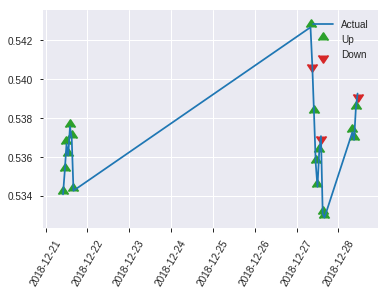


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.1899043574396929
RMSE: 0.43578017100333155
LogLoss: 0.5645044255039989
Mean Per-Class Error: 0.25589896975739457
AUC: 0.7817381189764041
pr_auc: 0.6967059273982793
Gini: 0.5634762379528082
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41014954447746277: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      81   37   0.3136   (37.0/118.0)
1      21   81   0.2059   (21.0/102.0)
Total  102  118  0.2636   (58.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.41015      0.736364  117
max f2                       0.241373     0.837563  182
max f0point5                 0.514609     0.734043  91
max accuracy                 0.514609     0.745455  91
max precision                0.850413     1         0
max recall                   0.168162     1         206
max specificity              0.850413     1         0
max absolute_mcc             0.453994     0.488202  101
max min_per_class_accuracy   0.439672     0.728814  106
max mean_per_class_accuracy  0.453994     0.744101  101

Gains/Lift Table: Avg response rate: 46.36 %, avg score: 46.83 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.836903           1.43791   1.43791            0.666667         0.842543  0.666667                    0.842543            0.0196078       0.0196078                  43.7908   43.7908
    2        0.0227273                   0.834465           1.07843   1.29412            0.5              0.834973  0.6                         0.839515            0.00980392      0.0294118                  7.84314   29.4118
    3        0.0318182                   0.826443           1.07843   1.23249            0.5              0.831714  0.571429                    0.837286            0.00980392      0.0392157                  7.84314   23.2493
    4        0.0409091                   0.821462           2.15686   1.43791            1                0.823917  0.666667                    0.834316            0.0196078       0.0588235                  115.686   43.7908
    5        0.05                        0.811152           2.15686   1.56863            1                0.816303  0.727273                    0.83104             0.0196078       0.0784314                  115.686   56.8627
    6        0.1                         0.756627           1.76471   1.66667            0.818182         0.783696  0.772727                    0.807368            0.0882353       0.166667                   76.4706   66.6667
    7        0.15                        0.731055           1.56863   1.63399            0.727273         0.74321   0.757576                    0.785982            0.0784314       0.245098                   56.8627   63.3987
    8        0.2                         0.688164           1.76471   1.66667            0.818182         0.714728  0.772727                    0.768169            0.0882353       0.333333                   76.4706   66.6667
    9        0.3                         0.613102           1.56863   1.63399            0.727273         0.657102  0.757576                    0.731147            0.156863        0.490196                   56.8627   63.3987
    10       0.4                         0.527084           1.56863   1.61765            0.727273         0.576268  0.75                        0.692427            0.156863        0.647059                   56.8627   61.7647
    11       0.5                         0.430765           0.980392  1.4902             0.454545         0.477567  0.690909                    0.649455            0.0980392       0.745098                   -1.96078  49.0196
    12       0.6                         0.370426           0.686275  1.35621            0.318182         0.400212  0.628788                    0.607914            0.0686275       0.813725                   -31.3725  35.6209
    13       0.7                         0.329193           0.588235  1.2465             0.272727         0.347253  0.577922                    0.570677            0.0588235       0.872549                   -41.1765  24.6499
    14       0.8                         0.280085           0.686275  1.17647            0.318182         0.306851  0.545455                    0.537699            0.0686275       0.941176                   -31.3725  17.6471
    15       0.9                         0.19176            0.392157  1.08932            0.181818         0.22888   0.505051                    0.503386            0.0392157       0.980392                   -60.7843  8.93246
    16       1                           0.108431           0.196078  1                  0.0909091        0.152991  0.463636                    0.468346         

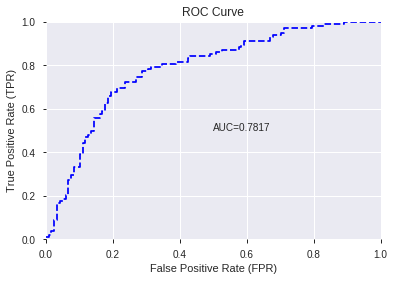

This function is available for GLM models only


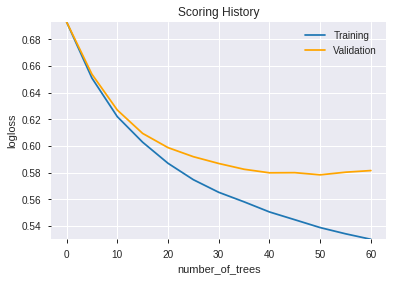

--2019-08-28 15:49:54--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.102.11
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.102.11|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190828_154932_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190828_154932_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_bf14',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'DIV',
 'TRANGE',
 'STOCHF_fastk',
 'CORREL_20',
 'hour',
 'ADOSC',
 'ULTOSC',
 'SUB',
 'aroonup_8',
 'DX_8',
 'MINUS_DI_8',
 'DX_24',
 'Volume',
 'STOCHRSI_fastd',
 'OBV',
 'HT_PHASOR_quadrature',
 'MINUS_DI_20',
 'STOCH_slowd',
 'WILLR_8',
 'WILLR_12',
 'DX_12',
 'aroonup_20',
 'MINUS_DI_14',
 'STOCHRSI_fastk',
 'WILLR_24',
 'DX_20',
 'MINUS_DI_24',
 'MINUS_DI_12',
 'WILLR_30',
 'dayofyear',
 'dayofweek',
 'aroonup_30',
 'AD',
 'weekday_name',
 'WILLR_14',
 'days_in_month',
 'week']

In [22]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [24]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [25]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [26]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [28]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [29]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [30]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [32]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [33]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [34]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [36]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [37]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [38]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [40]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [41]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [42]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [44]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [45]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [46]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [47]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [ 12 894 924] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


34

['Volume',
 'BOP',
 'CCI_8',
 'CMO_8',
 'MOM_8',
 'ROC_8',
 'ROCP_8',
 'ROCR_8',
 'ROCR100_8',
 'RSI_8',
 'WILLR_8',
 'CCI_12',
 'CMO_12',
 'RSI_12',
 'WILLR_12',
 'CMO_14',
 'RSI_14',
 'WILLR_14',
 'WILLR_20',
 'WILLR_24',
 'WILLR_30',
 'STOCHF_fastk',
 'STOCHRSI_fastk',
 'ULTOSC',
 'ADOSC',
 'TRANGE',
 'CDLBELTHOLD',
 'CDLCLOSINGMARUBOZU',
 'CDLENGULFING',
 'CDLLONGLINE',
 'CDLMARUBOZU',
 'CDLSHORTLINE',
 'DIV',
 'SUB']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_155006_model_9  0.815886  0.544779              0.226487  0.426074  0.181539
1  DeepLearning_grid_1_AutoML_20190828_155006_model_6  0.812147  0.555827              0.248588  0.429530  0.184496
2  DeepLearning_grid_1_AutoML_20190828_155006_model_8  0.804752  0.551346              0.251246  0.428435  0.183556
3               DeepLearning_1_AutoML_20190828_155006  0.802925  0.536346              0.258391  0.426405  0.181822
4  DeepLearning_grid_1_AutoML_20190828_155006_model_5  0.794699  0.553591              0.263044  0.430342  0.185195
5  DeepLearning_grid_1_AutoML_20190828_155006_model_3  0.776919  0.622304              0.293204  0.445291  0.198284
6  DeepLearning_grid_1_AutoML_20190828_155006_model_7  0.750000  0.717162              0.323114  0.488719  0.238847
7  DeepLearning_grid_1_AutoML_20190828_155006_model_2  0.743935  0.657675              0.332253  0.468920  0.219886
8  DeepLearning_grid_1_AutoML_20190828_155006_model_4  0.697075  0.794180              0.353190  0.504393  0.254412
9  DeepLearning_grid_1_AutoML_20190828_155006_model_1  0.674892  0.931287              0.337820  0.511847  0.261987

variable  relative_importance  scaled_importance  percentage
0                  BOP             1.000000           1.000000    0.060987
1   CDLCLOSINGMARUBOZU             0.764866           0.764866    0.046647
2          CDLLONGLINE             0.708847           0.708847    0.043231
3                  SUB             0.598577           0.598577    0.036506
4                  DIV             0.554991           0.554991    0.033847
5         CDLSHORTLINE             0.540770           0.540770    0.032980
6               TRANGE             0.533747           0.533747    0.032552
7         CDLENGULFING             0.524467           0.524467    0.031986
8                CCI_8             0.492683           0.492683    0.030047
9               ULTOSC             0.491527           0.491527    0.029977
10        STOCHF_fastk             0.480613           0.480613    0.029311
11               ADOSC             0.477010           0.477010    0.029092
12         CDLBELTHOLD             0.471051           0.471051    0.028728
13              CCI_12             0.469821           0.469821    0.028653
14              Volume             0.463698           0.463698    0.028280
15         CDLMARUBOZU             0.442712           0.442712    0.027000
16           ROCR100_8             0.428449           0.428449    0.026130
17              CMO_12             0.425381           0.425381    0.025943
18      STOCHRSI_fastk             0.424378           0.424378    0.025882
19               MOM_8             0.423878           0.423878    0.025851
20            WILLR_14             0.422530           0.422530    0.025769
21            WILLR_24             0.419612           0.419612    0.025591
22              RSI_12             0.412703           0.412703    0.025170
23            WILLR_12             0.411746           0.411746    0.025111
24              ROCR_8             0.410155           0.410155    0.025014
25              ROCP_8             0.409181           0.409181    0.024955
26            WILLR_20             0.408895           0.408895    0.024937
27               ROC_8             0.406503           0.406503    0.024792
28               RSI_8             0.402721           0.402721    0.024561
29            WILLR_30             0.398757           0.398757    0.024319
30              RSI_14             0.397993           0.397993    0.024273
31               CMO_8             0.397741           0.397741    0.024257
32              CMO_14             0.395634           0.395634    0.024129
33             WILLR_8             0.385198           0.385198    0.023492

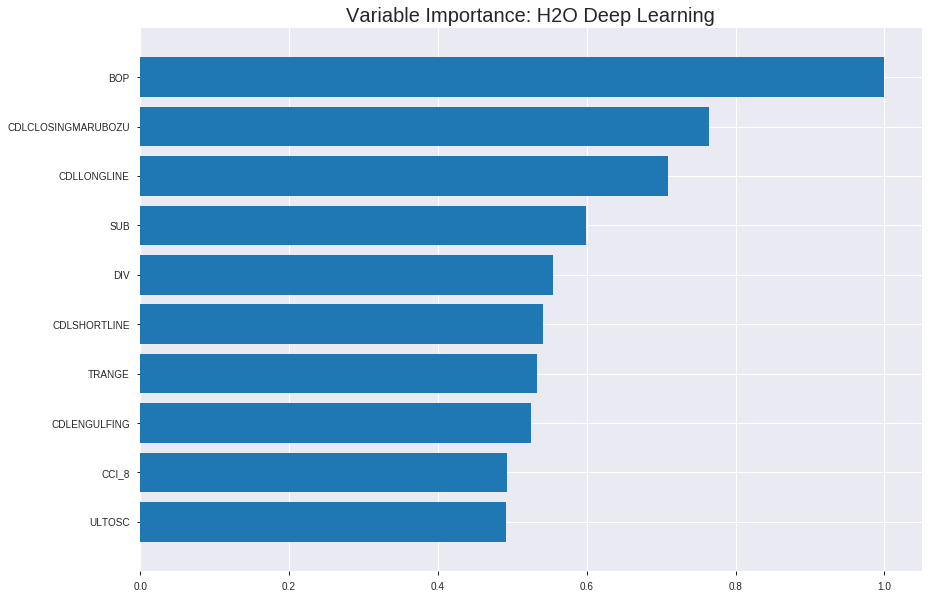

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_155006_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.20017646902653097
RMSE: 0.447410850367457
LogLoss: 0.583949165187941
Mean Per-Class Error: 0.3077338616812302
AUC: 0.7591995190679401
pr_auc: 0.7519606139151241
Gini: 0.5183990381358803
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4509289703593725: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      410  367  0.4723   (367.0/777.0)
1      131  629  0.1724   (131.0/760.0)
Total  541  996  0.324    (498.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.450929     0.716401  236
max f2                       0.200652     0.839358  350
max f0point5                 0.546514     0.698626  165
max accuracy                 0.522659     0.692908  182
max precision                0.941588     1         0
max recall                   0.108885     1         395
max specificity              0.941588     1         0
max absolute_mcc             0.522659     0.387325  182
max min_per_class_accuracy   0.509639     0.688546  193
max mean_per_class_accuracy  0.522659     0.692266  182

Gains/Lift Table: Avg response rate: 49.45 %, avg score: 51.24 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.932537           1.89597   1.89597            0.9375           0.936333  0.9375                      0.936333            0.0197368       0.0197368                  89.597    89.597
    2        0.0201692                   0.926742           1.61789   1.76142            0.8              0.928978  0.870968                    0.932774            0.0157895       0.0355263                  61.7895   76.1418
    3        0.0305791                   0.916669           1.76957   1.76419            0.875            0.922185  0.87234                     0.929169            0.0184211       0.0539474                  76.9572   76.4194
    4        0.0403383                   0.891721           2.02237   1.82666            1                0.90399   0.903226                    0.923078            0.0197368       0.0736842                  102.237   82.6655
    5        0.0500976                   0.868546           1.88754   1.83852            0.933333         0.880328  0.909091                    0.91475             0.0184211       0.0921053                  88.7544   83.8517
    6        0.100195                    0.831215           1.81225   1.82538            0.896104         0.849018  0.902597                    0.881884            0.0907895       0.182895                   81.2252   82.5384
    7        0.150293                    0.776732           1.60214   1.75097            0.792208         0.806909  0.865801                    0.856892            0.0802632       0.263158                   60.2136   75.0968
    8        0.20039                     0.703689           1.31323   1.64153            0.649351         0.742298  0.811688                    0.828244            0.0657895       0.328947                   31.3226   64.1533
    9        0.299935                    0.604526           1.32181   1.53542            0.653595         0.651838  0.759219                    0.769697            0.131579        0.460526                   32.1809   53.5421
    10       0.40013                     0.535068           1.23443   1.46005            0.61039          0.563597  0.721951                    0.718088            0.123684        0.584211                   23.4433   46.0051
    11       0.500325                    0.50868            1.05058   1.37805            0.519481         0.520379  0.681404                    0.678495            0.105263        0.689474                   5.0581    37.8051
    12       0.59987                     0.474451           0.938485  1.30511            0.464052         0.491807  0.645336                    0.647515            0.0934211       0.782895                   -6.15153  30.5108
    13       0.700065                    0.421531           0.748539  1.22545            0.37013          0.448171  0.605948                    0.618985            0.075           0.857895                   -25.1461  22.545
    14       0.79961                     0.322329           0.687341  1.15846            0.339869         0.378638  0.572823                    0.589064            0.0684211       0.926316                   -31.2659  15.846
    15       0.899805                    0.20164            0.499026  1.08503            0.246753         0.255043  0.536515                    0.55187             0.05            0.976316                   -50.0974  8.50306
    16       1                           0.0581009          0.236381  1                  0.116883         0.157724  0.49447                     0.512378            



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.19156450876320338
RMSE: 0.43768082978719025
LogLoss: 0.5616310850982755
Mean Per-Class Error: 0.2848029163818637
AUC: 0.7830630294745128
pr_auc: 0.7443386584883303
Gini: 0.5661260589490256
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3870857724907492: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      126  105  0.4545   (105.0/231.0)
1      27   182  0.1292   (27.0/209.0)
Total  153  287  0.3      (132.0/440.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.387086     0.733871  258
max f2                       0.191073     0.853158  347
max f0point5                 0.520147     0.699888  158
max accuracy                 0.448849     0.709091  215
max precision                0.942853     1         0
max recall                   0.155605     1         369
max specificity              0.942853     1         0
max absolute_mcc             0.416089     0.440932  241
max min_per_class_accuracy   0.476257     0.692641  195
max mean_per_class_accuracy  0.416089     0.715197  241

Gains/Lift Table: Avg response rate: 47.50 %, avg score: 47.87 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113636                   0.935923           2.10526    2.10526            1                0.938983  1                           0.938983            0.0239234       0.0239234                  110.526   110.526
    2        0.0204545                   0.929021           1.57895    1.87135            0.75             0.93141   0.888889                    0.935617            0.0143541       0.0382775                  57.8947   87.1345
    3        0.0318182                   0.924793           2.10526    1.95489            1                0.927369  0.928571                    0.932671            0.0239234       0.062201                   110.526   95.4887
    4        0.0409091                   0.920999           2.10526    1.9883             1                0.922966  0.944444                    0.930515            0.0191388       0.0813397                  110.526   98.8304
    5        0.05                        0.891113           2.10526    2.00957            1                0.911216  0.954545                    0.927006            0.0191388       0.100478                   110.526   100.957
    6        0.1                         0.838193           1.72249    1.86603            0.818182         0.859348  0.886364                    0.893177            0.0861244       0.186603                   72.2488   86.6029
    7        0.15                        0.798177           1.5311     1.75439            0.727273         0.822704  0.833333                    0.869686            0.076555        0.263158                   53.11     75.4386
    8        0.2                         0.704661           1.33971    1.65072            0.636364         0.755804  0.784091                    0.841216            0.0669856       0.330144                   33.9713   65.0718
    9        0.3                         0.561566           1.43541    1.57895            0.681818         0.62428   0.75                        0.768904            0.143541        0.473684                   43.5407   57.8947
    10       0.4                         0.511833           1.33971    1.51914            0.636364         0.533712  0.721591                    0.710106            0.133971        0.607656                   33.9713   51.9139
    11       0.5                         0.472075           1.05263    1.42584            0.5              0.492467  0.677273                    0.666578            0.105263        0.712919                   5.26316   42.5837
    12       0.6                         0.420811           1.05263    1.36364            0.5              0.445138  0.647727                    0.629672            0.105263        0.818182                   5.26316   36.3636
    13       0.7                         0.340808           0.717703   1.27136            0.340909         0.384934  0.603896                    0.594709            0.0717703       0.889952                   -28.2297  27.136
    14       0.8                         0.237762           0.717703   1.20215            0.340909         0.293172  0.571023                    0.557017            0.0717703       0.961722                   -28.2297  20.2153
    15       0.9                         0.167609           0.334928   1.10579            0.159091         0.201716  0.525253                    0.517539            0.0334928       0.995215                   -66.5072  10.5795
    16       1                           0.0493049          0.0478469  1                  0.0227273        0.128981  0.475                       


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 15:55:45  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 15:55:47  2 min  2.007 sec  489 obs/sec       0.574496  1             883        0.540982         1.02921             -0.170789      0.714216        0.702313           1.76957          0.385166                         0.533444           1.01397               -0.141105        0.735548          0.699246             2.10526            0.368182
    2019-08-28 15:55:55  2 min 10.782 sec  746 obs/sec       4.72023   8             7255       0.459755         0.609956            0.154396       0.750804        0.739222           1.76957          0.370852                         0.445308           0.579528              0.204814         0.77105           0.735949             2.10526            0.347727
    2019-08-28 15:56:05  2 min 19.954 sec  902 obs/sec       10.568    18            16243      0.447411         0.583949            0.199196       0.7592          0.751961           1.89597          0.324008                         0.437681           0.561631              0.231822         0.783063          0.744339             2.10526            0.3
    2019-08-28 15:56:14  2 min 29.466 sec  1015 obs/sec      17.6057   30            27060      0.451395         0.594089            0.18487        0.761085        0.754038           1.89597          0.361744                         0.442901           0.570679              0.213388         0.780743          0.751427             2.10526            0.309091
    2019-08-28 15:56:23  2 min 38.622 sec  1113 obs/sec      25.3064   43            38896      0.445308         0.581484            0.206707       0.765644        0.752324           1.76957          0.317502                         0.438291           0.565635              0.229676         0.783529          0.753343             2.10526            0.315909
    2019-08-28 15:56:32  2 min 47.524 sec  1203 obs/sec      33.6454   57            51713      0.44659          0.584366            0.202132       0.768647        0.757045           1.64317          0.3162                           0.439897           0.569817              0.224022         0.783519          0.749473             2.10526            0.309091
    2019-08-28 15:56:41  2 min 56.550 sec  1280 obs/sec      42.5517   72            65402      0.444937         0.579932            0.208027       0.771805        0.758838           1.64317          0.322707                         0.439027           0.564932              0.22709          0.777968          0.74601              2.10526            0.331818
    2019-08-28 15:56:42  2 min 57.639 sec  1277 obs/sec      42.5517   72            65402      0.447411         0.583949            0.199196       0.7592          0.751961           1.89597          0.324008                         0.437681           0.561631              0.231822         0.783063          0.744339             2.10526            0.3

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.06098738024421716
CDLCLOSINGMARUBOZU  0.7648655772209167     0.7648655772209167   0.046647147793684694
CDLLONGLINE         0.7088472843170166     0.7088472843170166   0.043230738863722605
SUB                 0.5985772013664246     0.5985772013664246   0.03650565538525348
DIV                 0.5549913644790649     0.5549913644790649   0.03384746937774165
---                 ---                    ---                  ---
WILLR_30            0.3987572193145752     0.3987572193145752   0.024319158159464692
RSI_14              0.3979925811290741     0.3979925811290741   0.024272524879696288
CMO_8               0.39774078130722046    0.39774078130722046  0.024257168268215477
CMO_14              0.3956337571144104     0.3956337571144104   0.024128666382584804
WILLR_8             0.3851979374885559     0.3851979374885559   0.023492213082902752


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7727272727272727)

('F1', 0.7619047619047618)

('auc', 0.8158856763044201)

('logloss', 0.5447792293826305)

('mean_per_class_error', 0.2264872050515121)

('rmse', 0.4260737847824496)

('mse', 0.1815388700788412)

deeplearning prediction progress: |███████████████████████████████████████| 100%


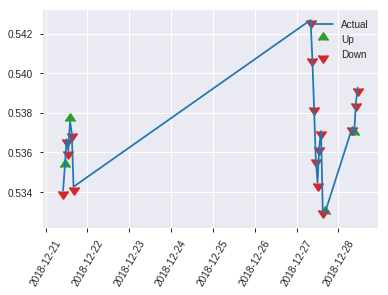


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.1815388700788412
RMSE: 0.4260737847824496
LogLoss: 0.5447792293826305
Mean Per-Class Error: 0.2264872050515121
AUC: 0.8158856763044201
pr_auc: 0.7604653962475816
Gini: 0.6317713526088402
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47365788156114624: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      90   28   0.2373   (28.0/118.0)
1      22   80   0.2157   (22.0/102.0)
Total  112  108  0.2273   (50.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.473658     0.761905  107
max f2                       0.301505     0.846422  164
max f0point5                 0.498029     0.757261  94
max accuracy                 0.487593     0.772727  99
max precision                0.937239     1         0
max recall                   0.140017     1         206
max specificity              0.937239     1         0
max absolute_mcc             0.473658     0.545667  107
max min_per_class_accuracy   0.474207     0.771186  105
max mean_per_class_accuracy  0.473658     0.773513  107

Gains/Lift Table: Avg response rate: 46.36 %, avg score: 46.44 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.934923           2.15686    2.15686            1                0.936213  1                           0.936213            0.0294118       0.0294118                  115.686   115.686
    2        0.0227273                   0.929621           1.07843    1.72549            0.5              0.930777  0.8                         0.934039            0.00980392      0.0392157                  7.84314   72.549
    3        0.0318182                   0.902411           2.15686    1.84874            1                0.925532  0.857143                    0.931608            0.0196078       0.0588235                  115.686   84.8739
    4        0.0409091                   0.871988           1.07843    1.67756            0.5              0.884639  0.777778                    0.92117             0.00980392      0.0686275                  7.84314   67.756
    5        0.05                        0.858597           2.15686    1.76471            1                0.86394   0.818182                    0.910765            0.0196078       0.0882353                  115.686   76.4706
    6        0.1                         0.812605           1.96078    1.86275            0.909091         0.839679  0.863636                    0.875222            0.0980392       0.186275                   96.0784   86.2745
    7        0.15                        0.749622           1.76471    1.83007            0.818182         0.781381  0.848485                    0.843942            0.0882353       0.27451                    76.4706   83.0065
    8        0.2                         0.631623           1.37255    1.71569            0.636364         0.702545  0.795455                    0.808593            0.0686275       0.343137                   37.2549   71.5686
    9        0.3                         0.54187            1.66667    1.69935            0.772727         0.58989   0.787879                    0.735692            0.166667        0.509804                   66.6667   69.9346
    10       0.4                         0.507733           1.56863    1.66667            0.727273         0.522243  0.772727                    0.682329            0.156863        0.666667                   56.8627   66.6667
    11       0.5                         0.467231           1.17647    1.56863            0.545455         0.488387  0.727273                    0.643541            0.117647        0.784314                   17.6471   56.8627
    12       0.6                         0.394341           0.490196   1.38889            0.227273         0.427017  0.643939                    0.607454            0.0490196       0.833333                   -50.9804  38.8889
    13       0.7                         0.330982           0.784314   1.30252            0.363636         0.364177  0.603896                    0.5727              0.0784314       0.911765                   -21.5686  30.2521
    14       0.8                         0.252746           0.490196   1.20098            0.227273         0.296446  0.556818                    0.538168            0.0490196       0.960784                   -50.9804  20.098
    15       0.9                         0.16144            0.0980392  1.07843            0.0454545        0.206444  0.5                         0.50131             0.00980392      0.970588                   -90.1961  7.84314
    16       1                           0.0808609          0.294118   1                  0.136364         0.132414  0.463636                    0.

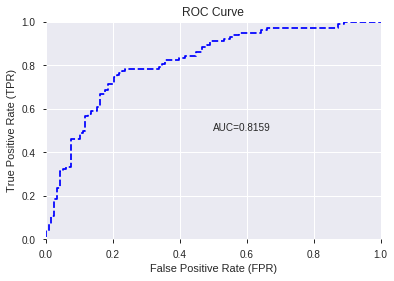

This function is available for GLM models only


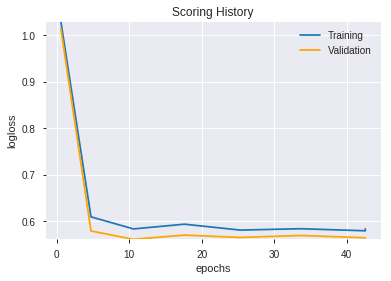

--2019-08-28 15:56:51--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.84.40
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.84.40|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_155006_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_155006_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_bf14',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLCLOSINGMARUBOZU',
 'CDLLONGLINE',
 'SUB',
 'DIV',
 'CDLSHORTLINE',
 'TRANGE',
 'CDLENGULFING',
 'CCI_8',
 'ULTOSC',
 'STOCHF_fastk',
 'ADOSC',
 'CDLBELTHOLD',
 'CCI_12',
 'Volume',
 'CDLMARUBOZU',
 'ROCR100_8',
 'CMO_12',
 'STOCHRSI_fastk',
 'MOM_8',
 'WILLR_14',
 'WILLR_24',
 'RSI_12',
 'WILLR_12',
 'ROCR_8',
 'ROCP_8',
 'WILLR_20',
 'ROC_8',
 'RSI_8',
 'WILLR_30',
 'RSI_14',
 'CMO_8',
 'CMO_14',
 'WILLR_8']

In [48]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190828_155702_model_1  0.808824  0.536268              0.241442  0.422789  0.178751

variable  relative_importance  scaled_importance  percentage
0                  BOP             0.886702           1.000000    0.130423
1                  SUB             0.517732           0.583884    0.076152
2                CMO_8             0.432412           0.487663    0.063602
3             WILLR_12             0.352071           0.397057    0.051785
4         STOCHF_fastk             0.334456           0.377191    0.049194
5                RSI_8             0.328921           0.370949    0.048380
6               CCI_12             0.317371           0.357923    0.046681
7               CMO_14             0.309426           0.348963    0.045513
8   CDLCLOSINGMARUBOZU             0.301624           0.340163    0.044365
9              WILLR_8             0.295428           0.333177    0.043454
10            WILLR_20             0.277565           0.313031    0.040826
11              RSI_14             0.267347           0.301507    0.039323
12              TRANGE             0.211566           0.238599    0.031119
13               CCI_8             0.206294           0.232653    0.030343
14         CDLBELTHOLD             0.194362           0.219196    0.028588
15              ULTOSC             0.183448           0.206888    0.026983
16      STOCHRSI_fastk             0.165110           0.186207    0.024286
17              CMO_12             0.159167           0.179504    0.023411
18            WILLR_24             0.153209           0.172785    0.022535
19              Volume             0.151014           0.170310    0.022212
20            WILLR_30             0.147540           0.166392    0.021701
21              RSI_12             0.110656           0.124795    0.016276
22        CDLENGULFING             0.097977           0.110495    0.014411
23               ADOSC             0.077268           0.087140    0.011365
24         CDLMARUBOZU             0.071854           0.081035    0.010569
25               MOM_8             0.067936           0.076616    0.009993
26         CDLLONGLINE             0.055137           0.062182    0.008110
27               ROC_8             0.046863           0.052851    0.006893
28            WILLR_14             0.037475           0.042263    0.005512
29                 DIV             0.016865           0.019020    0.002481
30              ROCP_8             0.011113           0.012533    0.001635
31              ROCR_8             0.007082           0.007987    0.001042
32           ROCR100_8             0.003771           0.004253    0.000555
33        CDLSHORTLINE             0.001906           0.002149    0.000280

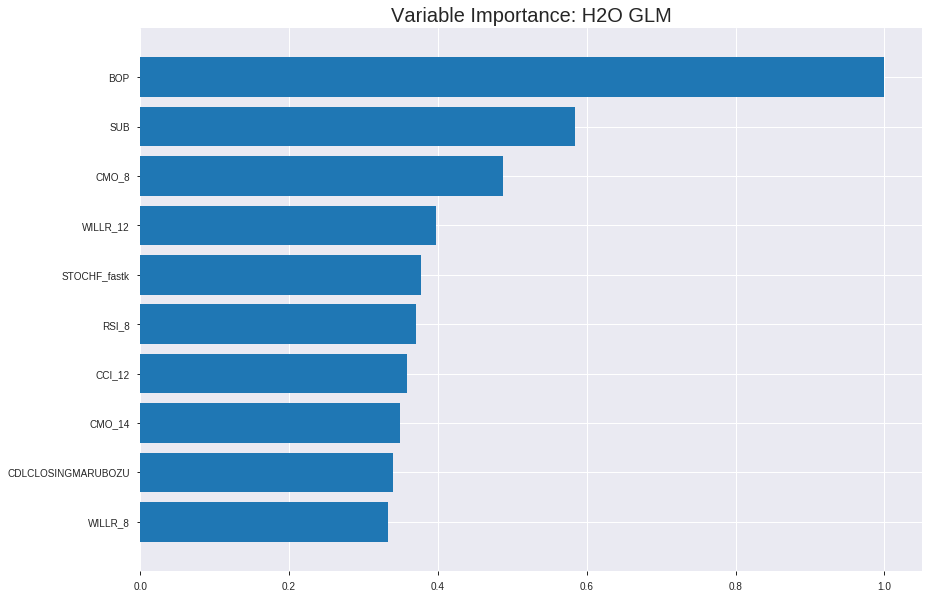

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_155702_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.19626379670308433
RMSE: 0.44301670025303147
LogLoss: 0.5758086332777522
Null degrees of freedom: 1536
Residual degrees of freedom: 1502
Null deviance: 2130.546400580142
Residual deviance: 1770.0357386958106
AIC: 1840.0357386958106
AUC: 0.7677199756147124
pr_auc: 0.7593884078665234
Gini: 0.5354399512294248
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3826228529433637: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      395  382   0.4916   (382.0/777.0)
1      119  641   0.1566   (119.0/760.0)
Total  514  1023  0.326    (501.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.382623     0.719013  254
max f2                       0.203055     0.840173  333
max f0point5                 0.538077     0.707014  177
max accuracy                 0.538077     0.704619  177
max precision                0.955889     1         0
max recall                   0.0276311    1         397
max specificity              0.955889     1         0
max absolute_mcc             0.538077     0.410123  177
max min_per_class_accuracy   0.509389     0.7       193
max mean_per_class_accuracy  0.536647     0.704123  178

Gains/Lift Table: Avg response rate: 49.45 %, avg score: 49.45 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.923757           2.02237   2.02237            1                0.937947   1                           0.937947            0.0210526       0.0210526                  102.237   102.237
    2        0.0201692                   0.906007           1.75272   1.89189            0.866667         0.91391    0.935484                    0.926317            0.0171053       0.0381579                  75.2719   89.1893
    3        0.0305791                   0.892459           1.89597   1.89328            0.9375           0.898165   0.93617                     0.916733            0.0197368       0.0578947                  89.597    89.3281
    4        0.0403383                   0.873828           1.88754   1.89189            0.933333         0.881297   0.935484                    0.90816             0.0184211       0.0763158                  88.7544   89.1893
    5        0.0500976                   0.858594           1.75272   1.86478            0.866667         0.866274   0.922078                    0.9                 0.0171053       0.0934211                  75.2719   86.4781
    6        0.100195                    0.79592            1.81225   1.83852            0.896104         0.824868   0.909091                    0.862434            0.0907895       0.184211                   81.2252   83.8517
    7        0.150293                    0.754559           1.44455   1.70719            0.714286         0.772906   0.844156                    0.832591            0.0723684       0.256579                   44.4549   70.7194
    8        0.20039                     0.713088           1.54961   1.6678             0.766234         0.731091   0.824675                    0.807216            0.0776316       0.334211                   54.9607   66.7797
    9        0.299935                    0.642488           1.37468   1.57052            0.679739         0.678675   0.776573                    0.764555            0.136842        0.471053                   37.4682   57.0516
    10       0.40013                     0.57799            1.2213    1.48307            0.603896         0.608852   0.733333                    0.725566            0.122368        0.593421                   22.13     48.307
    11       0.500325                    0.507343           1.08998   1.40435            0.538961         0.540424   0.694408                    0.688489            0.109211        0.702632                   8.99778   40.4349
    12       0.59987                     0.43277            0.819522  1.3073             0.405229         0.47029    0.646421                    0.652281            0.0815789       0.784211                   -18.0478  30.7301
    13       0.700065                    0.353808           0.827333  1.23861            0.409091         0.394199   0.612454                    0.615343            0.0828947       0.867105                   -17.2667  23.8607
    14       0.79961                     0.264377           0.62125   1.16175            0.30719          0.313381   0.574451                    0.577752            0.0618421       0.928947                   -37.875   16.1751
    15       0.899805                    0.166648           0.433365  1.08064            0.214286         0.224622   0.534346                    0.53843             0.0434211       0.972368                   -56.6635  8.06437
    16       1                           0.00672853         0.275778  1                  0.136364         0.0996858  0.49447                     



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.18646669685355932
RMSE: 0.4318178977920662
LogLoss: 0.5489720835418698
Null degrees of freedom: 439
Residual degrees of freedom: 405
Null deviance: 609.536667332913
Residual deviance: 483.0954335168454
AIC: 553.0954335168453
AUC: 0.790312558255142
pr_auc: 0.7357977851985057
Gini: 0.580625116510284
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.32759661971276255: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      128  103  0.4459   (103.0/231.0)
1      19   190  0.0909   (19.0/209.0)
Total  147  293  0.2773   (122.0/440.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.327597     0.756972  265
max f2                       0.222406     0.855818  316
max f0point5                 0.464696     0.712303  197
max accuracy                 0.464696     0.729545  197
max precision                0.948397     1         0
max recall                   0.0559682    1         384
max specificity              0.948397     1         0
max absolute_mcc             0.327597     0.490409  265
max min_per_class_accuracy   0.465607     0.722944  195
max mean_per_class_accuracy  0.327597     0.731602  265

Gains/Lift Table: Avg response rate: 47.50 %, avg score: 46.13 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113636                   0.92094            2.10526    2.10526            1                0.931407   1                           0.931407            0.0239234       0.0239234                  110.526   110.526
    2        0.0204545                   0.893416           1.57895    1.87135            0.75             0.910283   0.888889                    0.922019            0.0143541       0.0382775                  57.8947   87.1345
    3        0.0318182                   0.878186           1.68421    1.80451            0.8              0.886146   0.857143                    0.909207            0.0191388       0.0574163                  68.4211   80.4511
    4        0.0409091                   0.855275           2.10526    1.87135            1                0.86861    0.888889                    0.900186            0.0191388       0.076555                   110.526   87.1345
    5        0.05                        0.846683           2.10526    1.91388            1                0.850371   0.909091                    0.891128            0.0191388       0.0956938                  110.526   91.3876
    6        0.1                         0.78282            1.72249    1.81818            0.818182         0.818853   0.863636                    0.854991            0.0861244       0.181818                   72.2488   81.8182
    7        0.15                        0.743835           1.14833    1.5949             0.545455         0.761457   0.757576                    0.823813            0.0574163       0.239234                   14.8325   59.4896
    8        0.2                         0.708497           1.62679    1.60287            0.772727         0.726201   0.761364                    0.79941             0.0813397       0.320574                   62.6794   60.2871
    9        0.3                         0.633093           1.57895    1.5949             0.75             0.672067   0.757576                    0.756962            0.157895        0.478469                   57.8947   59.4896
    10       0.4                         0.538143           1.29187    1.51914            0.613636         0.589268   0.721591                    0.715039            0.129187        0.607656                   29.1866   51.9139
    11       0.5                         0.462539           1.29187    1.47368            0.613636         0.499195   0.7                         0.67187             0.129187        0.736842                   29.1866   47.3684
    12       0.6                         0.379433           0.956938   1.38756            0.454545         0.419555   0.659091                    0.629818            0.0956938       0.832536                   -4.30622  38.756
    13       0.7                         0.307228           0.861244   1.31237            0.409091         0.34149    0.623377                    0.588628            0.0861244       0.91866                    -13.8756  31.2372
    14       0.8                         0.220103           0.526316   1.21411            0.25             0.263557   0.576705                    0.547994            0.0526316       0.971292                   -47.3684  21.4115
    15       0.9                         0.113341           0.191388   1.10048            0.0909091        0.165422   0.522727                    0.505486            0.0191388       0.990431                   -80.8612  10.0478
    16       1                           0.00582612         0.0956938  1                  0.0454545        0.0632154  0.475     


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-28 15:57:03  0.000 sec   2            .2E2      35            1.3656270703497029  1.3630558217580633
     2019-08-28 15:57:03  0.008 sec   4            .12E2     35            1.356180780539249   1.3525006846312084
     2019-08-28 15:57:03  0.015 sec   6            .78E1     35            1.3438509638246088  1.3383337202944576
     2019-08-28 15:57:03  0.023 sec   8            .48E1     35            1.3286230527309528  1.3201682904819465
     2019-08-28 15:57:03  0.030 sec   10           .3E1      35            1.3105904242731423  1.2976920106750212
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-28 15:57:03  0.220 sec   43           .56E-3    35            1.1517114440437284  1.0993063502399765
     2019-08-28 15:57:03  0.225 sec   44           .35E-3    35            1.1516610899412205  1.0989151103827803
     2019-08-28 15:57:03  0.230 sec   45           .22E-3    35            1.151636009533865   1.098530348136143
     2019-08-28 15:57:03  0.239 sec   46           .14E-3    35            1.1516235746952086  1.0981996147239768
     2019-08-28 15:57:03  0.245 sec   47           .84E-4    35            1.1516172665555044  1.0979441670837395


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7545454545454545)

('F1', 0.7545454545454545)

('auc', 0.8088235294117647)

('logloss', 0.5362684581512551)

('mean_per_class_error', 0.24144233964772344)

('rmse', 0.4227890151372317)

('mse', 0.17875055132071035)

glm prediction progress: |████████████████████████████████████████████████| 100%


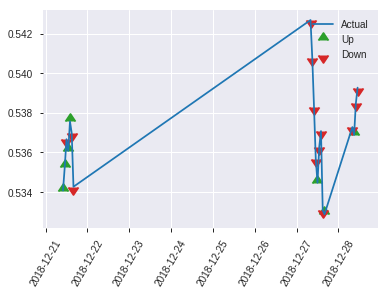


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.17875055132071035
RMSE: 0.4227890151372317
LogLoss: 0.5362684581512551
Null degrees of freedom: 219
Residual degrees of freedom: 185
Null deviance: 304.6577240810208
Residual deviance: 235.95812158655227
AIC: 305.95812158655224
AUC: 0.8088235294117647
pr_auc: 0.7526464287497063
Gini: 0.6176470588235294
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4110218003069761: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      83   35   0.2966   (35.0/118.0)
1      19   83   0.1863   (19.0/102.0)
Total  102  118  0.2455   (54.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.411022     0.754545  117
max f2                       0.10566      0.840198  198
max f0point5                 0.560408     0.755814  81
max accuracy                 0.560408     0.754545  81
max precision                0.845735     0.909091  10
max recall                   0.10566      1         198
max specificity              0.929683     0.991525  0
max absolute_mcc             0.411022     0.517115  117
max min_per_class_accuracy   0.457615     0.737288  106
max mean_per_class_accuracy  0.411022     0.758558  117

Gains/Lift Table: Avg response rate: 46.36 %, avg score: 45.18 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.889324           1.43791    1.43791            0.666667         0.913634   0.666667                    0.913634            0.0196078       0.0196078                  43.7908   43.7908
    2        0.0227273                   0.874848           2.15686    1.72549            1                0.879586   0.8                         0.900015            0.0196078       0.0392157                  115.686   72.549
    3        0.0318182                   0.863814           2.15686    1.84874            1                0.866305   0.857143                    0.890384            0.0196078       0.0588235                  115.686   84.8739
    4        0.0409091                   0.856916           2.15686    1.91721            1                0.863155   0.888889                    0.884333            0.0196078       0.0784314                  115.686   91.7211
    5        0.05                        0.84135            2.15686    1.96078            1                0.85044    0.909091                    0.87817             0.0196078       0.0980392                  115.686   96.0784
    6        0.1                         0.780162           1.76471    1.86275            0.818182         0.809685   0.863636                    0.843927            0.0882353       0.186275                   76.4706   86.2745
    7        0.15                        0.753789           1.76471    1.83007            0.818182         0.763426   0.848485                    0.817094            0.0882353       0.27451                    76.4706   83.0065
    8        0.2                         0.724325           1.76471    1.81373            0.818182         0.735746   0.840909                    0.796757            0.0882353       0.362745                   76.4706   81.3725
    9        0.3                         0.637028           1.37255    1.66667            0.636364         0.678851   0.772727                    0.757455            0.137255        0.5                        37.2549   66.6667
    10       0.4                         0.533942           1.47059    1.61765            0.681818         0.584999   0.75                        0.714341            0.147059        0.647059                   47.0588   61.7647
    11       0.5                         0.447433           1.17647    1.52941            0.545455         0.487373   0.709091                    0.668948            0.117647        0.764706                   17.6471   52.9412
    12       0.6                         0.340389           0.882353   1.42157            0.409091         0.398135   0.659091                    0.623812            0.0882353       0.852941                   -11.7647  42.1569
    13       0.7                         0.272203           0.588235   1.30252            0.272727         0.300311   0.603896                    0.577598            0.0588235       0.911765                   -41.1765  30.2521
    14       0.8                         0.208834           0.196078   1.16422            0.0909091        0.243634   0.539773                    0.535852            0.0196078       0.931373                   -80.3922  16.4216
    15       0.9                         0.10724            0.588235   1.10022            0.272727         0.166544   0.510101                    0.494818            0.0588235       0.990196                   -41.1765  10.0218
    16       1                           0.0158097          0.0980392  1                  0.0454545        0.0648453  0.463636  

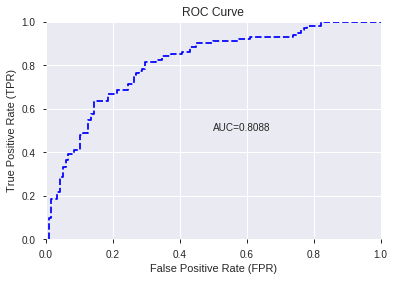

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


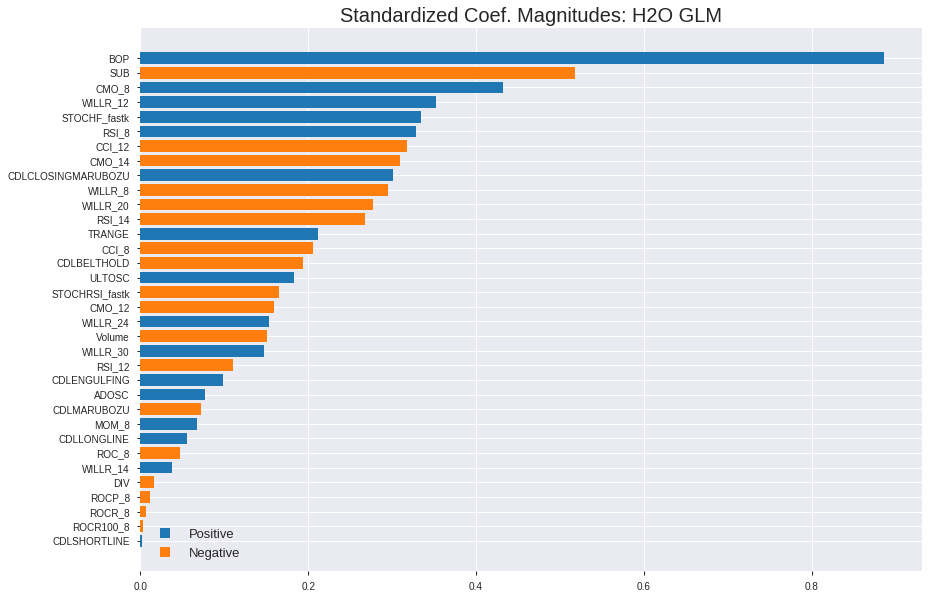

'log_likelihood'
--2019-08-28 15:57:09--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.32.28
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.32.28|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_155702_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_155702_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_bf14',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['BOP',
 'SUB',
 'CMO_8',
 'WILLR_12',
 'STOCHF_fastk',
 'RSI_8',
 'CCI_12',
 'CMO_14',
 'CDLCLOSINGMARUBOZU',
 'WILLR_8',
 'WILLR_20',
 'RSI_14',
 'TRANGE',
 'CCI_8',
 'CDLBELTHOLD',
 'ULTOSC',
 'STOCHRSI_fastk',
 'CMO_12',
 'WILLR_24',
 'Volume',
 'WILLR_30',
 'RSI_12',
 'CDLENGULFING',
 'ADOSC',
 'CDLMARUBOZU',
 'MOM_8',
 'CDLLONGLINE',
 'ROC_8',
 'WILLR_14',
 'DIV',
 'ROCP_8',
 'ROCR_8',
 'ROCR100_8',
 'CDLSHORTLINE']

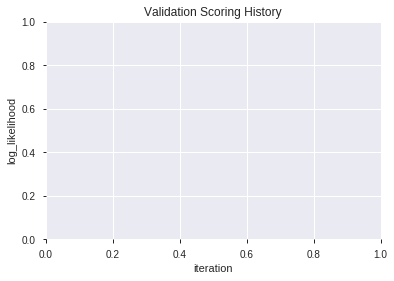

In [49]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190828_155718_model_3  0.808740  0.540498              0.264207  0.424155  0.179908
1  XGBoost_grid_1_AutoML_20190828_155718_model_1  0.805916  0.542084              0.240113  0.425326  0.180903
2               XGBoost_2_AutoML_20190828_155718  0.804919  0.543048              0.260635  0.425127  0.180733
3  XGBoost_grid_1_AutoML_20190828_155718_model_6  0.798355  0.545450              0.257727  0.426951  0.182287
4  XGBoost_grid_1_AutoML_20190828_155718_model_4  0.794533  0.550625              0.240113  0.428981  0.184025
5               XGBoost_3_AutoML_20190828_155718  0.793204  0.551480              0.284064  0.430191  0.185065
6               XGBoost_1_AutoML_20190828_155718  0.793121  0.551216              0.280243  0.430204  0.185075
7  XGBoost_grid_1_AutoML_20190828_155718_model_2  0.785394  0.560297              0.256397  0.433269  0.187722
8  XGBoost_grid_1_AutoML_20190828_155718_model_7  0.782735  0.564620              0.286058  0.436063  0.190151
9  XGBoost_grid_1_AutoML_20190828_155718_model_5  0.762629  0.581057              0.300764  0.445210  0.198212

variable  relative_importance  scaled_importance  percentage
0                  BOP          1354.029053           1.000000    0.220378
1         STOCHF_fastk           683.934814           0.505111    0.111315
2                CCI_8           377.119751           0.278517    0.061379
3                  DIV           359.112793           0.265218    0.058448
4               TRANGE           280.654175           0.207273    0.045679
5               CCI_12           271.459564           0.200483    0.044182
6                  SUB           239.950775           0.177212    0.039054
7                ADOSC           209.508530           0.154730    0.034099
8               Volume           206.428680           0.152455    0.033598
9              WILLR_8           182.656860           0.134899    0.029729
10            WILLR_12           174.555923           0.128916    0.028410
11              ULTOSC           174.522278           0.128891    0.028405
12            WILLR_20           160.425705           0.118480    0.026110
13            WILLR_30           159.488358           0.117788    0.025958
14      STOCHRSI_fastk           157.056458           0.115992    0.025562
15               ROC_8           128.886322           0.095187    0.020977
16            WILLR_24           125.317825           0.092552    0.020396
17            WILLR_14            99.587585           0.073549    0.016209
18         CDLLONGLINE            97.041687           0.071669    0.015794
19        CDLSHORTLINE            96.195633           0.071044    0.015657
20               MOM_8            93.532539           0.069077    0.015223
21              CMO_12            77.622162           0.057327    0.012634
22               CMO_8            77.185822           0.057005    0.012563
23  CDLCLOSINGMARUBOZU            71.319412           0.052672    0.011608
24              CMO_14            69.551155           0.051366    0.011320
25              RSI_14            54.802570           0.040474    0.008920
26              RSI_12            44.205471           0.032647    0.007195
27        CDLENGULFING            37.137527           0.027427    0.006044
28              ROCP_8            29.082659           0.021479    0.004733
29              ROCR_8            21.382519           0.015792    0.003480
30         CDLBELTHOLD            15.303191           0.011302    0.002491
31           ROCR100_8            12.536517           0.009259    0.002040
32               RSI_8             2.525339           0.001865    0.000411

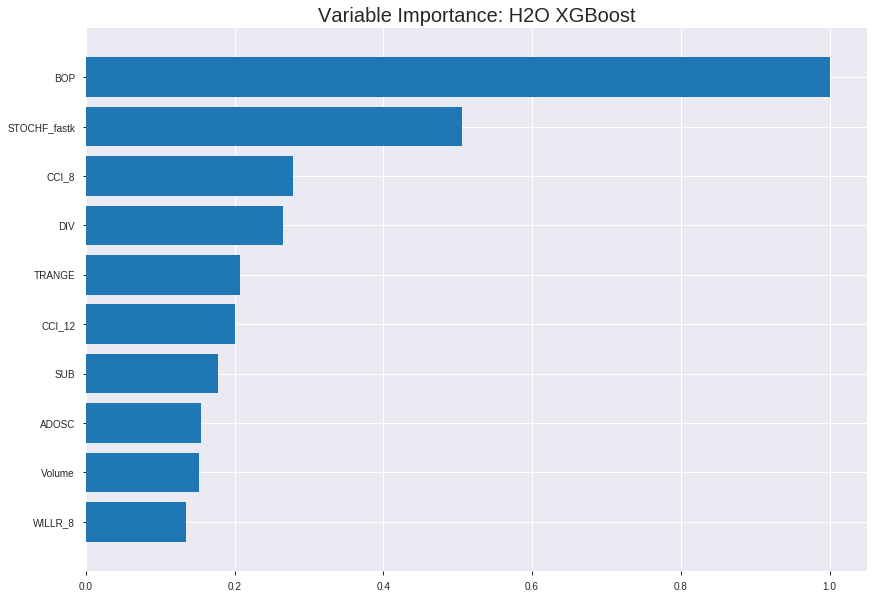

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190828_155718_model_3


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1489129073971901
RMSE: 0.38589235208434763
LogLoss: 0.466825454882007
Mean Per-Class Error: 0.195511583011583
AUC: 0.8909334146176252
pr_auc: 0.891866014679923
Gini: 0.7818668292352504
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44713240265846255: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      560  217  0.2793   (217.0/777.0)
1      104  656  0.1368   (104.0/760.0)
Total  664  873  0.2088   (321.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.447132     0.803429  226
max f2                       0.302337     0.883754  299
max f0point5                 0.583725     0.831152  155
max accuracy                 0.522174     0.804815  186
max precision                0.947678     1         0
max recall                   0.173058     1         357
max specificity              0.947678     1         0
max absolute_mcc             0.522174     0.610596  186
max min_per_class_accuracy   0.498143     0.802632  199
max mean_per_class_accuracy  0.519141     0.804488  188

Gains/Lift Table: Avg response rate: 49.45 %, avg score: 49.36 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.920089           2.02237    2.02237            1                0.928768  1                           0.928768            0.0210526       0.0210526                  102.237   102.237
    2        0.0201692                   0.9009             2.02237    2.02237            1                0.910997  1                           0.920169            0.0197368       0.0407895                  102.237   102.237
    3        0.0305791                   0.885538           2.02237    2.02237            1                0.894053  1                           0.911278            0.0210526       0.0618421                  102.237   102.237
    4        0.0403383                   0.872377           2.02237    2.02237            1                0.877568  1                           0.903123            0.0197368       0.0815789                  102.237   102.237
    5        0.0500976                   0.858765           2.02237    2.02237            1                0.865884  1                           0.895868            0.0197368       0.101316                   102.237   102.237
    6        0.100195                    0.807605           1.96984    1.9961             0.974026         0.833928  0.987013                    0.864898            0.0986842       0.2                        96.9839   99.6104
    7        0.150293                    0.757525           1.86478    1.95233            0.922078         0.780089  0.965368                    0.836628            0.0934211       0.293421                   86.4781   95.233
    8        0.20039                     0.72074            1.86478    1.93044            0.922078         0.73917   0.954545                    0.812264            0.0934211       0.386842                   86.4781   93.0443
    9        0.299935                    0.63203            1.69192    1.85128            0.836601         0.678404  0.915401                    0.767837            0.168421        0.555263                   69.1916   85.1279
    10       0.40013                     0.561821           1.41828    1.74285            0.701299         0.598252  0.861789                    0.725372            0.142105        0.697368                   41.8284   74.2854
    11       0.500325                    0.493239           1.07685    1.60948            0.532468         0.528661  0.795839                    0.685979            0.107895        0.805263                   7.68455   60.9479
    12       0.59987                     0.421767           0.726995   1.46304            0.359477         0.456788  0.723427                    0.647946            0.0723684       0.877632                   -27.3005  46.3037
    13       0.700065                    0.340666           0.722274   1.35702            0.357143         0.379891  0.671004                    0.609581            0.0723684       0.95                       -27.7726  35.7017
    14       0.79961                     0.267384           0.370107   1.23415            0.183007         0.303604  0.610252                    0.57149             0.0368421       0.986842                   -62.9893  23.4155
    15       0.899805                    0.189561           0.105058   1.10843            0.0519481        0.231457  0.548084                    0.533626            0.0105263       0.997368                   -89.4942  10.8428
    16       1                           0.0618308          0.0262645  1                  0.012987         0.133669  0.49447                     



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.19660631311422425
RMSE: 0.44340310453832443
LogLoss: 0.5755080173333867
Mean Per-Class Error: 0.2834358623832308
AUC: 0.7693096377306904
pr_auc: 0.72777191539846
Gini: 0.5386192754613808
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2796862721443176: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      103  128  0.5541   (128.0/231.0)
1      17   192  0.0813   (17.0/209.0)
Total  120  320  0.3295   (145.0/440.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.279686     0.725898  290
max f2                       0.211533     0.838898  328
max f0point5                 0.462578     0.705824  187
max accuracy                 0.462578     0.718182  187
max precision                0.940652     1         0
max recall                   0.0963413    1         390
max specificity              0.940652     1         0
max absolute_mcc             0.462578     0.434209  187
max min_per_class_accuracy   0.436435     0.703349  197
max mean_per_class_accuracy  0.462578     0.716564  187

Gains/Lift Table: Avg response rate: 47.50 %, avg score: 45.54 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113636                   0.918818           2.10526   2.10526            1                0.92584   1                           0.92584             0.0239234       0.0239234                  110.526   110.526
    2        0.0204545                   0.881509           1.57895   1.87135            0.75             0.905547  0.888889                    0.916821            0.0143541       0.0382775                  57.8947   87.1345
    3        0.0318182                   0.874177           2.10526   1.95489            1                0.878327  0.928571                    0.903073            0.0239234       0.062201                   110.526   95.4887
    4        0.0409091                   0.844014           1.57895   1.87135            0.75             0.853946  0.888889                    0.892156            0.0143541       0.076555                   57.8947   87.1345
    5        0.05                        0.835521           2.10526   1.91388            1                0.84086   0.909091                    0.882829            0.0191388       0.0956938                  110.526   91.3876
    6        0.1                         0.783108           1.62679   1.77033            0.772727         0.808017  0.840909                    0.845423            0.0813397       0.177033                   62.6794   77.0335
    7        0.15                        0.753517           1.43541   1.65869            0.681818         0.770833  0.787879                    0.82056             0.0717703       0.248804                   43.5407   65.8692
    8        0.2                         0.707282           1.43541   1.60287            0.681818         0.729244  0.761364                    0.797731            0.0717703       0.320574                   43.5407   60.2871
    9        0.3                         0.611934           1.38756   1.5311             0.659091         0.656633  0.727273                    0.750698            0.138756        0.45933                    38.756    53.11
    10       0.4                         0.505257           1.48325   1.51914            0.704545         0.556884  0.721591                    0.702245            0.148325        0.607656                   48.3254   51.9139
    11       0.5                         0.430287           1.10048   1.43541            0.522727         0.468295  0.681818                    0.655455            0.110048        0.717703                   10.0478   43.5407
    12       0.6                         0.346906           0.861244  1.33971            0.409091         0.384943  0.636364                    0.610369            0.0861244       0.803828                   -13.8756  33.9713
    13       0.7                         0.293635           0.813397  1.26452            0.386364         0.322691  0.600649                    0.569272            0.0813397       0.885167                   -18.6603  26.4525
    14       0.8                         0.22687            0.574163  1.17823            0.272727         0.26027   0.559659                    0.530647            0.0574163       0.942584                   -42.5837  17.823
    15       0.9                         0.159757           0.382775  1.08985            0.181818         0.193977  0.517677                    0.493239            0.0382775       0.980861                   -61.7225  8.98458
    16       1                           0.0746922          0.191388  1                  0.0909091        0.115092  0.475                       0.455425            


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 15:57:24  1.974 sec   0                  0.5              0.693147            0.5             0                  1                0.50553                          0.5                0.693147              0.5               0                    1                  0.525
    2019-08-28 15:57:24  2.097 sec   5                  0.474222         0.642551            0.813449        0.809169           2.02237          0.277163                         0.479153           0.651978              0.743833          0.704262             2.10526            0.372727
    2019-08-28 15:57:24  2.161 sec   10                 0.457696         0.610561            0.829129        0.829128           2.02237          0.247885                         0.464381           0.622908              0.768264          0.736605             2.10526            0.340909
    2019-08-28 15:57:24  2.227 sec   15                 0.442731         0.581425            0.842433        0.84417            2.02237          0.248536                         0.455804           0.605478              0.771122          0.743017             2.10526            0.345455
    2019-08-28 15:57:24  2.297 sec   20                 0.430533         0.557391            0.850163        0.853538           2.02237          0.251139                         0.449203           0.591286              0.772468          0.740441             2.10526            0.343182
    2019-08-28 15:57:24  2.374 sec   25                 0.420817         0.537708            0.855896        0.858507           2.02237          0.241379                         0.444608           0.581481              0.777709          0.74531              2.10526            0.329545
    2019-08-28 15:57:24  2.461 sec   30                 0.412467         0.520836            0.863762        0.865385           2.02237          0.240078                         0.443349           0.577531              0.774799          0.742401             2.10526            0.343182
    2019-08-28 15:57:25  2.535 sec   35                 0.407204         0.509524            0.867056        0.869116           2.02237          0.238777                         0.442517           0.574923              0.772479          0.738826             2.10526            0.331818
    2019-08-28 15:57:25  2.604 sec   40                 0.402848         0.500436            0.870313        0.870952           2.02237          0.225114                         0.442269           0.574146              0.772914          0.735694             1.68421            0.329545
    2019-08-28 15:57:25  2.686 sec   45                 0.397653         0.490033            0.876338        0.877418           2.02237          0.207547                         0.443174           0.575263              0.769403          0.731894             1.68421            0.336364
    2019-08-28 15:57:25  2.767 sec   50                 0.392804         0.480435            0.882316        0.883457           2.02237          0.212101                         0.44303            0.574758              0.770242          0.727595             1.68421            0.329545
    2019-08-28 15:57:25  2.847 sec   55                 0.38891          0.47275             0.887125        0.887977           2.02237          0.214704                         0.443353           0.575631              0.769268          0.72

Variable Importances: 


variable      relative_importance    scaled_importance      percentage
------------  ---------------------  ---------------------  ----------------------
BOP           1354.029052734375      1.0                    0.22037804096451533
STOCHF_fastk  683.934814453125       0.5051108859680392     0.11131534751948716
CCI_8         377.1197509765625      0.27851673508407615    0.06137897245366159
DIV           359.11279296875        0.26521793771229996    0.05844820954168551
TRANGE        280.6541748046875      0.20727337736064405    0.04567850084683745
---           ---                    ---                    ---
ROCP_8        29.082658767700195     0.0214786076480188     0.004733413476115838
ROCR_8        21.382518768310547     0.015791772506749333   0.003480159888394711
CDLBELTHOLD   15.303191184997559     0.011301966641036058   0.0024907052673978297
ROCR100_8     12.536517143249512     0.009258676627309302   0.0020404090170503698
RSI_8         2.525339126586914      0.0018650553483229575  0.00041101724395380514


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7545454545454545)

('F1', 0.7435897435897436)

('auc', 0.8087404453306747)

('logloss', 0.5404975854860442)

('mean_per_class_error', 0.24742439348620804)

('rmse', 0.4241552246522661)

('mse', 0.17990765459981434)

xgboost prediction progress: |████████████████████████████████████████████| 100%


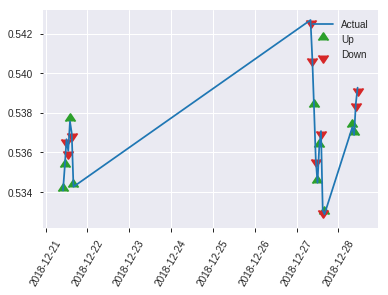


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.17990765459981434
RMSE: 0.4241552246522661
LogLoss: 0.5404975854860442
Mean Per-Class Error: 0.24742439348620804
AUC: 0.8087404453306747
pr_auc: 0.7281452846635046
Gini: 0.6174808906613494
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34396666288375854: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      73   45   0.3814   (45.0/118.0)
1      15   87   0.1471   (15.0/102.0)
Total  88   132  0.2727   (60.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.343967     0.74359   131
max f2                       0.23912      0.856164  175
max f0point5                 0.483409     0.740741  95
max accuracy                 0.483409     0.754545  95
max precision                0.931202     1         0
max recall                   0.160359     1         197
max specificity              0.931202     1         0
max absolute_mcc             0.47112      0.505908  99
max min_per_class_accuracy   0.449318     0.745763  106
max mean_per_class_accuracy  0.47112      0.752576  99

Gains/Lift Table: Avg response rate: 46.36 %, avg score: 45.57 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.898892           1.43791   1.43791            0.666667         0.917301  0.666667                    0.917301            0.0196078       0.0196078                  43.7908   43.7908
    2        0.0227273                   0.870811           0         0.862745           0                0.880793  0.4                         0.902698            0               0.0196078                  -100      -13.7255
    3        0.0318182                   0.847037           2.15686   1.23249            1                0.85737   0.571429                    0.889747            0.0196078       0.0392157                  115.686   23.2493
    4        0.0409091                   0.833156           2.15686   1.43791            1                0.837835  0.666667                    0.878211            0.0196078       0.0588235                  115.686   43.7908
    5        0.05                        0.815272           2.15686   1.56863            1                0.829814  0.727273                    0.869411            0.0196078       0.0784314                  115.686   56.8627
    6        0.1                         0.773566           1.76471   1.66667            0.818182         0.79313   0.772727                    0.831271            0.0882353       0.166667                   76.4706   66.6667
    7        0.15                        0.743702           2.15686   1.83007            1                0.764463  0.848485                    0.809002            0.107843        0.27451                    115.686   83.0065
    8        0.2                         0.703688           1.76471   1.81373            0.818182         0.722906  0.840909                    0.787478            0.0882353       0.362745                   76.4706   81.3725
    9        0.3                         0.603101           1.56863   1.73203            0.727273         0.660928  0.80303                     0.745295            0.156863        0.519608                   56.8627   73.2026
    10       0.4                         0.523062           1.27451   1.61765            0.590909         0.565433  0.75                        0.700329            0.127451        0.647059                   27.451    61.7647
    11       0.5                         0.425356           1.17647   1.52941            0.545455         0.475211  0.709091                    0.655306            0.117647        0.764706                   17.6471   52.9412
    12       0.6                         0.340549           0.882353  1.42157            0.409091         0.38345   0.659091                    0.609996            0.0882353       0.852941                   -11.7647  42.1569
    13       0.7                         0.29066            0.490196  1.28852            0.227273         0.315377  0.597403                    0.567908            0.0490196       0.901961                   -50.9804  28.8515
    14       0.8                         0.239087           0.784314  1.22549            0.363636         0.26446   0.568182                    0.529977            0.0784314       0.980392                   -21.5686  22.549
    15       0.9                         0.160186           0.196078  1.11111            0.0909091        0.200758  0.515152                    0.493397            0.0196078       1                          -80.3922  11.1111
    16       1                           0.0694776          0         1                  0                0.116041  0.463636                    0.455662         

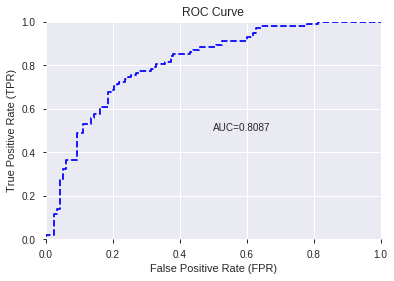

This function is available for GLM models only


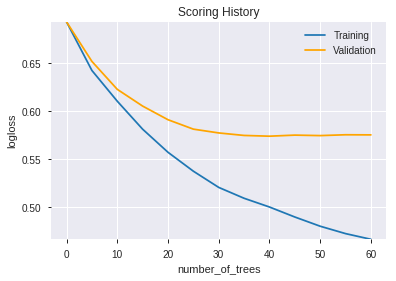

--2019-08-28 15:57:37--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.114.3
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.114.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.indexOf(String.java:1578)
	at java.base/java.lang.String.indexOf(String.java:1535)
	at java.base/java.lang.String.split(String.java:2274)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190828_155718_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190828_155718_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_bf14',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'STOCHF_fastk',
 'CCI_8',
 'DIV',
 'TRANGE',
 'CCI_12',
 'SUB',
 'ADOSC',
 'Volume',
 'WILLR_8',
 'WILLR_12',
 'ULTOSC',
 'WILLR_20',
 'WILLR_30',
 'STOCHRSI_fastk',
 'ROC_8',
 'WILLR_24',
 'WILLR_14',
 'CDLLONGLINE',
 'CDLSHORTLINE',
 'MOM_8',
 'CMO_12',
 'CMO_8',
 'CDLCLOSINGMARUBOZU',
 'CMO_14',
 'RSI_14',
 'RSI_12',
 'CDLENGULFING',
 'ROCP_8',
 'ROCR_8',
 'CDLBELTHOLD',
 'ROCR100_8',
 'RSI_8']

In [50]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [51]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

153

['BBANDS_upperband_14_7_4',
 'BBANDS_middleband_14_7_4',
 'BBANDS_lowerband_14_7_4',
 'BBANDS_lowerband_14_7_5',
 'DEMA_20',
 'SAR_0.2',
 'WMA_20',
 'BBANDS_upperband_20_0_2',
 'BBANDS_middleband_20_0_4',
 'MA_20_1',
 'BBANDS_middleband_20_1_2',
 'BBANDS_upperband_20_1_3',
 'BBANDS_upperband_20_1_4',
 'BBANDS_upperband_20_1_5',
 'BBANDS_lowerband_20_1_5',
 'BBANDS_upperband_20_2_4',
 'BBANDS_upperband_20_2_5',
 'BBANDS_lowerband_20_2_5',
 'BBANDS_lowerband_20_3_5',
 'BBANDS_upperband_20_5_3',
 'BBANDS_middleband_20_5_5',
 'BBANDS_middleband_20_6_2',
 'BBANDS_lowerband_20_6_2',
 'BBANDS_lowerband_20_6_3',
 'BBANDS_upperband_20_6_4',
 'BBANDS_upperband_20_6_5',
 'BBANDS_middleband_20_6_5',
 'BBANDS_lowerband_24_1_3',
 'BBANDS_lowerband_24_3_5',
 'BBANDS_upperband_24_5_5',
 'BBANDS_upperband_24_6_3',
 'BBANDS_upperband_24_7_3',
 'BBANDS_lowerband_24_7_5',
 'BBANDS_lowerband_30_2_3',
 'BBANDS_middleband_30_2_5',
 'BBANDS_lowerband_30_5_5',
 'BBANDS_middleband_30_6_2',
 'MA_30_7',
 'BOP',
 

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_155912_model_9  0.825773  0.585932              0.230724  0.446909  0.199728
1  DeepLearning_grid_1_AutoML_20190828_155912_model_8  0.812978  0.600357              0.236790  0.453974  0.206092
2  DeepLearning_grid_1_AutoML_20190828_155912_model_7  0.784895  0.690613              0.257062  0.497217  0.247225
3  DeepLearning_grid_1_AutoML_20190828_155912_model_6  0.775424  0.596167              0.248754  0.451708  0.204040
4  DeepLearning_grid_1_AutoML_20190828_155912_model_3  0.749003  0.688638              0.346959  0.479685  0.230098
5  DeepLearning_grid_1_AutoML_20190828_155912_model_5  0.739365  0.604508              0.289133  0.457048  0.208893
6  DeepLearning_grid_1_AutoML_20190828_155912_model_2  0.716268  2.951246              0.364573  0.681009  0.463774
7  DeepLearning_grid_1_AutoML_20190828_155912_model_4  0.678797  0.754316              0.398056  0.500762  0.250763
8  DeepLearning_grid_1_AutoML_20190828_155912_model_1  0.634181  1.431389              0.456049  0.576180  0.331984
9               DeepLearning_1_AutoML_20190828_155912  0.632602  1.406541              0.436191  0.650952  0.423738

variable  relative_importance  scaled_importance  percentage
0                         BOP             1.000000           1.000000    0.022165
1                      TRANGE             0.868624           0.868624    0.019253
2          CDLCLOSINGMARUBOZU             0.853946           0.853946    0.018928
3                 CDLLONGLINE             0.768890           0.768890    0.017042
4                CDLSHORTLINE             0.644344           0.644344    0.014282
..                        ...                  ...                ...         ...
148               LINEARREG_8             0.227444           0.227444    0.005041
149   BBANDS_upperband_20_2_4             0.227317           0.227317    0.005038
150  BBANDS_middleband_20_5_5             0.225566           0.225566    0.005000
151                     TSF_8             0.225223           0.225223    0.004992
152                    WMA_20             0.218361           0.218361    0.004840

[153 rows x 4 columns]

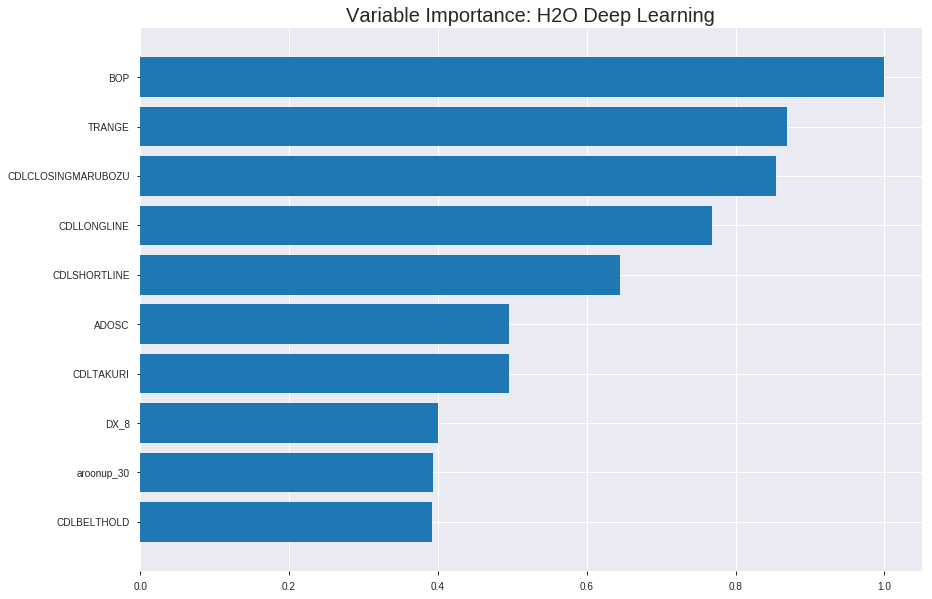

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_155912_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.18681159195516403
RMSE: 0.43221706578427005
LogLoss: 0.5522670365331253
Mean Per-Class Error: 0.28441966402492724
AUC: 0.7965344103501998
pr_auc: 0.8003924825044805
Gini: 0.5930688207003996
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41854584733121547: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      365  412   0.5302   (412.0/777.0)
1      78   682   0.1026   (78.0/760.0)
Total  443  1094  0.3188   (490.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.418546     0.735707  267
max f2                       0.273374     0.845839  334
max f0point5                 0.621136     0.734421  146
max accuracy                 0.495191     0.71568   213
max precision                0.960531     1         0
max recall                   0.148057     1         385
max specificity              0.960531     1         0
max absolute_mcc             0.580241     0.439824  166
max min_per_class_accuracy   0.492992     0.714286  215
max mean_per_class_accuracy  0.495191     0.71558   213

Gains/Lift Table: Avg response rate: 49.45 %, avg score: 52.98 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.934591           2.02237   2.02237            1                0.944084  1                           0.944084            0.0210526       0.0210526                  102.237   102.237
    2        0.0201692                   0.920463           2.02237   2.02237            1                0.927791  1                           0.9362              0.0197368       0.0407895                  102.237   102.237
    3        0.0305791                   0.910574           2.02237   2.02237            1                0.915363  1                           0.929107            0.0210526       0.0618421                  102.237   102.237
    4        0.0403383                   0.899509           1.61789   1.92451            0.8              0.9045    0.951613                    0.923154            0.0157895       0.0776316                  61.7895   92.4512
    5        0.0500976                   0.89088            2.02237   1.94357            1                0.896163  0.961039                    0.917896            0.0197368       0.0973684                  102.237   94.3575
    6        0.100195                    0.846273           1.78599   1.86478            0.883117         0.871     0.922078                    0.894448            0.0894737       0.186842                   78.5988   86.4781
    7        0.150293                    0.793644           1.83852   1.85603            0.909091         0.817883  0.917749                    0.868926            0.0921053       0.278947                   83.8517   85.6026
    8        0.20039                     0.742603           1.60214   1.79255            0.792208         0.768308  0.886364                    0.843771            0.0802632       0.359211                   60.2136   79.2554
    9        0.299935                    0.634331           1.42755   1.67142            0.705882         0.695398  0.826464                    0.794528            0.142105        0.501316                   42.7554   67.1415
    10       0.40013                     0.549697           1.05058   1.51595            0.519481         0.590697  0.749593                    0.743488            0.105263        0.606579                   5.0581    51.5954
    11       0.500325                    0.491134           1.10311   1.43328            0.545455         0.514855  0.708713                    0.697702            0.110526        0.717105                   10.311    43.3278
    12       0.59987                     0.457099           0.819522  1.33143            0.405229         0.473839  0.658351                    0.660553            0.0815789       0.798684                   -18.0478  33.1429
    13       0.700065                    0.421585           0.879862  1.2668             0.435065         0.440892  0.626394                    0.629114            0.0881579       0.886842                   -12.0138  26.68
    14       0.79961                     0.357677           0.515506  1.17327            0.254902         0.39298   0.580146                    0.599718            0.0513158       0.938158                   -48.4494  17.327
    15       0.899805                    0.252024           0.446497  1.09234            0.220779         0.310273  0.54013                     0.567487            0.0447368       0.982895                   -55.3503  9.23422
    16       1                           0.0412465          0.170719  1                  0.0844156        0.191569  0.49447                     0.529822            



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.20549666978857697
RMSE: 0.4533174051242429
LogLoss: 0.5966776498562318
Mean Per-Class Error: 0.29995443153337886
AUC: 0.7627229230100043
pr_auc: 0.7336993871731599
Gini: 0.5254458460200087
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4597281649798427: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      121  110  0.4762   (110.0/231.0)
1      28   181  0.134    (28.0/209.0)
Total  149  291  0.3136   (138.0/440.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.459728     0.724     259
max f2                       0.39277      0.84507   330
max f0point5                 0.494799     0.689829  187
max accuracy                 0.494799     0.702273  187
max precision                0.926108     1         0
max recall                   0.298732     1         363
max specificity              0.926108     1         0
max absolute_mcc             0.459728     0.411362  259
max min_per_class_accuracy   0.48526      0.684211  203
max mean_per_class_accuracy  0.494799     0.700046  187

Gains/Lift Table: Avg response rate: 47.50 %, avg score: 51.54 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113636                   0.910422           2.10526   2.10526            1                0.9185    1                           0.9185              0.0239234       0.0239234                  110.526   110.526
    2        0.0204545                   0.895507           2.10526   2.10526            1                0.90496   1                           0.912482            0.0191388       0.0430622                  110.526   110.526
    3        0.0318182                   0.880677           1.68421   1.95489            0.8              0.88996   0.928571                    0.904439            0.0191388       0.062201                   68.4211   95.4887
    4        0.0409091                   0.84635            2.10526   1.9883             1                0.85167   0.944444                    0.892712            0.0191388       0.0813397                  110.526   98.8304
    5        0.05                        0.840585           2.10526   2.00957            1                0.844157  0.954545                    0.883884            0.0191388       0.100478                   110.526   100.957
    6        0.1                         0.770067           1.5311    1.77033            0.727273         0.805039  0.840909                    0.844462            0.076555        0.177033                   53.11     77.0335
    7        0.15                        0.683235           1.72249   1.75439            0.818182         0.738109  0.833333                    0.809011            0.0861244       0.263158                   72.2488   75.4386
    8        0.2                         0.632388           1.33971   1.65072            0.636364         0.650697  0.784091                    0.769432            0.0669856       0.330144                   33.9713   65.0718
    9        0.3                         0.549926           1.33971   1.54705            0.636364         0.587818  0.734848                    0.708894            0.133971        0.464115                   33.9713   54.7049
    10       0.4                         0.50803            1.33971   1.49522            0.636364         0.528317  0.710227                    0.66375             0.133971        0.598086                   33.9713   49.5215
    11       0.5                         0.482621           1.00478   1.39713            0.477273         0.492692  0.663636                    0.629538            0.100478        0.698565                   0.478469  39.7129
    12       0.6                         0.468543           0.956938  1.32376            0.454545         0.474655  0.628788                    0.603724            0.0956938       0.794258                   -4.30622  32.3764
    13       0.7                         0.454223           0.76555   1.24402            0.363636         0.461875  0.590909                    0.58346             0.076555        0.870813                   -23.445   24.4019
    14       0.8                         0.42464            0.669856  1.17225            0.318182         0.441927  0.556818                    0.565768            0.0669856       0.937799                   -33.0144  17.2249
    15       0.9                         0.324339           0.478469  1.09516            0.227273         0.380406  0.520202                    0.545173            0.0478469       0.985646                   -52.1531  9.51621
    16       1                           0.15083            0.143541  1                  0.0681818        0.247377  0.475                       0.515393         


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 16:08:43  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 16:08:45  3 min  2.351 sec  417 obs/sec       0.512687  1             788        0.580788         1.17387             -0.349424      0.686583        0.672985           1.76957          0.414444                         0.568157           1.05255               -0.294443        0.649175          0.605081             1.68421            0.440909
    2019-08-28 16:08:56  3 min 13.739 sec  651 obs/sec       5.17957   10            7961       0.455194         0.600382            0.171092       0.755265        0.750158           1.89597          0.355888                         0.479609           0.651169              0.0775967        0.742362          0.69715              2.10526            0.334091
    2019-08-28 16:09:07  3 min 24.669 sec  690 obs/sec       9.89525   19            15209      0.448512         0.587015            0.195249       0.765002        0.757489           1.76957          0.318803                         0.470355           0.633649              0.112845         0.747934          0.695183             2.10526            0.336364
    2019-08-28 16:09:19  3 min 36.314 sec  781 obs/sec       16.6012   32            25516      0.442095         0.574232            0.218113       0.780542        0.776235           1.89597          0.29473                          0.463921           0.619462              0.136951         0.755225          0.724368             2.10526            0.322727
    2019-08-28 16:09:29  3 min 46.932 sec  849 obs/sec       23.3247   45            35850      0.440849         0.571549            0.222512       0.792367        0.792617           2.02237          0.31555                          0.46951            0.631402              0.116033         0.766286          0.721571             2.10526            0.3
    2019-08-28 16:09:40  3 min 57.893 sec  902 obs/sec       30.5862   59            47011      0.432503         0.553652            0.251672       0.794573        0.796047           2.02237          0.320755                         0.466589           0.623678              0.126997         0.750181          0.717496             2.10526            0.322727
    2019-08-28 16:09:51  4 min  9.064 sec  948 obs/sec       38.3858   74            58999      0.432217         0.552267            0.252662       0.796534        0.800392           2.02237          0.318803                         0.453317           0.596678              0.175953         0.762723          0.733699             2.10526            0.313636
    2019-08-28 16:10:02  4 min 19.912 sec  987 obs/sec       46.2869   89            71143      0.423547         0.534275            0.282344       0.806654        0.804081           2.02237          0.312297                         0.455335           0.598917              0.168603         0.762713          0.724901             2.10526            0.338636
    2019-08-28 16:10:13  4 m

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  --------------------
BOP                       1.0                    1.0                  0.022164808674779855
TRANGE                    0.8686241507530212     0.8686241507530212   0.01925288811173385
CDLCLOSINGMARUBOZU        0.8539455533027649     0.8539455533027649   0.018927539807634806
CDLLONGLINE               0.7688895463943481     0.7688895463943481   0.017042289687868997
CDLSHORTLINE              0.6443442106246948     0.6443442106246948   0.014281766149198414
---                       ---                    ---                  ---
LINEARREG_8               0.22744427621364594    0.22744427621364594  0.005041258866449245
BBANDS_upperband_20_2_4   0.22731749713420868    0.22731749713420868  0.005038448832409554
BBANDS_middleband_20_5_5  0.22556565701961517    0.22556565701961517  0.004999619631440784
TSF_8                     0.22522316873073578    0.22522316873073578  0.004992028444044419
WMA_20                    0.21836058795452118    0.21836058795452118  0.004839920654124401


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7681818181818182)

('F1', 0.7582938388625594)

('auc', 0.8257726819541376)

('logloss', 0.5859316583779207)

('mean_per_class_error', 0.2307244931871053)

('rmse', 0.44690915086742106)

('mse', 0.19972778912903932)

deeplearning prediction progress: |███████████████████████████████████████| 100%


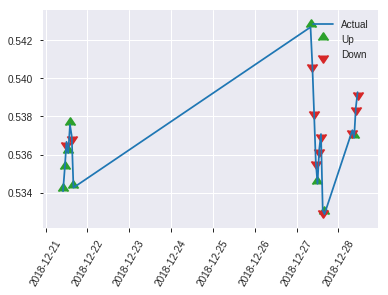


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.19972778912903932
RMSE: 0.44690915086742106
LogLoss: 0.5859316583779207
Mean Per-Class Error: 0.2307244931871053
AUC: 0.8257726819541376
pr_auc: 0.7879517608022236
Gini: 0.6515453639082751
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4789825210570845: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      89   29   0.2458   (29.0/118.0)
1      22   80   0.2157   (22.0/102.0)
Total  111  109  0.2318   (51.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.478983     0.758294  108
max f2                       0.440238     0.842014  167
max f0point5                 0.523932     0.778894  73
max accuracy                 0.478983     0.768182  108
max precision                0.943677     1         0
max recall                   0.247523     1         211
max specificity              0.943677     1         0
max absolute_mcc             0.478983     0.537147  108
max min_per_class_accuracy   0.480583     0.754902  104
max mean_per_class_accuracy  0.478983     0.769276  108

Gains/Lift Table: Avg response rate: 46.36 %, avg score: 50.88 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.912766           2.15686   2.15686            1                0.927081  1                           0.927081            0.0294118       0.0294118                  115.686   115.686
    2        0.0227273                   0.892857           2.15686   2.15686            1                0.906398  1                           0.918808            0.0196078       0.0490196                  115.686   115.686
    3        0.0318182                   0.861148           2.15686   2.15686            1                0.869387  1                           0.904688            0.0196078       0.0686275                  115.686   115.686
    4        0.0409091                   0.846883           1.07843   1.91721            0.5              0.855064  0.888889                    0.89366             0.00980392      0.0784314                  7.84314   91.7211
    5        0.05                        0.812948           2.15686   1.96078            1                0.830535  0.909091                    0.882183            0.0196078       0.0980392                  115.686   96.0784
    6        0.1                         0.693727           1.96078   1.96078            0.909091         0.73728   0.909091                    0.809731            0.0980392       0.196078                   96.0784   96.0784
    7        0.15                        0.632919           1.56863   1.83007            0.727273         0.667525  0.848485                    0.762329            0.0784314       0.27451                    56.8627   83.0065
    8        0.2                         0.603907           1.96078   1.86275            0.909091         0.618586  0.863636                    0.726394            0.0980392       0.372549                   96.0784   86.2745
    9        0.3                         0.547984           1.76471   1.83007            0.818182         0.575101  0.848485                    0.675963            0.176471        0.54902                    76.4706   83.0065
    10       0.4                         0.499194           0.980392  1.61765            0.454545         0.518395  0.75                        0.636571            0.0980392       0.647059                   -1.96078  61.7647
    11       0.5                         0.478355           1.37255   1.56863            0.636364         0.486655  0.727273                    0.606588            0.137255        0.784314                   37.2549   56.8627
    12       0.6                         0.467985           0.686275  1.42157            0.318182         0.473466  0.659091                    0.584401            0.0686275       0.852941                   -31.3725  42.1569
    13       0.7                         0.455902           0.686275  1.31653            0.318182         0.462596  0.61039                     0.567               0.0686275       0.921569                   -31.3725  31.6527
    14       0.8                         0.431933           0.294118  1.18873            0.136364         0.443899  0.551136                    0.551612            0.0294118       0.95098                    -70.5882  18.8725
    15       0.9                         0.372751           0.196078  1.07843            0.0909091        0.40181   0.5                         0.534968            0.0196078       0.970588                   -80.3922  7.84314
    16       1                           0.163455           0.294118  1                  0.136364         0.273064  0.463636                    0.508777         

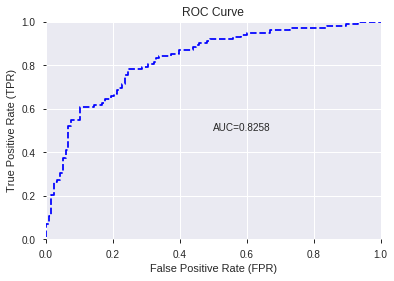

This function is available for GLM models only


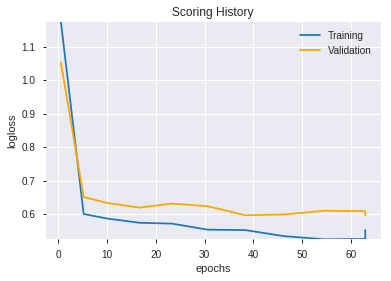

--2019-08-28 16:10:34--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.21.155
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.21.155|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_155912_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_155912_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_bf14',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'TRANGE',
 'CDLCLOSINGMARUBOZU',
 'CDLLONGLINE',
 'CDLSHORTLINE',
 'ADOSC',
 'CDLTAKURI',
 'DX_8',
 'aroonup_30',
 'CDLBELTHOLD',
 'CCI_8',
 'CORREL_14',
 'ADX_8',
 'CCI_12',
 'AROONOSC_8',
 'CCI_24',
 'MINUS_DI_24',
 'aroondown_12',
 'MFI_24',
 'aroondown_8',
 'DX_24',
 'MINUS_DM_24',
 'HT_DCPERIOD',
 'aroondown_24',
 'ADXR_12',
 'DX_30',
 'BETA_20',
 'BETA_8',
 'MINUS_DI_30',
 'PLUS_DM_30',
 'CORREL_12',
 'MFI_20',
 'aroonup_14',
 'WILLR_14',
 'STOCHRSI_fastk',
 'STOCHRSI_fastd',
 'WILLR_12',
 'CORREL_24',
 'HT_PHASOR_quadrature',
 'MOM_12',
 'CDLSPINNINGTOP',
 'ADX_14',
 'NATR_30',
 'AROONOSC_24',
 'ATR_8',
 'VAR_20',
 'CDLDOJI',
 'CDLHARAMI',
 'LINEARREG_SLOPE_20',
 'CDLLONGLEGGEDDOJI',
 'WILLR_30',
 'BETA_24',
 'AROONOSC_12',
 'STOCHF_fastd',
 'WILLR_8',
 'PLUS_DM_24',
 'ATR_14',
 'NATR_8',
 'PPO',
 'ATR_30',
 'ROCR_24',
 'MACDEXT_hist',
 'NATR_12',
 'STOCH_slowk',
 'APO',
 'MOM_20',
 'LINEARREG_ANGLE_20',
 'ROC_24',
 'MACDFIX_hist_14',
 'WILLR_20',
 'LINEARREG_ANGLE_12',

In [52]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id      auc  logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190828_161046_model_1  0.81655  0.53936              0.232968  0.423207  0.179104

variable  relative_importance  scaled_importance    percentage
0                        BOP             0.510556           1.000000  7.461213e-02
1         CDLCLOSINGMARUBOZU             0.223141           0.437055  3.260959e-02
2                     TRANGE             0.209786           0.410897  3.065792e-02
3                      CCI_8             0.177513           0.347686  2.594161e-02
4                      ADOSC             0.176557           0.345812  2.580180e-02
..                       ...                  ...                ...           ...
148  BBANDS_lowerband_20_6_2             0.002892           0.005664  4.226041e-04
149  BBANDS_upperband_24_6_3             0.002294           0.004492  3.351763e-04
150  BBANDS_lowerband_20_6_3             0.000868           0.001700  1.268371e-04
151                   CMO_30             0.000671           0.001315  9.808795e-05
152  BBANDS_upperband_14_7_4             0.000006           0.000011  8.296505e-07

[153 rows x 4 columns]

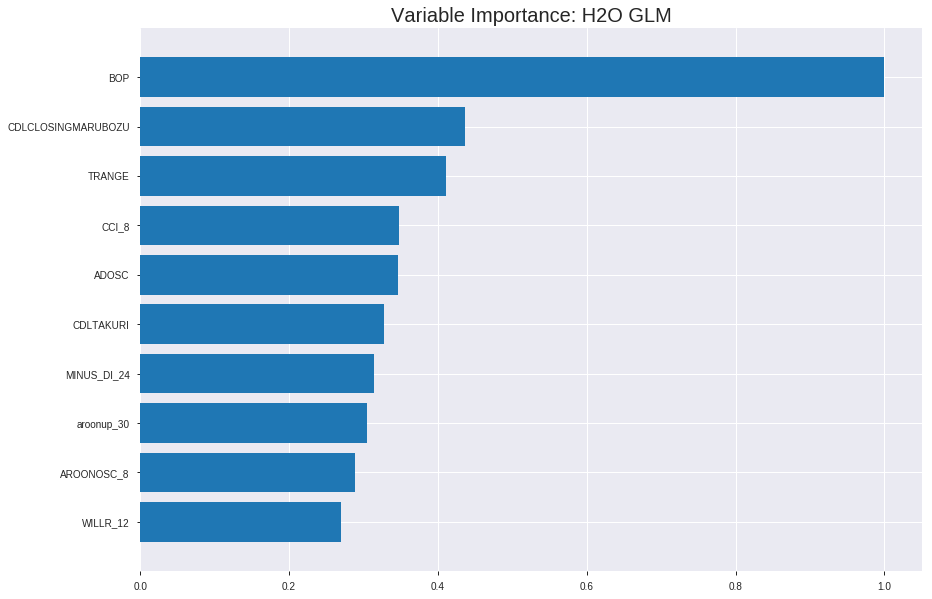

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_161046_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.19236344664478988
RMSE: 0.4385925747716095
LogLoss: 0.5661914569879773
Null degrees of freedom: 1536
Residual degrees of freedom: 1383
Null deviance: 2130.546400580142
Residual deviance: 1740.4725387810422
AIC: 2048.472538781042
AUC: 0.7801522387048703
pr_auc: 0.7779184208412521
Gini: 0.5603044774097405
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.33878015017580126: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      319  458   0.5894   (458.0/777.0)
1      72   688   0.0947   (72.0/760.0)
Total  391  1146  0.3448   (530.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.33878      0.721931  277
max f2                       0.201358     0.842189  340
max f0point5                 0.588536     0.725536  147
max accuracy                 0.543506     0.715029  173
max precision                0.944172     1         0
max recall                   0.0485048    1         396
max specificity              0.944172     1         0
max absolute_mcc             0.560504     0.432393  163
max min_per_class_accuracy   0.51065      0.706579  189
max mean_per_class_accuracy  0.53999      0.714433  174

Gains/Lift Table: Avg response rate: 49.45 %, avg score: 49.45 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.90018            2.02237   2.02237            1                0.917242  1                           0.917242            0.0210526       0.0210526                  102.237   102.237
    2        0.0201692                   0.880513           1.88754   1.95713            0.933333         0.88901   0.967742                    0.903581            0.0184211       0.0394737                  88.7544   95.7131
    3        0.0305791                   0.86352            1.89597   1.93631            0.9375           0.871605  0.957447                    0.892696            0.0197368       0.0592105                  89.597    93.631
    4        0.0403383                   0.855686           1.61789   1.85927            0.8              0.860411  0.919355                    0.884885            0.0157895       0.075                      61.7895   85.9274
    5        0.0500976                   0.838161           2.02237   1.89105            1                0.845347  0.935065                    0.877183            0.0197368       0.0947368                  102.237   89.1046
    6        0.100195                    0.774438           1.75972   1.82538            0.87013          0.802404  0.902597                    0.839793            0.0881579       0.182895                   75.9723   82.5384
    7        0.150293                    0.720328           1.6284    1.75972            0.805195         0.74398   0.87013                     0.807856            0.0815789       0.264474                   62.8401   75.9723
    8        0.20039                     0.685355           1.52334   1.70063            0.753247         0.702654  0.840909                    0.781555            0.0763158       0.340789                   52.3342   70.0628
    9        0.299935                    0.62437            1.46721   1.62316            0.72549          0.656234  0.802603                    0.739963            0.146053        0.486842                   46.7208   62.3159
    10       0.40013                     0.564871           1.20817   1.51924            0.597403         0.59545   0.75122                     0.703776            0.121053        0.607895                   20.8168   51.9243
    11       0.500325                    0.508535           1.01118   1.4175             0.5              0.537038  0.70091                     0.670385            0.101316        0.709211                   1.11842   41.7499
    12       0.59987                     0.441818           0.779868  1.31169            0.385621         0.476516  0.64859                     0.638214            0.0776316       0.786842                   -22.0132  31.1688
    13       0.700065                    0.370334           0.853597  1.24612            0.422078         0.407757  0.616171                    0.60523             0.0855263       0.872368                   -14.6403  24.6125
    14       0.79961                     0.291545           0.541942  1.15846            0.267974         0.332008  0.572823                    0.571216            0.0539474       0.926316                   -45.8058  15.846
    15       0.899805                    0.200002           0.538423  1.08942            0.266234         0.248166  0.538684                    0.535244            0.0539474       0.980263                   -46.1577  8.94176
    16       1                           0.0137924          0.196984  1                  0.0974026        0.128297  0.49447                     0.49447            



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.19534602768107973
RMSE: 0.4419796688548917
LogLoss: 0.5682514193240304
Null degrees of freedom: 439
Residual degrees of freedom: 286
Null deviance: 609.536667332913
Residual deviance: 500.06124900514686
AIC: 808.0612490051469
AUC: 0.7714223575467595
pr_auc: 0.730273820672904
Gini: 0.542844715093519
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.28366279313193343: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      111  120  0.5195   (120.0/231.0)
1      19   190  0.0909   (19.0/209.0)
Total  130  310  0.3159   (139.0/440.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.283663     0.732177  281
max f2                       0.160691     0.850452  346
max f0point5                 0.425557     0.693333  204
max accuracy                 0.425557     0.713636  204
max precision                0.90136      1         0
max recall                   0.0762639    1         384
max specificity              0.90136      1         0
max absolute_mcc             0.425557     0.430216  204
max min_per_class_accuracy   0.441929     0.698565  192
max mean_per_class_accuracy  0.425557     0.715197  204

Gains/Lift Table: Avg response rate: 47.50 %, avg score: 43.80 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113636                   0.871146           2.10526    2.10526            1                0.883299   1                           0.883299            0.0239234       0.0239234                  110.526   110.526
    2        0.0204545                   0.860154           2.10526    2.10526            1                0.864612   1                           0.874994            0.0191388       0.0430622                  110.526   110.526
    3        0.0318182                   0.838142           1.68421    1.95489            0.8              0.85151    0.928571                    0.866607            0.0191388       0.062201                   68.4211   95.4887
    4        0.0409091                   0.83042            2.10526    1.9883             1                0.835884   0.944444                    0.859779            0.0191388       0.0813397                  110.526   98.8304
    5        0.05                        0.800238           1.05263    1.81818            0.5              0.820466   0.863636                    0.852631            0.00956938      0.0909091                  5.26316   81.8182
    6        0.1                         0.733045           1.81818    1.81818            0.863636         0.76857    0.863636                    0.810601            0.0909091       0.181818                   81.8182   81.8182
    7        0.15                        0.684801           1.33971    1.65869            0.636364         0.710789   0.787879                    0.77733             0.0669856       0.248804                   33.9713   65.8692
    8        0.2                         0.649123           1.33971    1.57895            0.636364         0.668611   0.75                        0.750151            0.0669856       0.315789                   33.9713   57.8947
    9        0.3                         0.584437           1.43541    1.5311             0.681818         0.616101   0.727273                    0.705467            0.143541        0.45933                    43.5407   53.11
    10       0.4                         0.511527           1.29187    1.47129            0.613636         0.548939   0.698864                    0.666335            0.129187        0.588517                   29.1866   47.1292
    11       0.5                         0.432388           1.19617    1.41627            0.568182         0.474037   0.672727                    0.627876            0.119617        0.708134                   19.6172   41.6268
    12       0.6                         0.364014           0.956938   1.33971            0.454545         0.401549   0.636364                    0.590154            0.0956938       0.803828                   -4.30622  33.9713
    13       0.7                         0.283987           0.956938   1.28503            0.454545         0.330101   0.61039                     0.553004            0.0956938       0.899522                   -4.30622  28.5031
    14       0.8                         0.220521           0.574163   1.19617            0.272727         0.248309   0.568182                    0.514917            0.0574163       0.956938                   -42.5837  19.6172
    15       0.9                         0.138315           0.334928   1.10048            0.159091         0.173616   0.522727                    0.476995            0.0334928       0.990431                   -66.5072  10.0478
    16       1                           0.0257606          0.0956938  1                  0.0454545        0.0869053  0.475      


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-28 16:10:46  0.000 sec   2            .2E2      154           1.3675504086386654  1.3680580730307406
     2019-08-28 16:10:46  0.063 sec   4            .15E2     154           1.3622967844453129  1.3627267612427694
     2019-08-28 16:10:46  0.131 sec   6            .11E2     154           1.3558306859452     1.3559242406631729
     2019-08-28 16:10:46  0.210 sec   8            .78E1     154           1.348003349107412   1.3473269890920927
     2019-08-28 16:10:46  0.273 sec   10           .56E1     154           1.3386110830266358  1.3366126906244784
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-28 16:10:48  1.411 sec   44           .26E-1    154           1.1263607424492317  1.1367308201986284
     2019-08-28 16:10:48  1.482 sec   46           .19E-1    154           1.1211127180150255  1.1376031239436566
     2019-08-28 16:10:48  1.553 sec   48           .14E-1    154           1.1164922160461952  1.1384677632606723
     2019-08-28 16:10:48  1.620 sec   50           .98E-2    154           1.1126120714317147  1.1400935860187587
     2019-08-28 16:10:48  1.701 sec   52           .72E-2    154           1.1090774605244595  1.1415353562552297


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7636363636363637)

('F1', 0.761467889908257)

('auc', 0.8165503489531406)

('logloss', 0.5393603467395692)

('mean_per_class_error', 0.23296776337653702)

('rmse', 0.4232066229246903)

('mse', 0.179103845687321)

glm prediction progress: |████████████████████████████████████████████████| 100%


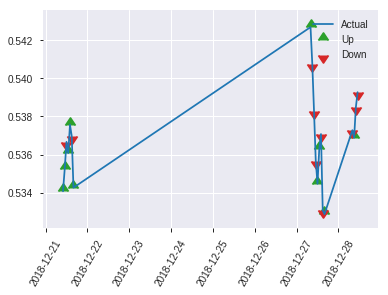


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.179103845687321
RMSE: 0.4232066229246903
LogLoss: 0.5393603467395692
Null degrees of freedom: 219
Residual degrees of freedom: 66
Null deviance: 304.6577240810208
Residual deviance: 237.31855256541053
AIC: 545.3185525654105
AUC: 0.8165503489531406
pr_auc: 0.7785478804456024
Gini: 0.6331006979062812
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3724514724265881: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      85   33   0.2797   (33.0/118.0)
1      19   83   0.1863   (19.0/102.0)
Total  104  116  0.2364   (52.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.372451     0.761468  115
max f2                       0.185819     0.837563  182
max f0point5                 0.510423     0.762332  85
max accuracy                 0.510423     0.763636  85
max precision                0.935239     1         0
max recall                   0.0410754    1         215
max specificity              0.935239     1         0
max absolute_mcc             0.372451     0.533444  115
max min_per_class_accuracy   0.423441     0.754902  104
max mean_per_class_accuracy  0.372451     0.767032  115

Gains/Lift Table: Avg response rate: 46.36 %, avg score: 41.37 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.875165           2.15686   2.15686            1                0.900461   1                           0.900461            0.0294118       0.0294118                  115.686   115.686
    2        0.0227273                   0.855927           2.15686   2.15686            1                0.864551   1                           0.886097            0.0196078       0.0490196                  115.686   115.686
    3        0.0318182                   0.835851           1.07843   1.84874            0.5              0.841646   0.857143                    0.873397            0.00980392      0.0588235                  7.84314   84.8739
    4        0.0409091                   0.803914           2.15686   1.91721            1                0.832105   0.888889                    0.864221            0.0196078       0.0784314                  115.686   91.7211
    5        0.05                        0.785639           2.15686   1.96078            1                0.792268   0.909091                    0.851138            0.0196078       0.0980392                  115.686   96.0784
    6        0.1                         0.703789           1.96078   1.96078            0.909091         0.745046   0.909091                    0.798092            0.0980392       0.196078                   96.0784   96.0784
    7        0.15                        0.667114           1.56863   1.83007            0.727273         0.682789   0.848485                    0.759658            0.0784314       0.27451                    56.8627   83.0065
    8        0.2                         0.61065            1.56863   1.76471            0.727273         0.630678   0.818182                    0.727413            0.0784314       0.352941                   56.8627   76.4706
    9        0.3                         0.558964           1.66667   1.73203            0.772727         0.579887   0.80303                     0.678238            0.166667        0.519608                   66.6667   73.2026
    10       0.4                         0.496048           1.56863   1.69118            0.727273         0.529961   0.784091                    0.641168            0.156863        0.676471                   56.8627   69.1176
    11       0.5                         0.39218            0.980392  1.54902            0.454545         0.447408   0.718182                    0.602416            0.0980392       0.77451                    -1.96078  54.902
    12       0.6                         0.314782           0.686275  1.40523            0.318182         0.348295   0.651515                    0.560063            0.0686275       0.843137                   -31.3725  40.5229
    13       0.7                         0.269039           0.392157  1.2605             0.181818         0.290105   0.584416                    0.521497            0.0392157       0.882353                   -60.7843  26.0504
    14       0.8                         0.213577           0.686275  1.18873            0.318182         0.242757   0.551136                    0.486655            0.0686275       0.95098                    -31.3725  18.8725
    15       0.9                         0.131499           0.196078  1.07843            0.0909091        0.169464   0.5                         0.451411            0.0196078       0.970588                   -80.3922  7.84314
    16       1                           0.0270464          0.294118  1                  0.136364         0.0739585  0.463636                    

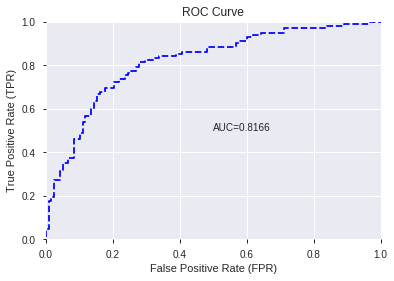

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


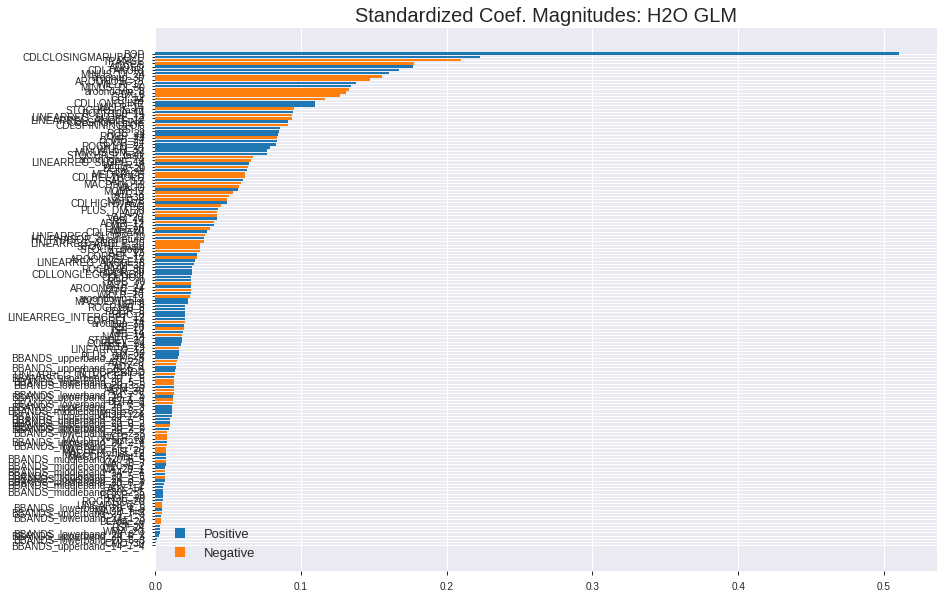

'log_likelihood'
--2019-08-28 16:10:56--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.230.27
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.230.27|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_161046_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_161046_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_bf14',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['BOP',
 'CDLCLOSINGMARUBOZU',
 'TRANGE',
 'CCI_8',
 'ADOSC',
 'CDLTAKURI',
 'MINUS_DI_24',
 'aroonup_30',
 'AROONOSC_8',
 'WILLR_12',
 'MINUS_DI_30',
 'aroondown_8',
 'DX_8',
 'CCI_12',
 'CCI_24',
 'CDLLONGLINE',
 'WILLR_14',
 'STOCHRSI_fastd',
 'ROCR100_14',
 'LINEARREG_SLOPE_12',
 'LINEARREG_ANGLE_12',
 'CDLSHORTLINE',
 'CDLSPINNINGTOP',
 'RSI_8',
 'ROC_24',
 'ROCP_24',
 'MFI_24',
 'ROCR_24',
 'ROCR100_24',
 'WILLR_30',
 'MINUS_DM_24',
 'STOCHRSI_fastk',
 'aroondown_24',
 'LINEARREG_SLOPE_14',
 'WILLR_8',
 'BETA_20',
 'DX_24',
 'MEDPRICE',
 'CDLBELTHOLD',
 'SAR_0.2',
 'MACDFIX_12',
 'MACD',
 'MOM_12',
 'ATR_8',
 'CCI_30',
 'NATR_8',
 'CDLHIGHWAVE',
 'PPO',
 'PLUS_DM_30',
 'APO',
 'VAR_20',
 'RSI_14',
 'ADXR_12',
 'CMO_14',
 'MFI_20',
 'CDLHARAMI',
 'LINEARREG_SLOPE_20',
 'HT_PHASOR_quadrature',
 'LINEARREG_ANGLE_20',
 'STOCHF_fastd',
 'STOCH_slowk',
 'ATR_12',
 'CORREL_12',
 'AROONOSC_12',
 'LINEARREG_ANGLE_8',
 'MOM_30',
 'ROCR100_30',
 'ROCR_30',
 'CDLLONGLEGGEDDOJI',
 'CDLDOJI',


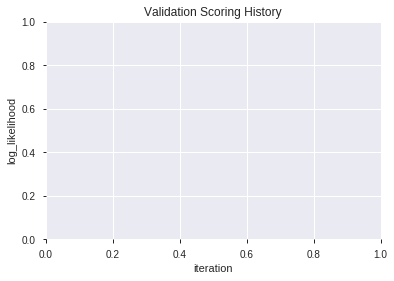

In [53]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190828_161105_model_4  0.790379  0.565584              0.254154  0.436339  0.190392
1               XGBoost_2_AutoML_20190828_161105  0.776005  0.575112              0.274011  0.441992  0.195357
2               XGBoost_3_AutoML_20190828_161105  0.776005  0.579018              0.297441  0.443786  0.196946
3  XGBoost_grid_1_AutoML_20190828_161105_model_3  0.772100  0.578154              0.314390  0.443638  0.196815
4  XGBoost_grid_1_AutoML_20190828_161105_model_2  0.760219  0.595599              0.340063  0.451383  0.203747
5               XGBoost_1_AutoML_20190828_161105  0.748255  0.589666              0.311482  0.450096  0.202586
6  XGBoost_grid_1_AutoML_20190828_161105_model_6  0.745680  0.592080              0.310568  0.451207  0.203588
7  XGBoost_grid_1_AutoML_20190828_161105_model_7  0.742024  0.591329              0.337820  0.451926  0.204238
8  XGBoost_grid_1_AutoML_20190828_161105_model_1  0.740528  0.593758              0.384015  0.452597  0.204844
9  XGBoost_grid_1_AutoML_20190828_161105_model_5  0.723164  0.617587              0.355434  0.463444  0.214780

variable  relative_importance  scaled_importance  percentage
0                       BOP          1947.245239           1.000000    0.413660
1                    TRANGE           650.515381           0.334070    0.138191
2                     ADOSC           140.127045           0.071962    0.029768
3                     CCI_8           129.769150           0.066642    0.027567
4                   WILLR_8           113.131691           0.058098    0.024033
..                      ...                  ...                ...         ...
87    LINEARREG_INTERCEPT_8             4.522591           0.002323    0.000961
88                 MEDPRICE             4.022283           0.002066    0.000854
89                   ROC_20             3.590775           0.001844    0.000763
90  BBANDS_upperband_20_6_5             3.553000           0.001825    0.000755
91                    DX_24             2.328488           0.001196    0.000495

[92 rows x 4 columns]

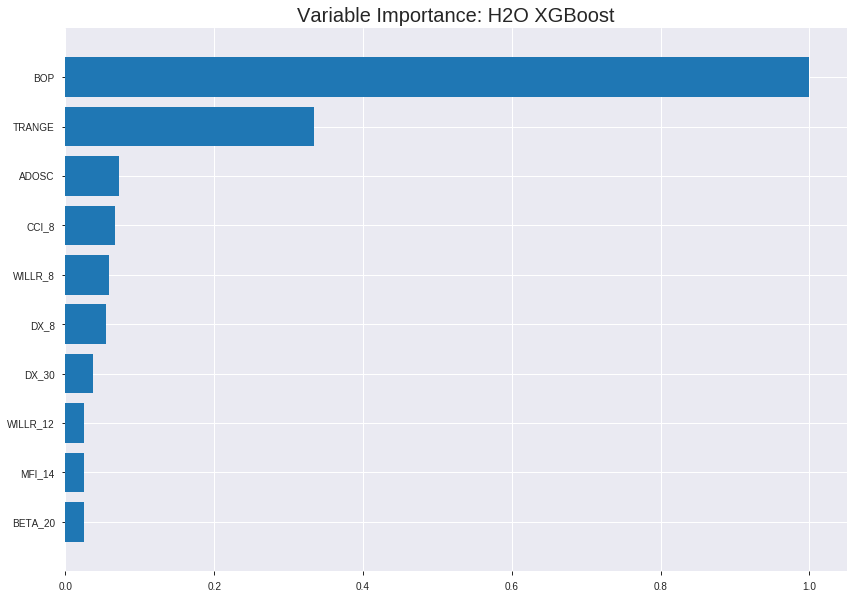

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190828_161105_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1753407973551605
RMSE: 0.418737145898427
LogLoss: 0.530051160159194
Mean Per-Class Error: 0.2459679604416447
AUC: 0.8312097812097813
pr_auc: 0.8297896796679496
Gini: 0.6624195624195626
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4337690472602844: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      494  283  0.3642   (283.0/777.0)
1      126  634  0.1658   (126.0/760.0)
Total  620  917  0.2661   (409.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.433769     0.756112  229
max f2                       0.295119     0.862392  309
max f0point5                 0.569146     0.770295  152
max accuracy                 0.556664     0.754717  160
max precision                0.862885     1         0
max recall                   0.161312     1         376
max specificity              0.862885     1         0
max absolute_mcc             0.556664     0.513815  160
max min_per_class_accuracy   0.507169     0.746053  187
max mean_per_class_accuracy  0.546644     0.754032  165

Gains/Lift Table: Avg response rate: 49.45 %, avg score: 49.57 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.830556           2.02237    2.02237            1                0.842477  1                           0.842477            0.0210526       0.0210526                  102.237   102.237
    2        0.0201692                   0.821543           2.02237    2.02237            1                0.825788  1                           0.834402            0.0197368       0.0407895                  102.237   102.237
    3        0.0305791                   0.813955           2.02237    2.02237            1                0.817719  1                           0.828723            0.0210526       0.0618421                  102.237   102.237
    4        0.0403383                   0.802854           2.02237    2.02237            1                0.806755  1                           0.823408            0.0197368       0.0815789                  102.237   102.237
    5        0.0500976                   0.794922           1.75272    1.96984            0.866667         0.798819  0.974026                    0.818618            0.0171053       0.0986842                  75.2719   96.9839
    6        0.100195                    0.768728           1.89105    1.93044            0.935065         0.779961  0.954545                    0.79929             0.0947368       0.193421                   89.1046   93.0443
    7        0.150293                    0.736937           1.78599    1.88229            0.883117         0.75303   0.930736                    0.78387             0.0894737       0.282895                   78.5988   88.2291
    8        0.20039                     0.704104           1.52334    1.79255            0.753247         0.720732  0.886364                    0.768085            0.0763158       0.359211                   52.3342   79.2554
    9        0.299935                    0.632893           1.57295    1.71967            0.777778         0.666286  0.850325                    0.734299            0.156579        0.515789                   57.2953   71.9671
    10       0.40013                     0.571538           1.33949    1.62447            0.662338         0.604754  0.803252                    0.70186             0.134211        0.65                       33.9491   62.4472
    11       0.500325                    0.502642           0.971787   1.49376            0.480519         0.537194  0.738622                    0.668884            0.0973684       0.747368                   -2.82126  49.3765
    12       0.59987                     0.429489           0.885612   1.39285            0.437908         0.466548  0.68872                     0.635308            0.0881579       0.835526                   -11.4388  39.2846
    13       0.700065                    0.361902           0.722274   1.29687            0.357143         0.396432  0.641264                    0.601119            0.0723684       0.907895                   -27.7726  29.6872
    14       0.79961                     0.295468           0.608032   1.21112            0.300654         0.324873  0.598861                    0.566729            0.0605263       0.968421                   -39.1968  21.1117
    15       0.899805                    0.217879           0.236381   1.10258            0.116883         0.257301  0.545192                    0.532274            0.0236842       0.992105                   -76.3619  10.2578
    16       1                           0.101848           0.0787936  1                  0.038961         0.166782  0.49447                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.20229441794189204
RMSE: 0.4497715174862588
LogLoss: 0.59030180606777
Mean Per-Class Error: 0.29414445203918893
AUC: 0.7512997369456699
pr_auc: 0.6840946461198328
Gini: 0.5025994738913397
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35655471682548523: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      119  112  0.4848   (112.0/231.0)
1      26   183  0.1244   (26.0/209.0)
Total  145  295  0.3136   (138.0/440.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.356555     0.72619   267
max f2                       0.220933     0.844316  344
max f0point5                 0.499774     0.674641  189
max accuracy                 0.396668     0.7       242
max precision                0.840731     1         0
max recall                   0.159294     1         384
max specificity              0.840731     1         0
max absolute_mcc             0.396668     0.420914  242
max min_per_class_accuracy   0.487806     0.679426  196
max mean_per_class_accuracy  0.396668     0.705856  242

Gains/Lift Table: Avg response rate: 47.50 %, avg score: 47.96 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113636                   0.826479           2.10526   2.10526            1                0.834026  1                           0.834026            0.0239234       0.0239234                  110.526   110.526
    2        0.0204545                   0.810735           1.05263   1.63743            0.5              0.816789  0.777778                    0.826365            0.00956938      0.0334928                  5.26316   63.7427
    3        0.0318182                   0.80074            1.68421   1.65414            0.8              0.804364  0.785714                    0.818508            0.0191388       0.0526316                  68.4211   65.4135
    4        0.0409091                   0.79402            1.57895   1.63743            0.75             0.796472  0.777778                    0.813611            0.0143541       0.0669856                  57.8947   63.7427
    5        0.05                        0.787936           1.57895   1.62679            0.75             0.791504  0.772727                    0.809591            0.0143541       0.0813397                  57.8947   62.6794
    6        0.1                         0.757272           1.5311    1.57895            0.727273         0.773542  0.75                        0.791567            0.076555        0.157895                   53.11     57.8947
    7        0.15                        0.719455           1.5311    1.563              0.727273         0.737414  0.742424                    0.773516            0.076555        0.23445                    53.11     56.2998
    8        0.2                         0.680366           1.62679   1.57895            0.772727         0.701359  0.75                        0.755477            0.0813397       0.315789                   62.6794   57.8947
    9        0.3                         0.619984           1.29187   1.48325            0.613636         0.648073  0.704545                    0.719675            0.129187        0.444976                   29.1866   48.3254
    10       0.4                         0.557129           1.24402   1.42344            0.590909         0.58958   0.676136                    0.687152            0.124402        0.569378                   24.4019   42.3445
    11       0.5                         0.481229           1.19617   1.37799            0.568182         0.522898  0.654545                    0.654301            0.119617        0.688995                   19.6172   37.799
    12       0.6                         0.402871           1.19617   1.34769            0.568182         0.443946  0.640152                    0.619242            0.119617        0.808612                   19.6172   34.7687
    13       0.7                         0.34294            0.76555   1.26452            0.363636         0.369996  0.600649                    0.583635            0.076555        0.885167                   -23.445   26.4525
    14       0.8                         0.269765           0.574163  1.17823            0.272727         0.30805   0.559659                    0.549187            0.0574163       0.942584                   -42.5837  17.823
    15       0.9                         0.199026           0.430622  1.09516            0.204545         0.233298  0.520202                    0.514088            0.0430622       0.985646                   -56.9378  9.51621
    16       1                           0.12759            0.143541  1                  0.0681818        0.169216  0.475                       0.479601           


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 16:11:16  4.903 sec   0                  0.5              0.693147            0.5             0                  1                0.50553                          0.5                0.693147              0.5               0                    1                  0.525
    2019-08-28 16:11:16  5.135 sec   5                  0.478787         0.651371            0.777488        0.682382           1.80949          0.349382                         0.480452           0.654574              0.747478          0.600227             1.68421            0.309091
    2019-08-28 16:11:16  5.222 sec   10                 0.464474         0.623354            0.780597        0.741528           1.93044          0.320104                         0.466774           0.62763               0.754531          0.674654             2.10526            0.315909
    2019-08-28 16:11:16  5.310 sec   15                 0.454983         0.604537            0.787347        0.769771           1.82013          0.318803                         0.459085           0.612084              0.757017          0.690765             1.80451            0.302273
    2019-08-28 16:11:17  5.404 sec   20                 0.447499         0.58948             0.793198        0.781382           1.89597          0.314899                         0.454641           0.602692              0.758653          0.702999             2.10526            0.3
    2019-08-28 16:11:17  5.496 sec   25                 0.442098         0.578207            0.795969        0.781098           1.89597          0.310995                         0.452681           0.598203              0.756851          0.698186             2.10526            0.293182
    2019-08-28 16:11:17  5.589 sec   30                 0.437539         0.568655            0.801152        0.792158           1.89597          0.309044                         0.451392           0.595119              0.755691          0.697864             2.10526            0.306818
    2019-08-28 16:11:17  5.683 sec   35                 0.433795         0.560826            0.805821        0.79669            2.02237          0.307742                         0.449922           0.591639              0.756799          0.697825             2.10526            0.288636
    2019-08-28 16:11:17  5.789 sec   40                 0.430382         0.553727            0.810772        0.803497           2.02237          0.303839                         0.44945            0.590202              0.756312          0.694315             2.10526            0.313636
    2019-08-28 16:11:17  5.893 sec   45                 0.426896         0.546455            0.815699        0.808967           2.02237          0.30514                          0.449049           0.589193              0.756623          0.697258             2.10526            0.315909
    2019-08-28 16:11:17  5.985 sec   50                 0.424211         0.54105             0.821439        0.816702           2.02237          0.280416                         0.448897           0.588568              0.75509           0.696402             2.10526            0.3
    2019-08-28 16:11:17  6.087 sec   55                 0.421355         0.535389            0.826988        0.824317           2.02237          0.268055                         0.449584           0.589937              0.752646          0.69003       

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ---------------------
BOP                      1947.2452392578125     1.0                    0.4136595828623318
TRANGE                   650.515380859375       0.33406957056283126    0.13819107920601909
ADOSC                    140.12704467773438     0.07196168302413898    0.029767639781836677
CCI_8                    129.76914978027344     0.06664242755048902    0.02756727878146846
WILLR_8                  113.1316909790039      0.05809832716403187    0.024032929779672706
---                      ---                    ---                    ---
LINEARREG_INTERCEPT_8    4.522590637207031      0.0023225583229212594  0.0009607485070330451
MEDPRICE                 4.02228307723999       0.002065627377665626   0.0008544665593941753
ROC_20                   3.590775489807129      0.0018440283829764266  0.0007628000116883289
BBANDS_upperband_20_6_5  3.55299973487854       0.0018246287952064818  0.0007547751863037123
DX_24                    2.3284878730773926     0.0011957856289148713  0.0004946481844496968


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7454545454545455)

('F1', 0.7443946188340808)

('auc', 0.7903788634097707)

('logloss', 0.5655839374912665)

('mean_per_class_error', 0.2541542040545032)

('rmse', 0.43633897421826384)

('mse', 0.19039170042184672)

xgboost prediction progress: |████████████████████████████████████████████| 100%


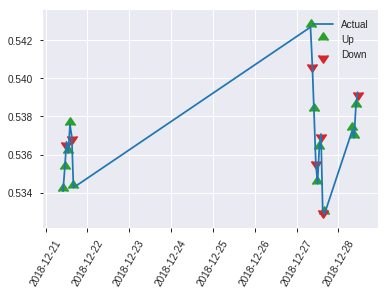


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.19039170042184672
RMSE: 0.43633897421826384
LogLoss: 0.5655839374912665
Mean Per-Class Error: 0.2541542040545032
AUC: 0.7903788634097707
pr_auc: 0.6993926322970654
Gini: 0.5807577268195414
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4368653893470764: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      80   38   0.322    (38.0/118.0)
1      19   83   0.1863   (19.0/102.0)
Total  99   121  0.2591   (57.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.436865     0.744395  120
max f2                       0.281839     0.845896  188
max f0point5                 0.50291      0.727092  99
max accuracy                 0.50291      0.745455  99
max precision                0.835659     1         0
max recall                   0.22346      1         200
max specificity              0.835659     1         0
max absolute_mcc             0.436865     0.49286   120
max min_per_class_accuracy   0.489177     0.72549   104
max mean_per_class_accuracy  0.436865     0.745846  120

Gains/Lift Table: Avg response rate: 46.36 %, avg score: 49.46 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.830092           2.15686    2.15686            1                0.833674  1                           0.833674            0.0294118       0.0294118                  115.686   115.686
    2        0.0227273                   0.820339           0          1.29412            0                0.82308   0.6                         0.829436            0               0.0294118                  -100      29.4118
    3        0.0318182                   0.812451           1.07843    1.23249            0.5              0.817958  0.571429                    0.826157            0.00980392      0.0392157                  7.84314   23.2493
    4        0.0409091                   0.796945           2.15686    1.43791            1                0.804895  0.666667                    0.821432            0.0196078       0.0588235                  115.686   43.7908
    5        0.05                        0.789765           1.07843    1.37255            0.5              0.795371  0.636364                    0.816693            0.00980392      0.0686275                  7.84314   37.2549
    6        0.1                         0.770343           1.76471    1.56863            0.818182         0.779191  0.727273                    0.797942            0.0882353       0.156863                   76.4706   56.8627
    7        0.15                        0.738368           1.76471    1.63399            0.818182         0.757669  0.757576                    0.784518            0.0882353       0.245098                   76.4706   63.3987
    8        0.2                         0.713992           1.56863    1.61765            0.727273         0.727788  0.75                        0.770335            0.0784314       0.323529                   56.8627   61.7647
    9        0.3                         0.624808           1.56863    1.60131            0.727273         0.673133  0.742424                    0.737934            0.156863        0.480392                   56.8627   60.1307
    10       0.4                         0.555565           1.47059    1.56863            0.681818         0.594281  0.727273                    0.702021            0.147059        0.627451                   47.0588   56.8627
    11       0.5                         0.470289           1.27451    1.5098             0.590909         0.509437  0.7                         0.663504            0.127451        0.754902                   27.451    50.9804
    12       0.6                         0.418648           0.882353   1.40523            0.409091         0.440286  0.651515                    0.626301            0.0882353       0.843137                   -11.7647  40.5229
    13       0.7                         0.359812           0.686275   1.30252            0.318182         0.387737  0.603896                    0.592221            0.0686275       0.911765                   -31.3725  30.2521
    14       0.8                         0.3195             0.392157   1.18873            0.181818         0.339175  0.551136                    0.56059             0.0392157       0.95098                    -60.7843  18.8725
    15       0.9                         0.232113           0.392157   1.10022            0.181818         0.281343  0.510101                    0.529562            0.0392157       0.990196                   -60.7843  10.0218
    16       1                           0.137516           0.0980392  1                  0.0454545        0.179469  0.463636                   

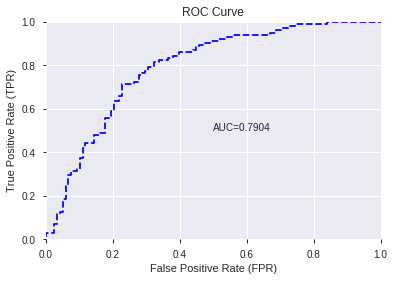

This function is available for GLM models only


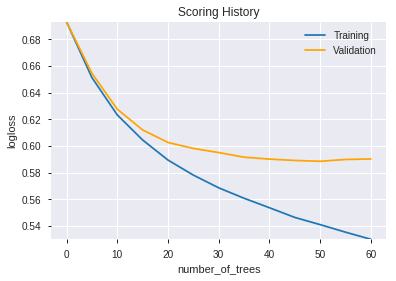

--2019-08-28 16:11:31--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.110.19
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.110.19|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190828_161105_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190828_161105_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_bf14',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['BOP',
 'TRANGE',
 'ADOSC',
 'CCI_8',
 'WILLR_8',
 'DX_8',
 'DX_30',
 'WILLR_12',
 'MFI_14',
 'BETA_20',
 'STOCHRSI_fastk',
 'MINUS_DM_24',
 'ROCR100_14',
 'ROC_24',
 'NATR_30',
 'BETA_24',
 'CCI_12',
 'AROONOSC_12',
 'MFI_8',
 'BBANDS_lowerband_24_7_5',
 'STDDEV_20',
 'aroondown_24',
 'STOCHRSI_fastd',
 'MACDFIX_hist_20',
 'HT_PHASOR_quadrature',
 'PLUS_DM_24',
 'CORREL_14',
 'SAR_0.2',
 'ADXR_12',
 'ATR_14',
 'CORREL_12',
 'MFI_20',
 'LINEARREG_ANGLE_12',
 'ADX_8',
 'MOM_30',
 'WILLR_20',
 'ROC_8',
 'NATR_14',
 'STOCH_slowk',
 'RSI_8',
 'BBANDS_lowerband_20_2_5',
 'AROONOSC_24',
 'MOM_20',
 'WILLR_24',
 'ADX_14',
 'MINUS_DI_24',
 'WILLR_14',
 'BBANDS_upperband_20_1_3',
 'MACDFIX_hist_8',
 'BBANDS_upperband_20_2_5',
 'aroonup_14',
 'BETA_8',
 'LINEARREG_SLOPE_14',
 'LINEARREG_ANGLE_8',
 'MINUS_DI_30',
 'MACDEXT_hist',
 'RSI_24',
 'aroondown_8',
 'ATR_12',
 'WILLR_30',
 'APO',
 'MACDFIX_12',
 'BBANDS_upperband_20_0_2',
 'CCI_30',
 'ATR_30',
 'AROONOSC_8',
 'HT_DCPERIOD',
 'MA_20_1',
 

In [54]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [55]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.773
GLM             0.764
XGBoost         0.755
dtype: float64

DeepLearning    GLM  XGBoost
All          0.768  0.764    0.755
DLF          0.768  0.759    0.745
Fwe          0.773  0.755    0.755
RFE          0.768  0.764    0.745
XGBF         0.750  0.759    0.745





F1


DeepLearning    0.779
GLM             0.761
XGBoost         0.744
dtype: float64

DeepLearning    GLM  XGBoost
All          0.779  0.759    0.738
DLF          0.741  0.739    0.736
Fwe          0.762  0.755    0.744
RFE          0.758  0.761    0.744
XGBF         0.715  0.739    0.736





auc


DeepLearning    0.826
GLM             0.821
XGBoost         0.809
dtype: float64

DeepLearning    GLM  XGBoost
All          0.826  0.821    0.795
DLF          0.805  0.806    0.782
Fwe          0.816  0.809    0.809
RFE          0.826  0.817    0.790
XGBF         0.789  0.806    0.782





logloss


DeepLearning    0.586
GLM             0.547
XGBoost         0.566
dtype: float64

DeepLearning    GLM  XGBoost
All          0.556  0.546    0.562
DLF          0.548  0.547    0.565
Fwe          0.545  0.536    0.540
RFE          0.586  0.539    0.566
XGBF         0.563  0.547    0.565





mean_per_class_error


DeepLearning    0.260
GLM             0.243
XGBoost         0.256
dtype: float64

DeepLearning    GLM  XGBoost
All          0.224  0.234    0.249
DLF          0.235  0.243    0.256
Fwe          0.226  0.241    0.247
RFE          0.231  0.233    0.254
XGBF         0.260  0.243    0.256





rmse


DeepLearning    0.447
GLM             0.429
XGBoost         0.436
dtype: float64

DeepLearning    GLM  XGBoost
All          0.433  0.429    0.434
DLF          0.430  0.428    0.436
Fwe          0.426  0.423    0.424
RFE          0.447  0.423    0.436
XGBF         0.437  0.428    0.436





mse


DeepLearning    0.200
GLM             0.184
XGBoost         0.190
dtype: float64

DeepLearning    GLM  XGBoost
All          0.187  0.184    0.188
DLF          0.185  0.184    0.190
Fwe          0.182  0.179    0.180
RFE          0.200  0.179    0.190
XGBF         0.191  0.184    0.190

{'F1':       DeepLearning    GLM  XGBoost
 All          0.779    NaN      NaN
 DLF          0.741    NaN      NaN
 DLF            NaN  0.739      NaN
 DLF            NaN    NaN    0.736
 All            NaN  0.759      NaN
 All            NaN    NaN    0.738
 XGBF         0.715    NaN      NaN
 XGBF           NaN  0.739      NaN
 XGBF           NaN    NaN    0.736
 Fwe          0.762    NaN      NaN
 Fwe            NaN  0.755      NaN
 Fwe            NaN    NaN    0.744
 RFE          0.758    NaN      NaN
 RFE            NaN  0.761      NaN
 RFE            NaN    NaN    0.744,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.768    NaN      NaN
 DLF          0.768    NaN      NaN
 DLF            NaN  0.759      NaN
 DLF            NaN    NaN    0.745
 All            NaN  0.764      NaN
 All            NaN    NaN    0.755
 XGBF         0.750    NaN      NaN
 XGBF           NaN  0.759      NaN
 XGBF           NaN    NaN    0.745
 Fwe          0.773    NaN      NaN
 Fwe     